In [89]:
#import micropip
#await micropip.install('seaborn')
#await micropip.install('missingno')
#await micropip.install('scipy')
#await micropip.install('optuna')
#await micropip.install('matplotlib')

import pandas as pd
import joblib
import missingno as msno
import numpy as np
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.isotonic import IsotonicRegression
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
from sklearn.model_selection import cross_val_score
import warnings
from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report, roc_auc_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import learning_curve, cross_val_score

warnings.filterwarnings('ignore')

plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (12, 8)
pd.options.mode.chained_assignment = None

In [90]:
def load_data(filepath, make_copy=True):
    df = pd.read_csv(filepath)
    df_copy = df.copy() if make_copy else None
    return df, df_copy

In [91]:
def display_basic_info(df):
    print("=== DATASET INFO ===")
    df.info()
    print("\n=== FIRST 5 ROWS ===")
    display(df.head())
    print("\n=== DESCRIPTIVE STATISTICS ===")
    display(df.describe())
    return df.info(), df.describe()

In [92]:
def analyze_missing_data(df, missing_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE']):
    print("=== MISSING DATA REPORT ===")
    for col in missing_cols:
        missing_count = df[col].isnull().sum()
        missing_pct = 100 * missing_count / len(df)
        print(f"{col}: {missing_pct:.2f}% ({missing_count}/{len(df)})")
    return {col: df[col].isnull().sum() for col in missing_cols}

In [93]:
def analyze_missingness_mechanism(
    df,
    target_vars=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    predictor_vars=['VEHICLE_YEAR', 'DRIVING_EXPERIENCE', 'VEHICLE_TYPE']
):
    results = []
    for target in target_vars:
        for predictor in predictor_vars:
            contingency = pd.crosstab(df[predictor], df[target].isnull())
            chi2, p_value, dof, expected = chi2_contingency(contingency)
            results.append({
                'Target': target,
                'Predictor': predictor,
                'Chi2': chi2,
                'p-value': p_value,
                'Mechanism': 'MAR' if p_value < 0.05 else 'MCAR'
            })
    return pd.DataFrame(results)

In [94]:
def plot_chi2_heatmap(summary_df, figsize=(10, 6)):
    pivot = summary_df.pivot(index='Predictor', columns='Target', values='p-value')
    plt.figure(figsize=figsize)
    sns.heatmap(pivot, annot=True, cmap='coolwarm', fmt='.4f', cbar_kws={'label': 'p-value'})
    plt.title('Missingness Mechanism Test (Chi-Square p-values)')
    plt.tight_layout()
    plt.show()

In [95]:
def encode_ordinal_features(
    df,
    ordinal_mapping=None
):
    if ordinal_mapping is None:
        ordinal_mapping = {
            'DRIVING_EXPERIENCE': {'0-9y': 0, '10-19y': 1, '20-29y': 2, '30y+': 3},
            'EDUCATION': {'none': 0, 'high school': 1, 'university': 2},
            'INCOME': {'poverty': 0, 'working class': 1, 'middle class': 2, 'upper class': 3},
            'VEHICLE_YEAR': {'before 2015': 0, 'after 2015': 1},
            'AGE': {'16-25': 0, '26-39': 1, '40-64': 2, '65+': 3}
        }
    
    for col, mapping in ordinal_mapping.items():
        if col in df.columns:
            df[col] = df[col].map(mapping).astype('int8')
    return df

In [96]:
def encode_binary_features(
    df,
    binary_vars=['GENDER', 'VEHICLE_TYPE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN', 'RACE']
):
    from sklearn.preprocessing import LabelEncoder
    for col in binary_vars:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str)).astype('int8')
    return df

In [97]:
def encode_categorical_features(
    df,
    cat_vars=['RACE']
):
    from sklearn.preprocessing import LabelEncoder
    for col in cat_vars:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str)).astype('int8')
    return df

In [98]:
def optimize_numeric_dtypes(df):
    df['ID'] = df['ID'].astype('int32')
    df['POSTAL_CODE'] = df['POSTAL_CODE'].astype('int32')
    
    count_cols = ['SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS', 'OUTCOME']
    for col in count_cols:
        if col in df.columns:
            df[col] = df[col].astype('int8')
    
    float_cols = ['CREDIT_SCORE', 'ANNUAL_MILEAGE']
    for col in float_cols:
        if col in df.columns:
            df[col] = df[col].astype('float32')
    return df

In [99]:
def drop_missing_values(
    df,
    subset_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    check_outcome=True
):
    print(f"Dataset shape before: {df.shape}")
    print(f"Nulls before:\n{df[subset_cols].isnull().sum()}")
    
    df_clean = df.dropna(subset=subset_cols).copy()
    
    dropped = len(df) - len(df_clean)
    print(f"\nRecords dropped: {dropped:,} ({100*dropped/len(df):.1f}%)")
    print(f"Dataset shape after: {df_clean.shape}")
    
    if check_outcome and 'OUTCOME' in df.columns:
        print("\n=== TARGET PRESERVATION ===")
        print(f"Claim rate BEFORE: {df['OUTCOME'].mean():.4f}")
        print(f"Claim rate AFTER:  {df_clean['OUTCOME'].mean():.4f}")
        diff = abs(df['OUTCOME'].mean() - df_clean['OUTCOME'].mean())
        print(f"Difference: {diff:.4f}")
        print("✅ Preserved" if diff < 0.02 else "⚠️ Shifted")
    
    return df_clean

In [100]:
def test_normality(
    df,
    numeric_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE'],
    sample_size=5000
):
    print("=== NORMALITY TESTS (Shapiro-Wilk & Kolmogorov-Smirnov) ===")
    results = []
    
    for col in numeric_cols:
        x = df[col].dropna().values.astype(float)
        
        x_sample = np.random.choice(x, size=min(sample_size, len(x)), replace=False) if len(x) > sample_size else x
        sh_stat, sh_p = stats.shapiro(x_sample)
        
        x_z = (x - x.mean()) / x.std(ddof=1)
        ks_stat, ks_p = stats.kstest(x_z, 'norm')
        
        results.append({
            'Variable': col,
            'Shapiro_W': sh_stat,
            'Shapiro_p': sh_p,
            'KS_D': ks_stat,
            'KS_p': ks_p,
            'Normality': 'Normal' if sh_p > 0.05 and ks_p > 0.05 else 'Non-normal'
        })
        
        print(f"\n{col}")
        print(f"  Shapiro-Wilk: W={sh_stat:.3f}, p={sh_p:.3g} -> {'Normal' if sh_p>0.05 else 'Non-normal'}")
        print(f"  Kolmogorov-Smirnov: D={ks_stat:.3f}, p={ks_p:.3g} -> {'Normal' if ks_p>0.05 else 'Non-normal'}")
    
    return pd.DataFrame(results)

In [101]:
def plot_diagnostic_plots(
    df,
    numeric_cols=['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']
):
    for col in numeric_cols:
        x = df[col].dropna().values.astype(float)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 4))
        fig.suptitle(col, fontsize=14)
        
        sns.histplot(x, kde=True, ax=axes[0], bins=30)
        axes[0].set_title("Histogram + KDE")
        
        stats.probplot(x, dist="norm", plot=axes[1])
        axes[1].set_title("QQ plot vs Normal")
        
        sns.boxplot(x=x, ax=axes[2])
        axes[2].set_title("Boxplot")
        
        plt.tight_layout()
        plt.show()

In [102]:
def plot_correlation_heatmap(df, target_col='OUTCOME', figsize=(6, 10)):
    num_cols = df.select_dtypes(include=[np.number]).columns
    corr = df[num_cols].corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr[[target_col]].sort_values(target_col, ascending=False),
        annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f"
    )
    plt.title(f"Correlation of Features with {target_col}")
    plt.tight_layout()
    plt.show()
    return corr[[target_col]].sort_values(target_col, ascending=False)

In [103]:
def plot_categorical_distributions(
    df,
    cat_vars=['GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'VEHICLE_YEAR', 'VEHICLE_TYPE'],
    figsize=(5, 5)
):
    for col in cat_vars:
        if col in df.columns:
            counts = df[col].value_counts()
            plt.figure(figsize=figsize)
            counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
            plt.ylabel('')
            plt.title(f'{col} Distribution')
            plt.tight_layout()
            plt.show()

In [104]:
def split_data(
    df,
    target_col='OUTCOME',
    test_size=0.2,
    val_size=0.1,
    random_state=42
):
    from sklearn.model_selection import train_test_split
    
    X = df.drop(columns=[target_col, 'ID'], errors='ignore')
    y = df[target_col]
    
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size + val_size, random_state=random_state, stratify=y
    )
    
    val_ratio = val_size / (test_size + val_size)
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp, y_temp, test_size=val_ratio, random_state=random_state, stratify=y_temp
    )
    
    print(f"Train: {X_train.shape}, Test: {X_test.shape}, Val: {X_val.shape}")
    return X_train, X_test, X_val, y_train, y_test, y_val

In [105]:
def train_logit(X_train, y_train, C=1.0, max_iter=1000, random_state=42):
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(C=C, max_iter=max_iter, random_state=random_state)
    model.fit(X_train, y_train)
    return model

In [106]:
def train_random_forest(
    X_train, y_train,
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
):
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state,
        n_jobs=n_jobs
    )
    model.fit(X_train, y_train)
    return model

In [107]:
def train_xgboost(X_train, y_train, **kwargs):
    import xgboost as xgb
    from xgboost import XGBClassifier

    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    params = {
        'n_estimators': 100,
        'scale_pos_weight': scale_pos_weight,
        'random_state': 42,
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'max_depth': 6,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    }

    params.update(kwargs)

    # Use XGBClassifier instead of xgb.train for compatibility
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    return model


In [108]:
def evaluate_model(model, X_test, y_test, model_name="Model", is_xgb=False, threshold=0.5):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

    if is_xgb:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)  # ADDED: threshold parameter
    else:
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    }

    print(f"\n=== {model_name} PERFORMANCE ===")
    if is_xgb:
        print(f"Threshold   : {threshold:.4f}")  # ADDED: show threshold
    for k, v in metrics.items():
        if k != 'Model':
            print(f"{k:12}: {v:.4f}")

    return metrics

In [109]:
def compare_models(metrics_list):
    comparison_df = pd.DataFrame(metrics_list)
    comparison_df = comparison_df.set_index('Model')
    
    print("\n" + "="*70)
    print("MODEL COMPARISON")
    print("="*70)
    display(comparison_df.round(4))
    
    comparison_df.plot(kind='bar', figsize=(12, 6), rot=0)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()
    
    return comparison_df

In [110]:
def optimize_xgboost_optuna(
    X_train, y_train, X_val=None, y_val=None,
    n_trials=100,
    direction='maximize',
    cv_folds=10,
    use_cv=True,
    random_state=42,
    n_jobs=-1,
    overfitting_penalty=0.1
):
    import optuna
    import numpy as np
    from xgboost import XGBClassifier
    from sklearn.model_selection import cross_val_predict, StratifiedKFold
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 12),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0.01, 15),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1),
            'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
            'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
            'random_state': random_state,
            'eval_metric': 'logloss',
            'use_label_encoder': False
        }

        threshold = trial.suggest_float('threshold', 0.1, 0.9)
        model = XGBClassifier(**params)

        if use_cv:
            cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

            # Get CV predictions
            y_proba_cv = cross_val_predict(
                model, X_train, y_train,
                cv=cv,
                method='predict_proba',
                n_jobs=n_jobs
            )[:, 1]

            y_pred_cv = (y_proba_cv >= threshold).astype(int)

            # Calculate metrics
            precision_cv = precision_score(y_train, y_pred_cv, zero_division=0)
            recall_cv = recall_score(y_train, y_pred_cv, zero_division=0)
            f1_cv = f1_score(y_train, y_pred_cv, zero_division=0)

            # OVERFITTING CHECK: Train on full training set
            model.fit(X_train, y_train)
            y_proba_train = model.predict_proba(X_train)[:, 1]
            y_pred_train = (y_proba_train >= threshold).astype(int)

            precision_train = precision_score(y_train, y_pred_train, zero_division=0)
            recall_train = recall_score(y_train, y_pred_train, zero_division=0)
            f1_train = f1_score(y_train, y_pred_train, zero_division=0)

            # Calculate overfitting gap
            f1_gap = abs(f1_train - f1_cv)
            precision_gap = abs(precision_train - precision_cv)
            recall_gap = abs(recall_train - recall_cv)
            overfitting_score = (f1_gap + precision_gap + recall_gap) / 3

            # Store diagnostics
            trial.set_user_attr("precision_train", precision_train)
            trial.set_user_attr("precision_cv", precision_cv)
            trial.set_user_attr("recall_train", recall_train)
            trial.set_user_attr("recall_cv", recall_cv)
            trial.set_user_attr("f1_train", f1_train)
            trial.set_user_attr("f1_cv", f1_cv)
            trial.set_user_attr("overfitting_gap", overfitting_score)

            # OBJECTIVE: Maximize F1, penalize overfitting
            score = f1_cv - (overfitting_penalty * overfitting_score)

            # Warn about extreme overfitting
            if overfitting_score > 0.15:
                trial.set_user_attr("warning", "⚠️ HIGH OVERFITTING")

        else:
            if X_val is None or y_val is None:
                raise ValueError("X_val and y_val must be provided when use_cv=False")

            model.fit(X_train, y_train)

            # Train metrics
            y_proba_train = model.predict_proba(X_train)[:, 1]
            y_pred_train = (y_proba_train >= threshold).astype(int)
            precision_train = precision_score(y_train, y_pred_train, zero_division=0)
            recall_train = recall_score(y_train, y_pred_train, zero_division=0)
            f1_train = f1_score(y_train, y_pred_train, zero_division=0)

            # Validation metrics
            y_proba_val = model.predict_proba(X_val)[:, 1]
            y_pred_val = (y_proba_val >= threshold).astype(int)
            precision_val = precision_score(y_val, y_pred_val, zero_division=0)
            recall_val = recall_score(y_val, y_pred_val, zero_division=0)
            f1_val = f1_score(y_val, y_pred_val, zero_division=0)

            # Overfitting check
            f1_gap = abs(f1_train - f1_val)
            precision_gap = abs(precision_train - precision_val)
            recall_gap = abs(recall_train - recall_val)
            overfitting_score = (f1_gap + precision_gap + recall_gap) / 3

            trial.set_user_attr("precision_train", precision_train)
            trial.set_user_attr("precision_val", precision_val)
            trial.set_user_attr("recall_train", recall_train)
            trial.set_user_attr("recall_val", recall_val)
            trial.set_user_attr("f1_train", f1_train)
            trial.set_user_attr("f1_val", f1_val)
            trial.set_user_attr("overfitting_gap", overfitting_score)

            # OBJECTIVE: Maximize F1, penalize overfitting
            score = f1_val - (overfitting_penalty * overfitting_score)

            if overfitting_score > 0.15:
                trial.set_user_attr("warning", "⚠️ HIGH OVERFITTING")

        trial.set_user_attr("best_threshold", threshold)
        return score

    study = optuna.create_study(direction=direction)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\n" + "="*70)
    print("BEST XGBOOST PARAMETERS (OPTUNA - F1 OPTIMIZED)")
    print("="*70)
    print(f"Best F1 Score: {study.best_value:.4f}")

    print("\n" + "="*70)
    print("OVERFITTING DIAGNOSTICS")
    print("="*70)

    if use_cv:
        print(f"F1 Score (Train): {study.best_trial.user_attrs.get('f1_train', 0):.4f}")
        print(f"F1 Score (CV):    {study.best_trial.user_attrs.get('f1_cv', 0):.4f}")
        print(f"Precision (Train): {study.best_trial.user_attrs.get('precision_train', 0):.4f}")
        print(f"Precision (CV):    {study.best_trial.user_attrs.get('precision_cv', 0):.4f}")
        print(f"Recall (Train):    {study.best_trial.user_attrs.get('recall_train', 0):.4f}")
        print(f"Recall (CV):       {study.best_trial.user_attrs.get('recall_cv', 0):.4f}")
    else:
        print(f"F1 Score (Train): {study.best_trial.user_attrs.get('f1_train', 0):.4f}")
        print(f"F1 Score (Val):   {study.best_trial.user_attrs.get('f1_val', 0):.4f}")
        print(f"Precision (Train): {study.best_trial.user_attrs.get('precision_train', 0):.4f}")
        print(f"Precision (Val):   {study.best_trial.user_attrs.get('precision_val', 0):.4f}")
        print(f"Recall (Train):    {study.best_trial.user_attrs.get('recall_train', 0):.4f}")
        print(f"Recall (Val):      {study.best_trial.user_attrs.get('recall_val', 0):.4f}")

    overfitting_gap = study.best_trial.user_attrs.get('overfitting_gap', 0)
    print(f"\nOverfitting Gap:   {overfitting_gap:.4f}")

    if overfitting_gap < 0.05:
        print("✅ GOOD - No significant overfitting")
    elif overfitting_gap < 0.10:
        print("⚠️  MODERATE - Some overfitting detected")
    else:
        print("🚨 HIGH - Significant overfitting! Consider:")
        print("   • Increase regularization (reg_alpha, reg_lambda)")
        print("   • Reduce max_depth")
        print("   • Increase min_child_weight")
        print("   • More training data")

    if study.best_trial.user_attrs.get('warning'):
        print(f"\n{study.best_trial.user_attrs['warning']}")

    print("\n" + "="*70)
    print("BEST HYPERPARAMETERS")
    print("="*70)
    for k, v in study.best_params.items():
        if k != 'threshold':
            print(f"  {k}: {v}")
    print(f"\nBest Threshold: {study.best_params['threshold']:.4f}")

    best_params_full = {
        k: v for k, v in study.best_params.items() if k != 'threshold'
    }
    best_params_full.update({
        'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum(),
        'random_state': random_state,
        'eval_metric': 'logloss',
        'use_label_encoder': False
    })

    best_threshold = study.best_params['threshold']

    return best_params_full, best_threshold, study

In [111]:
def plot_xgboost_diagnostics(model, X_train, y_train, X_test, y_test, model_name="XGBoost"):
    """
    Comprehensive diagnostic plots for XGBoost classification model

    Parameters:
    -----------
    model : trained XGBoost model
    X_train, y_train : training data
    X_test, y_test : test data
    model_name : str, name for plot titles
    """

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]

    fig = plt.figure(figsize=(20, 12))

    # ==================== PLOT 1: ROC CURVE ====================
    ax1 = plt.subplot(2, 3, 1)
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold_roc = thresholds_roc[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
             label=f'Optimal threshold: {optimal_threshold_roc:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name}: ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    # ==================== PLOT 2: PRECISION-RECALL CURVE ====================
    ax2 = plt.subplot(2, 3, 2)
    precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')

    baseline = y_test.sum() / len(y_test)
    plt.plot([0, 1], [baseline, baseline], 'k--', lw=2, label=f'Baseline ({baseline:.3f})')

    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx_pr = np.argmax(f1_scores)
    plt.plot(recall[optimal_idx_pr], precision[optimal_idx_pr], 'ro', markersize=10,
             label=f'Best F1={f1_scores[optimal_idx_pr]:.3f} @ t={thresholds_pr[optimal_idx_pr]:.3f}')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'{model_name}: Precision-Recall Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="best")
    plt.grid(alpha=0.3)

    # ==================== PLOT 3: CONFUSION MATRIX ====================
    ax3 = plt.subplot(2, 3, 3)
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
                cbar_kws={'label': 'Count'}, linewidths=2, linecolor='white')

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.title(f'{model_name}: Confusion Matrix', fontsize=14, fontweight='bold')

    tn, fp, fn, tp = cm.ravel()
    plt.text(1.5, -0.3, f'Accuracy: {(tp+tn)/(tp+tn+fp+fn):.3f}\n'
                        f'Precision: {tp/(tp+fp):.3f}\n'
                        f'Recall: {tp/(tp+fn):.3f}\n'
                        f'F1: {2*tp/(2*tp+fp+fn):.3f}',
             transform=ax3.transAxes, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # ==================== PLOT 4: FEATURE IMPORTANCE ====================
    ax4 = plt.subplot(2, 3, 4)

    try:
        feature_importance = model.feature_importances_
        if hasattr(X_train, 'columns'):
            feature_names = X_train.columns
        else:
            feature_names = [f'Feature_{i}' for i in range(X_train.shape[1])]

        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': feature_importance
        }).sort_values('importance', ascending=True).tail(20)

        plt.barh(range(len(importance_df)), importance_df['importance'], color='steelblue')
        plt.yticks(range(len(importance_df)), importance_df['feature'])
        plt.xlabel('Importance Score', fontsize=12)
        plt.title(f'{model_name}: Top 20 Feature Importances', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
    except:
        plt.text(0.5, 0.5, 'Feature importance not available', 
                ha='center', va='center', fontsize=12)

    # ==================== PLOT 5: CALIBRATION CURVE ====================
    ax5 = plt.subplot(2, 3, 5)

    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_proba, n_bins=10, strategy='uniform'
    )

    plt.plot(mean_predicted_value, fraction_of_positives, 's-', 
             color='red', lw=2, label=f'{model_name}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect calibration')

    brier = brier_score_loss(y_test, y_pred_proba)
    plt.text(0.05, 0.95, f'Brier Score: {brier:.4f}', 
             transform=ax5.transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.xlabel('Mean Predicted Probability', fontsize=12)
    plt.ylabel('Fraction of Positives', fontsize=12)
    plt.title(f'{model_name}: Calibration Curve', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    # ==================== PLOT 6: PREDICTION DISTRIBUTION ====================
    ax6 = plt.subplot(2, 3, 6)

    plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, color='blue', 
             label='Actual Negative', density=True)
    plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, color='red', 
             label='Actual Positive', density=True)

    plt.axvline(0.5, color='black', linestyle='--', lw=2, label='Default threshold (0.5)')
    plt.axvline(optimal_threshold_roc, color='green', linestyle='--', lw=2, 
                label=f'Optimal threshold ({optimal_threshold_roc:.3f})')

    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'{model_name}: Prediction Distribution', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ==================== PRINT DIAGNOSTIC SUMMARY ====================
    print("\n" + "="*80)
    print(f"{model_name.upper()} DIAGNOSTIC SUMMARY")
    print("="*80)

    print("\n1. CLASSIFICATION METRICS:")
    print("-" * 80)
    print(classification_report(y_test, y_pred, digits=4))

    print("\n2. PROBABILITY METRICS:")
    print("-" * 80)
    print(f"ROC-AUC Score:           {roc_auc:.4f}")
    print(f"Average Precision (AP):  {avg_precision:.4f}")
    print(f"Brier Score:             {brier:.4f} (lower is better)")
    print(f"Log Loss:                {log_loss(y_test, y_pred_proba):.4f} (lower is better)")

    print("\n3. OPTIMAL THRESHOLDS:")
    print("-" * 80)
    print(f"ROC-based threshold:     {optimal_threshold_roc:.4f} (max TPR-FPR)")
    print(f"PR-based threshold:      {thresholds_pr[optimal_idx_pr]:.4f} (max F1)")
    print(f"Current threshold:       0.5000 (default)")

    print("\n4. CLASS DISTRIBUTION:")
    print("-" * 80)
    print(f"Training set:  Negative={sum(y_train==0)} ({sum(y_train==0)/len(y_train)*100:.1f}%), "
          f"Positive={sum(y_train==1)} ({sum(y_train==1)/len(y_train)*100:.1f}%)")
    print(f"Test set:      Negative={sum(y_test==0)} ({sum(y_test==0)/len(y_test)*100:.1f}%), "
          f"Positive={sum(y_test==1)} ({sum(y_test==1)/len(y_test)*100:.1f}%)")

    print("\n5. OVERFITTING CHECK:")
    print("-" * 80)
    train_auc = roc_auc_score(y_train, y_train_pred_proba)
    test_auc = roc_auc
    print(f"Training AUC:   {train_auc:.4f}")
    print(f"Test AUC:       {test_auc:.4f}")
    print(f"Difference:     {abs(train_auc - test_auc):.4f}")
    if abs(train_auc - test_auc) > 0.05:
        print("⚠️  WARNING: Possible overfitting (AUC gap > 0.05)")
    else:
        print("✅ No significant overfitting detected")

    return {
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'brier_score': brier,
        'optimal_threshold_roc': optimal_threshold_roc,
        'optimal_threshold_pr': thresholds_pr[optimal_idx_pr],
        'confusion_matrix': cm
    }

In [112]:
def plot_learning_curves(model, X_train, y_train, cv=5, scoring='roc_auc'):
    """
    Plot learning curves for ANY model (including calibrated wrappers)
    """
    from sklearn.model_selection import learning_curve
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Handle calibrated wrapper vs regular model
    if hasattr(model, 'get_uncalibrated_proba'):
        # Use raw XGBoost predictions for learning curves
        def scorer(estimator, X, y):
            raw_proba = estimator.xgb_model.predict_proba(X)[:, 1]
            return raw_proba  # Return probabilities for roc_auc
    else:
        # Regular model
        def scorer(estimator, X, y):
            return estimator.predict_proba(X)[:, 1]
    
    # Calculate learning curves
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, 
        cv=cv,
        scoring=scoring,  # 'roc_auc', 'precision', etc.
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(12, 8))
    plt.plot(train_sizes, train_mean, 'o-', color='red', linewidth=2, label='Training AUC', markersize=8)
    plt.plot(train_sizes, val_mean, 'o-', color='green', linewidth=2, label='CV AUC', markersize=8)

    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, 
                     alpha=0.2, color='red')
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, 
                     alpha=0.2, color='green')

    plt.xlabel('Training Set Size (%)', fontsize=14)
    plt.ylabel(f'{scoring.upper()} Score', fontsize=14)
    plt.title('Learning Curves: Bias-Variance Diagnosis', fontsize=16, fontweight='bold')
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)

    # Final gap analysis
    final_gap = train_mean[-1] - val_mean[-1]
    plt.text(0.02, 0.98, f'Final Gap: {final_gap:.4f}\\n'
                          f'Train: {train_mean[-1]:.4f}\\n'
                          f'CV: {val_mean[-1]:.4f}',
             transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Comprehensive diagnosis
    print("\n" + "="*80)
    print("🧠 LEARNING CURVE DIAGNOSIS")
    print("="*80)
    
    print(f"Final Train AUC: {train_mean[-1]:.4f}")
    print(f"Final CV AUC:    {val_mean[-1]:.4f}")
    print(f"Gap:            {final_gap:.4f}")
    print(f"CV Std:         {val_scores.std():.4f}")
    
    if final_gap > 0.10:
        print("\n🚨 HIGH VARIANCE (OVERFITTING)")
        print("   Symptoms:")
        print("   • Large gap (>0.10)")
        print("   • Train >> CV")
        print("\n   Fixes:")
        print("   • Increase reg_alpha/reg_lambda")
        print("   • Reduce max_depth")
        print("   • Add dropout (subsample/colsample)")
        print("   • More training data")
        
    elif val_mean[-1] < 0.80:
        print("\n🚨 HIGH BIAS (UNDERFITTING)")
        print("   Symptoms:")
        print("   • Both curves low (<0.80)")
        print("   • Don't converge to high values")
        print("\n   Fixes:")
        print("   • Increase max_depth")
        print("   • Reduce regularization")
        print("   • Add polynomial features")
        print("   • Ensemble multiple models")
        
    elif final_gap < 0.05 and val_mean[-1] > 0.85:
        print("\n✅ PERFECT - Optimal bias-variance tradeoff!")
        print("   Ready for production")
        
    else:
        print("\n⚠️  MODERATE - Acceptable but room for improvement")
        print("   Gap reasonable, CV performance good")
    
    print("\nCV Stability: ", end="")
    if val_scores.std() < 0.02:
        print("✅ EXCELLENT (low variance)")
    elif val_scores.std() < 0.05:
        print("⚠️  GOOD (stable enough)")
    else:
        print("🚨 POOR (high variance - unstable)")
    
    return {
        'final_gap': final_gap,
        'train_auc': train_mean[-1],
        'cv_auc': val_mean[-1],
        'cv_std': val_scores.std()
    }

# Multiple scorings
def plot_learning_curves_multi(model, X_train, y_train, cv=5):
    """Plot learning curves for multiple metrics"""
    scorings = ['roc_auc', 'precision', 'recall']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, scoring in enumerate(scorings):
        results = plot_learning_curves(model, X_train, y_train, cv=cv, scoring=scoring)
        plt.close()  # Close individual plot
        
        # Plot on subplot (simplified version)
        train_sizes, train_scores, val_scores = learning_curve(
            model, X_train, y_train, cv=cv, scoring=scoring,
            train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
        )
        axes[i].plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train')
        axes[i].plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='CV')
        axes[i].fill_between(train_sizes, 
                           np.mean(train_scores,1)-np.std(train_scores,1),
                           np.mean(train_scores,1)+np.std(train_scores,1), alpha=0.2)
        axes[i].fill_between(train_sizes, 
                           np.mean(val_scores,1)-np.std(val_scores,1),
                           np.mean(val_scores,1)+np.std(val_scores,1), alpha=0.2)
        axes[i].set_title(f'{scoring.replace("_", " ").title()}')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()


In [113]:
def plot_threshold_analysis(model, X_test, y_test):
    """
    Comprehensive threshold tuning analysis
    """
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.01, 0.99, 100)

    metrics = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': [],
        'fpr': [],
        'fnr': []
    }

    for t in thresholds:
        y_pred_t = (y_pred_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1'].append(f1)
        metrics['accuracy'].append(accuracy)
        metrics['fpr'].append(fpr)
        metrics['fnr'].append(fnr)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left plot: Main metrics
    ax1.plot(thresholds, metrics['precision'], label='Precision', linewidth=2)
    ax1.plot(thresholds, metrics['recall'], label='Recall', linewidth=2)
    ax1.plot(thresholds, metrics['f1'], label='F1 Score', linewidth=2)
    ax1.plot(thresholds, metrics['accuracy'], label='Accuracy', linewidth=2)

    best_f1_idx = np.argmax(metrics['f1'])
    ax1.axvline(thresholds[best_f1_idx], color='red', linestyle='--', 
                label=f'Best F1 @ {thresholds[best_f1_idx]:.3f}')
    ax1.axvline(0.5, color='gray', linestyle=':', label='Default (0.5)')

    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Threshold vs Performance Metrics', fontsize=14, fontweight='bold')
    ax1.legend(loc='best')
    ax1.grid(alpha=0.3)

    # Right plot: Error rates
    ax2.plot(thresholds, metrics['fpr'], label='False Positive Rate', linewidth=2, color='red')
    ax2.plot(thresholds, metrics['fnr'], label='False Negative Rate', linewidth=2, color='blue')

    intersection_idx = np.argmin(np.abs(np.array(metrics['fpr']) - np.array(metrics['fnr'])))
    ax2.axvline(thresholds[intersection_idx], color='green', linestyle='--',
                label=f'Equal Error Rate @ {thresholds[intersection_idx]:.3f}')

    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Error Rate', fontsize=12)
    ax2.set_title('Threshold vs Error Rates', fontsize=14, fontweight='bold')
    ax2.legend(loc='best')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("THRESHOLD RECOMMENDATIONS")
    print("="*80)
    print(f"Best F1 threshold:      {thresholds[best_f1_idx]:.4f} (F1={metrics['f1'][best_f1_idx]:.4f})")
    print(f"Equal error rate:       {thresholds[intersection_idx]:.4f} (FPR=FNR={metrics['fpr'][intersection_idx]:.4f})")
    print(f"High precision (0.9+):  {thresholds[np.where(np.array(metrics['precision']) >= 0.9)[0][0]]:.4f}")
    print(f"High recall (0.9+):     {thresholds[np.where(np.array(metrics['recall']) >= 0.9)[0][-1]]:.4f}")

In [114]:
def plot_feature_importance(model, feature_names, max_num_features=15, figsize=(10, 8)):
    import xgboost as xgb
    
    fig, ax = plt.subplots(figsize=figsize)
    xgb.plot_importance(model, ax=ax, max_num_features=max_num_features, importance_type='weight')
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

In [115]:
def diagnose_calibration(model, X_train, y_train, X_test, y_test):
    """Diagnose calibration issues"""
    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    # Calibration metrics
    brier_train = brier_score_loss(y_train, y_train_proba)
    brier_test = brier_score_loss(y_test, y_test_proba)
    logloss_train = log_loss(y_train, y_train_proba)
    logloss_test = log_loss(y_test, y_test_proba)

    print("CALIBRATION DIAGNOSTICS")
    print("="*50)
    print(f"Brier Score - Train: {brier_train:.4f}, Test: {brier_test:.4f}")
    print(f"Log Loss    - Train: {logloss_train:.4f}, Test: {logloss_test:.4f}")
    print(f"Gap (Train-Test): Brier={brier_train-brier_test:.4f}, LogLoss={logloss_train-logloss_test:.4f}")

    return y_train_proba, y_test_proba

In [116]:
def fix_calibration_underestimation(model, X_train, y_train, X_test, y_test, method='isotonic'):
    """
    Fix underestimation with calibration methods
    """

    print(f"\nCALIBRATION FIX: {method.upper()}")
    print("="*50)

    # Method 1: Isotonic Regression (non-parametric, best for underestimation)
    if method == 'isotonic':
        iso = IsotonicRegression(out_of_bounds='clip')
        y_train_proba = model.predict_proba(X_train)[:, 1]
        iso.fit(y_train_proba, y_train)

        # Calibrate test predictions
        y_calib_proba = iso.predict(model.predict_proba(X_test)[:, 1])

    # Method 2: Platt Scaling (sigmoid fit)
    elif method == 'platt':
        calib_model = CalibratedClassifierCV(
            model, method='sigmoid', cv='prefit'
        )
        calib_model.fit(X_train, y_train)
        y_calib_proba = calib_model.predict_proba(X_test)[:, 1]

    # Method 3: Beta Calibration (more robust than Platt)
    elif method == 'beta':
        from sklearn.calibration import _calibration
        beta_calib = CalibratedClassifierCV(
            model, method='sigmoid', cv=5
        )
        beta_calib.fit(X_train, y_train)
        y_calib_proba = beta_calib.predict_proba(X_test)[:, 1]

    # Method 4: Simple probability shift (quick fix)
    elif method == 'shift':
        y_train_proba = model.predict_proba(X_train)[:, 1]
        # Shift probabilities up by 0.1 (adjust based on your calibration curve)
        shift_amount = 0.08  # Tune this based on your curve
        y_calib_proba = np.clip(model.predict_proba(X_test)[:, 1] + shift_amount, 0, 1)

    # Evaluate improvement
    brier_original = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
    brier_calib = brier_score_loss(y_test, y_calib_proba)
    print(f"Brier Score Improvement: {brier_original:.4f} → {brier_calib:.4f} ({(1-brier_calib/brier_original)*100:.1f}% better)")

    # Plot before/after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Original calibration
    frac_pos_orig, mean_pred_orig = calibration_curve(
        y_test, model.predict_proba(X_test)[:, 1], n_bins=10
    )
    ax1.plot(mean_pred_orig, frac_pos_orig, "s-", label="Original")
    ax1.plot([0, 1], [0, 1], "k:", label="Perfect")
    ax1.set_title("Before Calibration")
    ax1.legend()

    # Calibrated calibration
    frac_pos_calib, mean_pred_calib = calibration_curve(y_test, y_calib_proba, n_bins=10)
    ax2.plot(mean_pred_calib, frac_pos_calib, "o-", label="Calibrated")
    ax2.plot([0, 1], [0, 1], "k:", label="Perfect")
    ax2.set_title(f"After {method} Calibration")
    ax2.legend()

    plt.tight_layout()
    plt.show()

    return y_calib_proba

In [117]:
def complete_calibration_pipeline(model, X_train, y_train, X_test, y_test):
    """
    Complete calibration fix with recommendations
    """
    print("COMPLETE CALIBRATION PIPELINE")
    print("="*50)

    # 1. Diagnose
    diagnose_calibration(model, X_train, y_train, X_test, y_test)

    # 2. Try all methods and pick best
    methods = ['isotonic', 'platt', 'shift']
    best_method = None
    best_brier = float('inf')
    results = {}

    for method in methods:
        y_calib = fix_calibration_underestimation(
            model, X_train, y_train, X_test, y_test, method=method
        )
        brier = brier_score_loss(y_test, y_calib)
        results[method] = brier

        if brier < best_brier:
            best_brier = brier
            best_method = method

    print("\n" + "="*50)
    print("BEST CALIBRATION METHOD:")
    print(f"{best_method.upper()}: Brier = {best_brier:.4f}")

    # 3. Train final calibrated model
    if best_method == 'isotonic':
        final_calib = IsotonicRegression(out_of_bounds='clip')
        final_calib.fit(model.predict_proba(X_train)[:, 1], y_train)
        final_y_calib = final_calib.predict(model.predict_proba(X_test)[:, 1])

    elif best_method == 'platt':
        final_calib = CalibratedClassifierCV(model, method='sigmoid', cv=5)
        final_calib.fit(X_train, y_train)
        final_y_calib = final_calib.predict_proba(X_test)[:, 1]

    return final_calib, final_y_calib, results

In [118]:
def analyze_prediction_errors(model, X_train, X_test, y_test, feature_names=None, threshold=0.549):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    if feature_names is None:
        feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]

    fp_mask = (y_test == 0) & (y_pred == 1)
    fn_mask = (y_test == 1) & (y_pred == 0)
    tp_mask = (y_test == 1) & (y_pred == 1)
    tn_mask = (y_test == 0) & (y_pred == 0)

    print("="*80)
    print("ERROR ANALYSIS: FALSE POSITIVES & FALSE NEGATIVES")
    print("="*80)

    print(f"\nFalse Positives: {fp_mask.sum()} ({fp_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"False Negatives: {fn_mask.sum()} ({fn_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"True Positives:  {tp_mask.sum()} ({tp_mask.sum()/len(y_test)*100:.1f}%)")
    print(f"True Negatives:  {tn_mask.sum()} ({tn_mask.sum()/len(y_test)*100:.1f}%)")

    X_test_df = pd.DataFrame(X_test, columns=feature_names)

    print("\n" + "="*80)
    print("FALSE POSITIVE ANALYSIS (Legitimate customers flagged)")
    print("="*80)
    fp_features = X_test_df[fp_mask]
    print(fp_features.describe().T[['mean', 'std', '50%']])

    print("\n" + "="*80)
    print("FALSE NEGATIVE ANALYSIS (Fraud missed)")
    print("="*80)
    fn_features = X_test_df[fn_mask]
    tn_features = X_test_df[tn_mask]
    print(fn_features.describe().T[['mean', 'std', '50%']])

    print("\n" + "="*80)
    print("COMPARISON: FP vs TP (Why did we flag them wrongly?)")
    print("="*80)
    tp_features = X_test_df[tp_mask]
    comparison = pd.DataFrame({
        'FP_Mean': fp_features.mean(),
        'TP_Mean': tp_features.mean(),
        'Difference': fp_features.mean() - tp_features.mean(),
        'FP_Std': fp_features.std(),
        'TP_Std': tp_features.std()
    }).sort_values('Difference', key=abs, ascending=False)
    print(comparison.head(10))

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Error Analysis: Feature Distributions', fontsize=16, fontweight='bold')

    top_features = comparison.head(6).index

    for idx, feature in enumerate(top_features):
        ax = axes[idx // 3, idx % 3]

        ax.hist(X_test_df[tn_mask][feature], bins=20, alpha=0.4, label='TN', color='green')
        ax.hist(X_test_df[fp_mask][feature], bins=20, alpha=0.4, label='FP', color='red')
        ax.hist(X_test_df[tp_mask][feature], bins=20, alpha=0.4, label='TP', color='blue')
        ax.hist(X_test_df[fn_mask][feature], bins=20, alpha=0.4, label='FN', color='orange')

        ax.set_title(f'{feature}', fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*80)
    print("PROBABILITY DISTRIBUTION BY ERROR TYPE")
    print("="*80)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.hist(y_proba[fp_mask], bins=20, alpha=0.7, color='red', edgecolor='black')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('False Positives: Probability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.hist(y_proba[fn_mask], bins=20, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({threshold})')
    plt.xlabel('Predicted Probability', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('False Negatives: Probability Distribution', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nFP Probability Range: [{y_proba[fp_mask].min():.3f} - {y_proba[fp_mask].max():.3f}]")
    print(f"FN Probability Range: [{y_proba[fn_mask].min():.3f} - {y_proba[fn_mask].max():.3f}]")

    return {
        'fp_features': fp_features,
        'fn_features': fn_features,
        'tp_features': tp_features,
        'tn_features': tn_features,
        'comparison': comparison
    }

In [119]:
# ============================================================================
# CELL 2: SHAP VALUES - EXPLAINABILITY (CRITICAL!)
# ============================================================================

def analyze_shap_values(model, X_train, X_test, y_test):
    import shap
    import matplotlib.pyplot as plt

    print("Computing SHAP values (may take 1-2 minutes)...")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    print("\n" + "="*80)
    print("SHAP ANALYSIS: MODEL EXPLAINABILITY")
    print("="*80)

    print("\n1. GLOBAL FEATURE IMPORTANCE (Mean |SHAP|)")
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n2. FEATURE IMPACT DIRECTION (Beeswarm Plot)")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title('SHAP Summary Plot (Red=High Feature Value, Blue=Low)', fontweight='bold')
    plt.tight_layout()
    plt.show()

    print("\n3. TOP 3 FEATURE DEPENDENCE PLOTS")

    if hasattr(X_test, 'columns'):
        feature_names = X_test.columns
    else:
        feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]

    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_3_idx = np.argsort(mean_abs_shap)[-3:][::-1]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for i, idx in enumerate(top_3_idx):
        shap.dependence_plot(
            idx, shap_values, X_test, 
            ax=axes[i], show=False
        )
        axes[i].set_title(f'{feature_names[idx]}', fontweight='bold')

    plt.tight_layout()
    plt.show()

    print("\n4. EXAMPLE: WHY DID MODEL FLAG THIS CUSTOMER?")
    fp_mask = (y_test == 0) & ((model.predict_proba(X_test)[:, 1] >= 0.549).astype(int) == 1)

    if fp_mask.sum() > 0:
        fp_idx = np.where(fp_mask)[0][0]

        plt.figure(figsize=(12, 3))
        shap.force_plot(
            explainer.expected_value, 
            shap_values[fp_idx], 
            X_test.iloc[fp_idx] if hasattr(X_test, 'iloc') else X_test[fp_idx],
            matplotlib=True,
            show=False
        )
        plt.title(f'False Positive Explanation (Index {fp_idx})', fontweight='bold')
        plt.tight_layout()
        plt.show()

    return explainer, shap_values

In [120]:
def explain_single_prediction(model, X_test, idx, threshold=0.549, top_features=10):
    """
    FIXED: Manual SHAP-like explanation for single prediction
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    
    # FIX: Handle both DataFrame and array
    if hasattr(X_test, 'iloc'):
        sample = X_test.iloc[idx].values.reshape(1, -1)
        feature_names = X_test.columns.tolist()
    else:
        sample = X_test[idx].reshape(1, -1)
        feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    
    proba = model.predict_proba(sample)[0, 1]
    pred = 1 if proba >= threshold else 0
    
    feature_importance = model.feature_importances_
    
    # Sort by importance
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance,
        'value': X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    }).sort_values('importance', ascending=False)
    
    print(f"Prediction {idx}: Proba={proba:.3f} → {'CLAIM' if pred==1 else 'NO CLAIM'}")
    print("\\nTop 10 Features Driving This Decision:")
    print(importance_df.head(10)[['feature', 'importance', 'value']].round(3))
    
    # Plot
    plt.figure(figsize=(10, 8))
    top10 = importance_df.head(10)
    colors = ['red' if i < 5 else 'blue' for i in range(10)]
    plt.barh(range(len(top10)), top10['importance'], color=colors)
    plt.yticks(range(len(top10)), [f"{row.feature}" for _, row in top10.iterrows()])
    plt.xlabel('Feature Importance')
    plt.title(f'Top Features for Prediction {idx} (Proba={proba:.3f})')
    plt.tight_layout()
    plt.show()
    
    return importance_df.head(10)

In [121]:
# ============================================================================
# CELL 3: BUSINESS METRICS - COST-BENEFIT & RISK STRATIFICATION
# ============================================================================

def business_impact_analysis(model, X_test, y_test, threshold=0.549):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix

    y_proba = model.predict_proba(X_test)[:, 1]

    print("="*80)
    print("BUSINESS IMPACT ANALYSIS")
    print("="*80)

    print("\n1. COST-BENEFIT ANALYSIS")
    print("-"*80)

    cost_fp = 150
    cost_fn = 8000
    benefit_tp = 5000

    thresholds = np.linspace(0.01, 0.99, 100)
    net_profit = []
    precision_list = []
    recall_list = []

    for t in thresholds:
        y_pred_t = (y_proba >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()

        profit = (tp * benefit_tp) - (fp * cost_fp) - (fn * cost_fn)
        net_profit.append(profit)

        prec = tp / (tp + fp) if (tp + fp) > 0 else 0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0
        precision_list.append(prec)
        recall_list.append(rec)

    optimal_idx = np.argmax(net_profit)
    optimal_business_threshold = thresholds[optimal_idx]
    max_profit = net_profit[optimal_idx]

    current_profit_idx = np.argmin(np.abs(thresholds - threshold))
    current_profit = net_profit[current_profit_idx]

    print(f"Cost per False Positive:  ${cost_fp:,}")
    print(f"Cost per False Negative:  ${cost_fn:,}")
    print(f"Benefit per True Positive: ${benefit_tp:,}")
    print(f"\nCurrent Threshold ({threshold}):")
    print(f"  Net Profit: ${current_profit:,.2f}")
    print(f"  Precision: {precision_list[current_profit_idx]:.3f}")
    print(f"  Recall: {recall_list[current_profit_idx]:.3f}")
    print(f"\nOptimal Business Threshold ({optimal_business_threshold:.3f}):")
    print(f"  Net Profit: ${max_profit:,.2f}")
    print(f"  Improvement: ${max_profit - current_profit:,.2f} ({(max_profit/current_profit - 1)*100:.1f}%)")
    print(f"  Precision: {precision_list[optimal_idx]:.3f}")
    print(f"  Recall: {recall_list[optimal_idx]:.3f}")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(thresholds, net_profit, linewidth=2, color='green')
    ax1.axvline(threshold, color='blue', linestyle='--', linewidth=2, 
                label=f'Current ({threshold}): ${current_profit:,.0f}')
    ax1.axvline(optimal_business_threshold, color='red', linestyle='--', linewidth=2,
                label=f'Optimal ({optimal_business_threshold:.3f}): ${max_profit:,.0f}')
    ax1.set_xlabel('Threshold', fontsize=12)
    ax1.set_ylabel('Net Profit ($)', fontsize=12)
    ax1.set_title('Cost-Benefit Analysis: Profit vs Threshold', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    ax2.plot(thresholds, precision_list, label='Precision', linewidth=2, color='blue')
    ax2.plot(thresholds, recall_list, label='Recall', linewidth=2, color='orange')
    ax2.axvline(threshold, color='gray', linestyle=':', label=f'Current ({threshold})')
    ax2.axvline(optimal_business_threshold, color='red', linestyle='--', 
                label=f'Optimal Business ({optimal_business_threshold:.3f})')
    ax2.set_xlabel('Threshold', fontsize=12)
    ax2.set_ylabel('Score', fontsize=12)
    ax2.set_title('Precision/Recall at Business Optimal Threshold', fontweight='bold', fontsize=14)
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\n2. RISK STRATIFICATION")
    print("-"*80)

    risk_tiers = pd.qcut(y_proba, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

    tier_analysis = pd.DataFrame({
        'Risk_Tier': risk_tiers,
        'Actual_Claim': y_test
    }).groupby('Risk_Tier').agg({
        'Actual_Claim': ['count', 'sum', 'mean']
    })

    tier_analysis.columns = ['Count', 'Claims', 'Claim_Rate']
    print(tier_analysis)

    plt.figure(figsize=(10, 6))
    tier_analysis['Claim_Rate'].plot(kind='bar', color='steelblue', edgecolor='black', linewidth=1.5)
    plt.xlabel('Risk Tier', fontsize=12)
    plt.ylabel('Actual Claim Rate', fontsize=12)
    plt.title('Risk Stratification: Model Performance by Tier', fontweight='bold', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\n3. PREMIUM PRICING SIMULATION")
    print("-"*80)

    base_premium = 1200
    avg_claim_amount = 8000

    premium = base_premium * (1 + y_proba * 2)

    total_premiums = premium.sum()
    total_claims = (y_test * avg_claim_amount).sum()
    profit = total_premiums - total_claims
    loss_ratio = total_claims / total_premiums

    print(f"Base Premium:      ${base_premium:,}")
    print(f"Avg Claim Amount:  ${avg_claim_amount:,}")
    print(f"\nTotal Premiums:    ${total_premiums:,.2f}")
    print(f"Total Claims Paid: ${total_claims:,.2f}")
    print(f"Net Profit:        ${profit:,.2f}")
    print(f"Loss Ratio:        {loss_ratio:.2%} (target: <75%)")

    if loss_ratio < 0.75:
        print("✅ PROFITABLE - Loss ratio under industry target!")
    else:
        print("⚠️  HIGH LOSS RATIO - Consider premium adjustments")

    return {
        'optimal_threshold': optimal_business_threshold,
        'max_profit': max_profit,
        'current_profit': current_profit,
        'tier_analysis': tier_analysis,
        'loss_ratio': loss_ratio
    }

In [122]:
# ============================================================================
# CELL 4: PERMUTATION IMPORTANCE
# ============================================================================

def compute_permutation_importance(model, X_test, y_test):
    from sklearn.inspection import permutation_importance
    import pandas as pd
    import matplotlib.pyplot as plt

    print("="*80)
    print("PERMUTATION IMPORTANCE (True Predictive Power)")
    print("="*80)
    print("\nComputing (may take 30-60 seconds)...")

    perm_importance = permutation_importance(
        model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )

    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(importance_df.head(15).to_string(index=False))

    plt.figure(figsize=(10, 8))
    top_20 = importance_df.head(20)
    plt.barh(range(len(top_20)), top_20['importance'], xerr=top_20['std'], 
             color='steelblue', edgecolor='black', linewidth=1)
    plt.yticks(range(len(top_20)), top_20['feature'])
    plt.xlabel('Permutation Importance (AUC Drop)', fontsize=12)
    plt.title('Permutation Importance: Top 20 Features', fontweight='bold', fontsize=14)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return importance_df

In [123]:
# ============================================================================
# CELL 5: BOOTSTRAP CONFIDENCE INTERVALS
# ============================================================================

def bootstrap_confidence_intervals(model, X_test, y_test, n_iterations=1000):
    from sklearn.utils import resample
    from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
    import numpy as np
    import matplotlib.pyplot as plt

    print("="*80)
    print("BOOTSTRAP CONFIDENCE INTERVALS (Uncertainty Estimation)")
    print("="*80)
    print(f"\nRunning {n_iterations} bootstrap iterations...")

    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= 0.549).astype(int)

    bootstrap_results = {
        'auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for i in range(n_iterations):
        indices = resample(range(len(y_test)), random_state=i)
        y_test_boot = y_test.iloc[indices] if hasattr(y_test, 'iloc') else y_test[indices]
        y_pred_boot = y_pred[indices]
        y_proba_boot = y_proba[indices]

        bootstrap_results['auc'].append(roc_auc_score(y_test_boot, y_proba_boot))
        bootstrap_results['precision'].append(precision_score(y_test_boot, y_pred_boot, zero_division=0))
        bootstrap_results['recall'].append(recall_score(y_test_boot, y_pred_boot, zero_division=0))
        bootstrap_results['f1'].append(f1_score(y_test_boot, y_pred_boot, zero_division=0))

    print("\nRESULTS WITH 95% CONFIDENCE INTERVALS:")
    print("-"*80)

    for metric, values in bootstrap_results.items():
        mean_val = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)
        print(f"{metric.upper():12s}: {mean_val:.4f} [95% CI: {ci_lower:.4f} - {ci_upper:.4f}]")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.ravel()

    for idx, (metric, values) in enumerate(bootstrap_results.items()):
        ax = axes[idx]
        ax.hist(values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)

        mean_val = np.mean(values)
        ci_lower = np.percentile(values, 2.5)
        ci_upper = np.percentile(values, 97.5)

        ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.4f}')
        ax.axvline(ci_lower, color='green', linestyle=':', linewidth=2, label=f'95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]')
        ax.axvline(ci_upper, color='green', linestyle=':', linewidth=2)

        ax.set_xlabel(metric.upper(), fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.set_title(f'Bootstrap Distribution: {metric.upper()}', fontweight='bold')
        ax.legend()
        ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return bootstrap_results

In [124]:
# ============================================================================
# CELL 6: CROSS-VALIDATION WITH MULTIPLE METRICS
# ============================================================================

def cross_validation_multiple_metrics(model, X_train, y_train, cv=10):
    from sklearn.model_selection import cross_validate
    import pandas as pd
    import matplotlib.pyplot as plt

    print("="*80)
    print("CROSS-VALIDATION: MULTIPLE METRICS")
    print("="*80)
    print(f"\nRunning {cv}-fold cross-validation...")

    scoring = {
        'roc_auc': 'roc_auc',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'brier': 'neg_brier_score',
        'log_loss': 'neg_log_loss'
    }

    cv_results = cross_validate(
        model, X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1
    )

    print("\nRESULTS:")
    print("-"*80)
    print(f"{'Metric':<15} {'Train Mean':<12} {'Test Mean':<12} {'Test Std':<10} {'Gap':<10}")
    print("-"*80)

    results_summary = []

    for metric in scoring.keys():
        train_mean = cv_results[f'train_{metric}'].mean()
        test_mean = cv_results[f'test_{metric}'].mean()
        test_std = cv_results[f'test_{metric}'].std()
        gap = abs(train_mean - test_mean)

        if metric in ['brier', 'log_loss']:
            train_mean = -train_mean
            test_mean = -test_mean

        print(f"{metric:<15} {train_mean:>11.4f} {test_mean:>11.4f} {test_std:>9.4f} {gap:>9.4f}")

        results_summary.append({
            'metric': metric,
            'train_mean': train_mean,
            'test_mean': test_mean,
            'test_std': test_std,
            'gap': gap
        })

    results_df = pd.DataFrame(results_summary)

    print("\nOVERFITTING ANALYSIS:")
    print("-"*80)
    high_gap = results_df[results_df['gap'] > 0.05]
    if len(high_gap) > 0:
        print("⚠️  Metrics with high train-test gap (>0.05):")
        for _, row in high_gap.iterrows():
            print(f"  • {row['metric']}: gap = {row['gap']:.4f}")
    else:
        print("✅ No significant overfitting detected across all metrics")

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    metrics_plot = results_df[~results_df['metric'].isin(['brier', 'log_loss'])]

    ax1 = axes[0]
    x_pos = range(len(metrics_plot))
    ax1.bar([i - 0.2 for i in x_pos], metrics_plot['train_mean'], width=0.4, 
            label='Train', color='red', alpha=0.7, edgecolor='black')
    ax1.bar([i + 0.2 for i in x_pos], metrics_plot['test_mean'], width=0.4,
            label='Test', color='green', alpha=0.7, edgecolor='black')
    ax1.errorbar([i + 0.2 for i in x_pos], metrics_plot['test_mean'], 
                 yerr=metrics_plot['test_std'], fmt='none', color='black', capsize=5)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(metrics_plot['metric'], rotation=45)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Train vs Test Performance', fontweight='bold', fontsize=14)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    ax2 = axes[1]
    ax2.bar(range(len(results_df)), results_df['gap'], color='orange', edgecolor='black', alpha=0.7)
    ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Overfitting threshold')
    ax2.set_xticks(range(len(results_df)))
    ax2.set_xticklabels(results_df['metric'], rotation=45)
    ax2.set_ylabel('Train-Test Gap', fontsize=12)
    ax2.set_title('Overfitting Analysis (Gap)', fontweight='bold', fontsize=14)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results_df

In [125]:
# ============================================================================
# FIXED CELL 7: PARTIAL DEPENDENCE PLOTS (Robust Version)
# ============================================================================

def plot_partial_dependence(model, X_test, feature_names=None, top_n=6):
    from sklearn.inspection import PartialDependenceDisplay
    import matplotlib.pyplot as plt
    import numpy as np
    
    print("="*80)
    print("PARTIAL DEPENDENCE PLOTS (Marginal Feature Effects)")
    print("="*80)
    
    # ROBUST FEATURE NAMES HANDLING
    if feature_names is None:
        if hasattr(X_test, 'columns'):
            feature_names = list(X_test.columns)
        else:
            feature_names = [f'Feature_{i}' for i in range(X_test.shape[1])]
    elif isinstance(feature_names, list):
        feature_names = feature_names
    else:
        feature_names = list(feature_names)
    
    print(f"Feature names detected: {len(feature_names)} features")
    
    # Get top features using XGBoost importance
    try:
        feature_importance = model.feature_importances_
        top_features_idx = np.argsort(feature_importance)[-top_n:][::-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(f"Top {top_n} features by XGBoost importance: {top_features}")
    except:
        # Fallback to first top_n features
        top_features = feature_names[:top_n]
        print(f"Using first {top_n} features: {top_features}")
    
    # Plot
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.ravel()
    
    try:
        PartialDependenceDisplay.from_estimator(
            model, X_test, top_features,
            ax=axes,
            n_cols=3,
            grid_resolution=20  # Smoother curves
        )
        fig.suptitle('Partial Dependence Plots: Top Features', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
        print("✅ Partial Dependence plots generated successfully!")
    except Exception as e:
        print(f"⚠️  Partial dependence failed: {e}")
        print("Falling back to single feature plot...")
        # Fallback to single most important feature
        try:
            top_feature_idx = np.argmax(model.feature_importances_)
            fig, ax = plt.subplots(figsize=(10, 6))
            PartialDependenceDisplay.from_estimator(
                model, X_test, [top_feature_idx],
                ax=[ax]
            )
            ax.set_title(f'Most Important Feature: {feature_names[top_feature_idx]}', fontweight='bold')
            plt.tight_layout()
            plt.show()
        except:
            print("❌ Could not generate partial dependence plots")
    
    return top_features


In [126]:

def logistic_regression_diagnostics(logit_model, X_train, X_test, y_train, y_test, feature_names=None, threshold=0.5):
    """
    Complete diagnostics for Logistic Regression + comparison table
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import (roc_auc_score, precision_score, recall_score, 
                                f1_score, confusion_matrix, brier_score_loss, 
                                precision_recall_curve, roc_curve)
    from sklearn.calibration import calibration_curve
    
    if feature_names is None:
        feature_names = X_test.columns.tolist() if hasattr(X_test, 'columns') else [f'Feature_{i}' for i in range(X_test.shape[1])]
    
    # Predictions
    y_proba = logit_model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    
    # Metrics
    metrics = {
        'roc_auc': roc_auc_score(y_test, y_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'brier': brier_score_loss(y_test, y_proba)
    }
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # 5 DIAGNOSTIC PLOTS
    fig = plt.figure(figsize=(20, 16))
    
    # 1. ROC Curve
    ax1 = plt.subplot(2, 3, 1)
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {metrics["roc_auc"]:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('1. ROC Curve', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 2. Precision-Recall Curve
    ax2 = plt.subplot(2, 3, 2)
    prec, rec, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(rec, prec, linewidth=3, color='purple')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('2. Precision-Recall Curve', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 3. Confusion Matrix
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
                cbar_kws={'label': 'Count'})
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')
    ax3.set_title('3. Confusion Matrix', fontweight='bold')
    
    # 4. Calibration Curve
    ax4 = plt.subplot(2, 3, 4)
    frac_pos, mean_pred = calibration_curve(y_test, y_proba, n_bins=10)
    plt.plot(mean_pred, frac_pos, 's-', linewidth=3, color='red', label='Logistic')
    plt.plot([0, 1], [0, 1], 'k:', linewidth=2, label='Perfect')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title(f'4. Calibration (Brier={metrics["brier"]:.3f})', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # 5. Coefficients Plot (Logistic specific!)
    ax5 = plt.subplot(2, 3, 5)
    coefs = pd.DataFrame({
        'feature': feature_names,
        'coefficient': logit_model.coef_[0],
        'abs_coef': np.abs(logit_model.coef_[0])
    }).sort_values('abs_coef', ascending=True)
    
    top_15 = coefs.tail(15)
    colors = ['red' if x < 0 else 'blue' for x in top_15['coefficient']]
    
    plt.barh(range(len(top_15)), top_15['coefficient'], color=colors)
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Coefficient')
    plt.title('5. Logistic Coefficients (Top 15)', fontweight='bold')
    plt.axvline(0, color='black', linewidth=1)
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print metrics table
    print("="*80)
    print("LOGISTIC REGRESSION DIAGNOSTICS")
    print("="*80)
    print(f"{'Metric':<15} {'Value':<10}")
    print("-"*25)
    for metric, value in metrics.items():
        print(f"{metric:<15} {value:<10.4f}")
    
    print("\\nLOGISTIC COEFFICIENTS SUMMARY:")
    print("-"*50)
    print(coefs.head(10).to_string(index=False))
    
    return metrics, coefs

In [127]:
# ============================================================================
# FIXED LOGISTIC RESIDUAL DIAGNOSTICS (Robust Version)
# ============================================================================

def logistic_residual_diagnostics_fixed(logit_model, X_train, X_test, y_train, y_test, threshold=0.549):
    """
    FIXED version - handles all edge cases
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from scipy import stats
    from sklearn.metrics import roc_auc_score
    
    print("Running robust residual diagnostics...")
    
    # Ensure numpy arrays for consistency
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train).ravel()
    y_test = np.asarray(y_test).ravel()
    
    # Predictions (handle both raw and calibrated models)
    try:
        y_train_proba = logit_model.predict_proba(X_train)[:, 1]
        y_test_proba = logit_model.predict_proba(X_test)[:, 1]
    except:
        # Fallback for production wrapper
        y_train_proba = logit_model.xgb_model.predict_proba(X_train)[:, 1]
        y_test_proba = logit_model.xgb_model.predict_proba(X_test)[:, 1]
    
    # RESIDUALS
    train_residuals = y_train - y_train_proba
    test_residuals = y_test - y_test_proba
    
    # 5 DIAGNOSTIC PLOTS (FIXED)
    fig = plt.figure(figsize=(20, 16))
    
    # 1. RESIDUALS VS FITTED (Most Important!)
    ax1 = plt.subplot(2, 3, 1)
    plt.scatter(y_train_proba, train_residuals, alpha=0.6, s=20, c='steelblue')
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.axhline(0.1, color='orange', linestyle=':', alpha=0.7)
    plt.axhline(-0.1, color='orange', linestyle=':', alpha=0.7)
    plt.xlabel('Fitted Values (Predicted Probability)')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.title('1. Residuals vs Fitted\n(Random scatter = Good)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 2. QQ Plot (Normality)
    ax2 = plt.subplot(2, 3, 2)
    stats.probplot(train_residuals, dist="norm", plot=ax2)
    ax2.get_lines()[0].set_markerfacecolor('steelblue')
    ax2.get_lines()[0].set_markeredgecolor('white')
    ax2.get_lines()[1].set_linewidth(3)
    ax2.set_title('2. Q-Q Plot\n(Points near line = Normal)', fontweight='bold')
    
    # 3. RESIDUALS HISTOGRAM
    ax3 = plt.subplot(2, 3, 3)
    plt.hist(train_residuals, bins=30, edgecolor='black', alpha=0.7, color='lightcoral')
    plt.axvline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('3. Residuals Distribution\n(Centered at 0 = Good)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 4. Scale-Location (Heteroscedasticity)
    ax4 = plt.subplot(2, 3, 4)
    std_residuals = np.sqrt(np.abs(train_residuals))
    plt.scatter(y_train_proba, std_residuals, alpha=0.6, s=20, c='green')
    plt.xlabel('Fitted Values')
    plt.ylabel('|Sqrt Residuals|')
    plt.title('4. Scale-Location\n(Constant spread = Homoscedastic)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    # 5. RESIDUALS vs ORDER (Serial Correlation)
    ax5 = plt.subplot(2, 3, 5)
    plt.scatter(range(len(train_residuals)), train_residuals, alpha=0.6, s=20)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Observation Order')
    plt.ylabel('Residuals')
    plt.title('5. Residuals vs Order\n(Random = No autocorrelation)', fontweight='bold')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Logistic Regression Residual Diagnostics (Fixed)', fontsize=18, fontweight='bold', y=1.02)
    plt.show()
    
    # RESIDUAL STATISTICS
    print("="*80)
    print("RESIDUAL DIAGNOSTICS SUMMARY")
    print("="*80)
    
    residual_stats = {
        'Mean Residual': np.mean(train_residuals),
        'Median Residual': np.median(train_residuals),
        'Std Residuals': np.std(train_residuals),
        'Max |Residual|': np.max(np.abs(train_residuals)),
        'Skewness': stats.skew(train_residuals),
        'Kurtosis': stats.kurtosis(train_residuals),
        'KS p-value': stats.kstest(train_residuals, 'norm')[1],
        'Train AUC': roc_auc_score(y_train, y_train_proba),
        'Test AUC': roc_auc_score(y_test, y_test_proba)
    }
    
    stats_df = pd.DataFrame([residual_stats]).T.round(4)
    print(stats_df)
    
    print("\\nINTERPRETATION:")
    print("-" * 40)
    
    if abs(np.mean(train_residuals)) < 0.01:
        print("✅ MEAN ≈ 0: No systematic bias")
    else:
        print(f"⚠️  MEAN = {np.mean(train_residuals):.4f}: Systematic bias detected")
    
    if stats.kstest(train_residuals, 'norm')[1] > 0.05:
        print("✅ RESIDUALS NORMAL: Good for inference")
    else:
        print("⚠️  NON-NORMAL: Consider robust methods")
    
    print("\\n" + "="*80)
    print("✅ ANALYSIS COMPLETE - 5 PLOTS + STATISTICS")
    print("="*80)
    
    return {
        'residuals': train_residuals,
        'stats': residual_stats,
        'train_auc': roc_auc_score(y_train, y_train_proba),
        'test_auc': roc_auc_score(y_test, y_test_proba)
    }


In [128]:
def pickle_model(xgb_model, calibrator, threshold, X_train):
    import os
    import json
    import joblib
    """
    Saves the full inference bundle needed by the FastAPI:
      - xgb_model   : trained XGBClassifier (Optuna-tuned)
      - calibrator  : IsotonicRegression fitted on top of xgb_model
      - threshold   : float, tuned classification threshold (0.549)
      - X_train     : DataFrame, used only to extract column order
    """
    os.makedirs("model", exist_ok=True)

    # 1. Save the model bundle as a dict (matches what main.py loads)
    bundle = {
        "xgb_model":  xgb_model,
        "calibrator": calibrator,   # IsotonicRegression — winner from completecalibrationpipeline()
        "threshold":  threshold     # 0.549 — tuned in optimizexgboost_optuna()
    }
    joblib.dump(bundle, "model/calibrated_xgboost_final.pkl")

    # 2. Save feature column order — API must feed columns in exactly this order

    feature_names = list(X_train.columns)
    with open("model/feature_names.json", "w") as f:
        json.dump(feature_names, f)

    print(f"Saved bundle with keys: {list(bundle.keys())}")
    print(f"Feature order ({len(feature_names)} cols): {feature_names}")
    print(f"Threshold: {threshold}")

In [129]:
# Production wrapper
class CalibratedXGBoost:
    def __init__(self, xgb_model, calibrator):
        self.xgb_model = xgb_model
        self.calibrator = calibrator
    
    def predict_proba(self, X):
        xgb_proba = self.xgb_model.predict_proba(X)[:, 1]
        return np.column_stack([
            1 - self.calibrator.predict(xgb_proba),  # P(No Claim)
            self.calibrator.predict(xgb_proba)       # P(Claim)
        ])
    
    def predict(self, X, threshold=0.549):  # Your optimal threshold
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

In [130]:
# Загрузка CSV-файла напрямую из GitHub
import pandas as pd

url = "https://github.com/Rasul228308/Analyzing-the-Factors-Contributing-to-Car-Insurance-Claim-Probability/raw/main/src/Car_Insurance_Claim.csv"
df = pd.read_csv(url)
df.head()

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

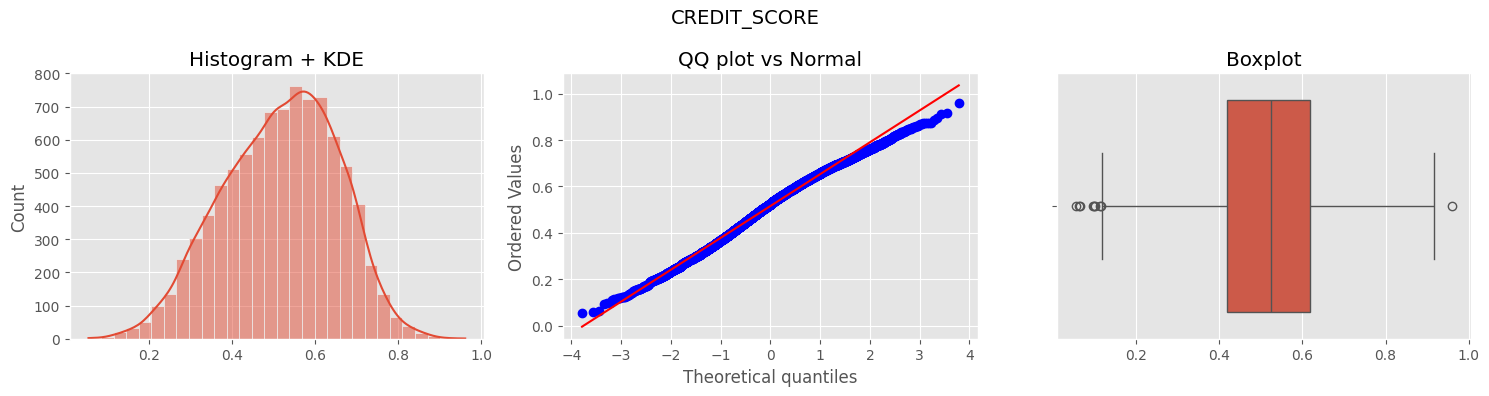

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

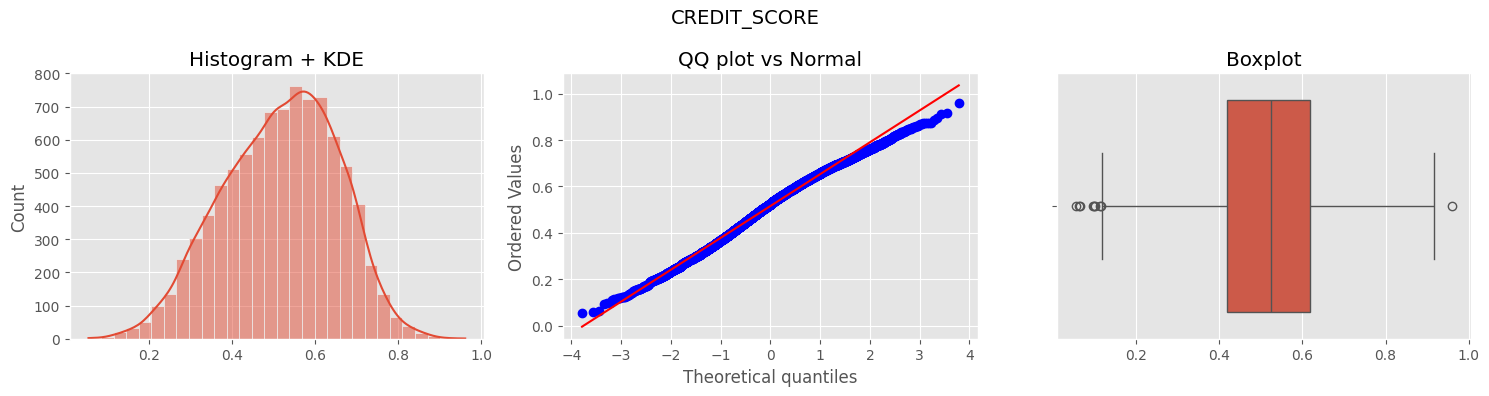

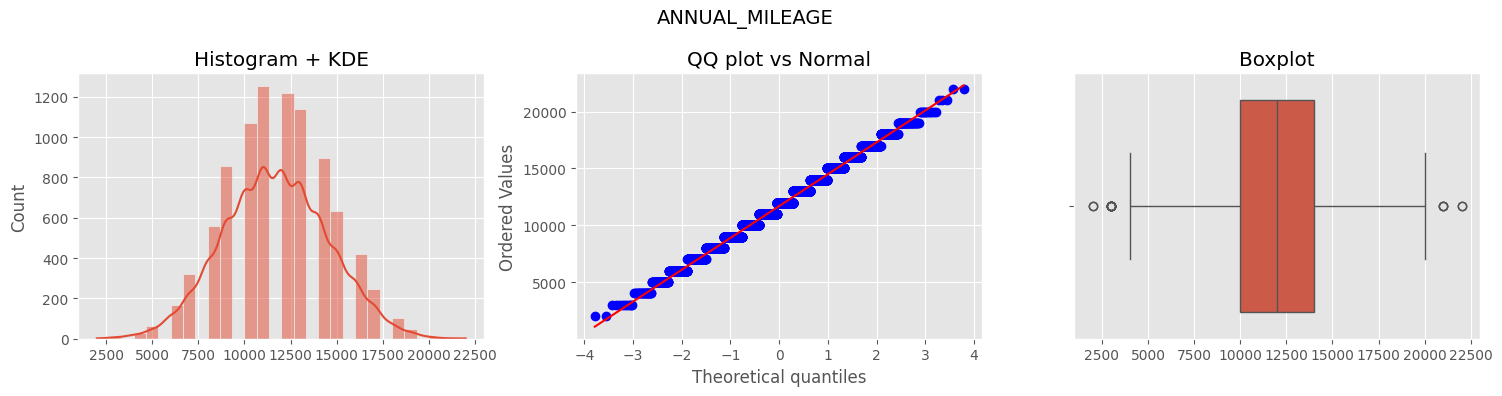

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

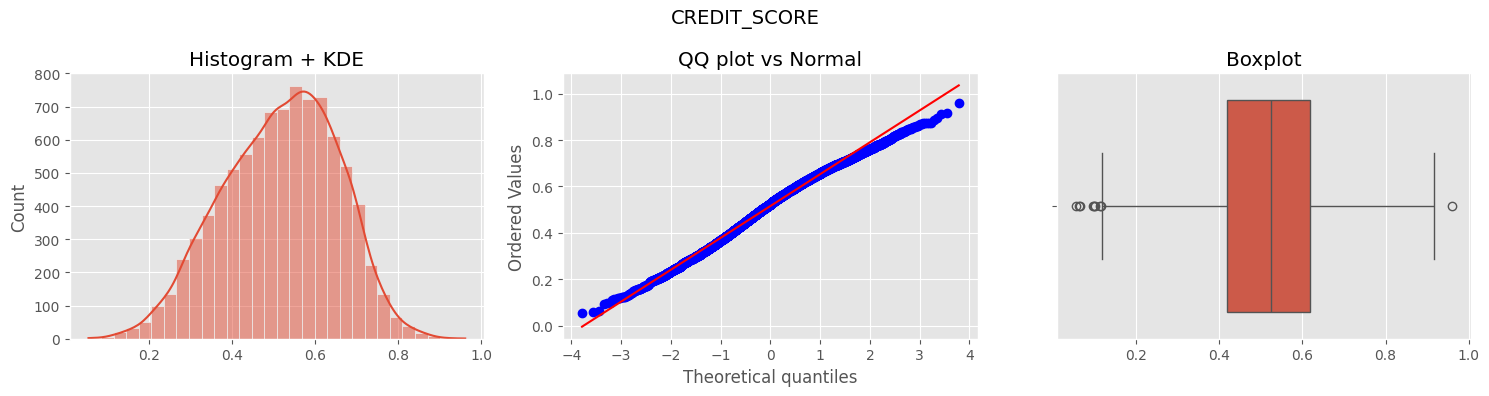

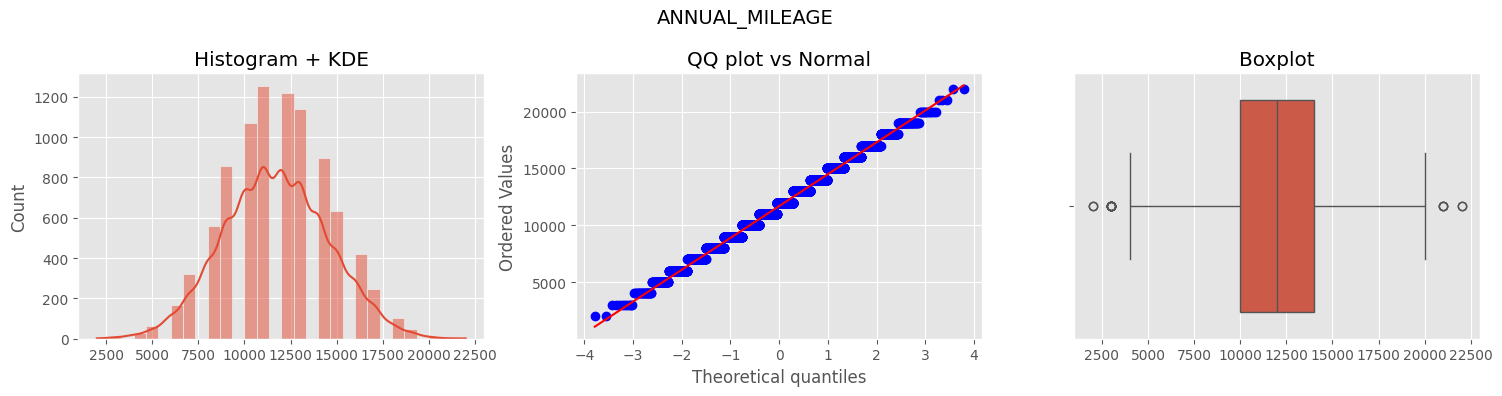

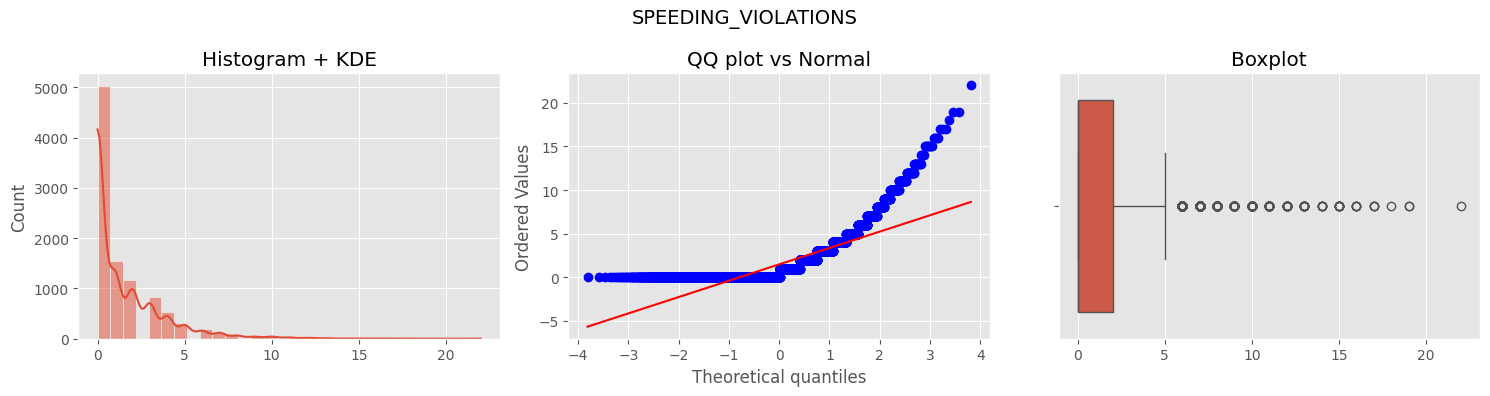

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

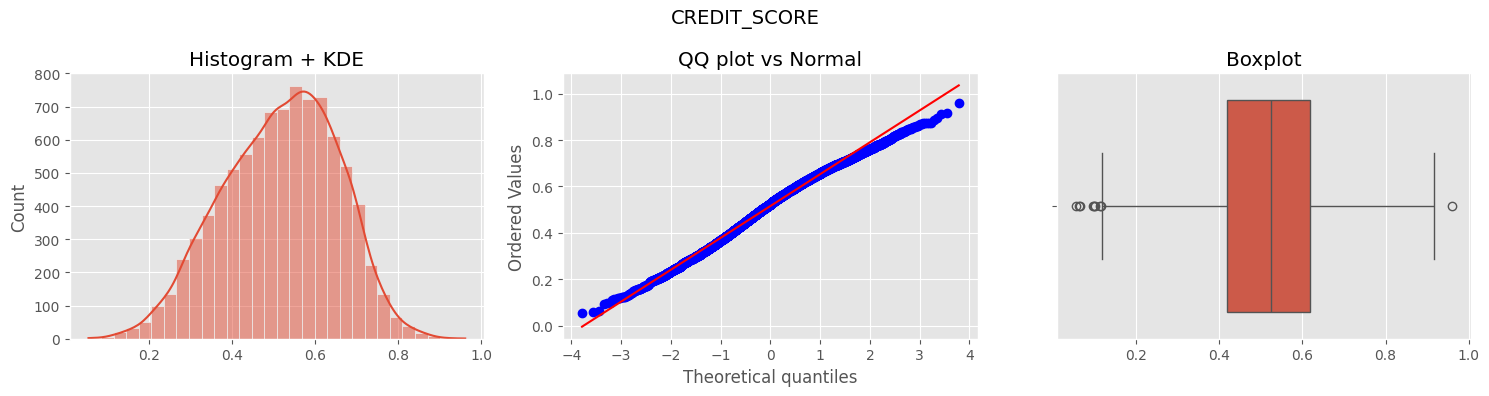

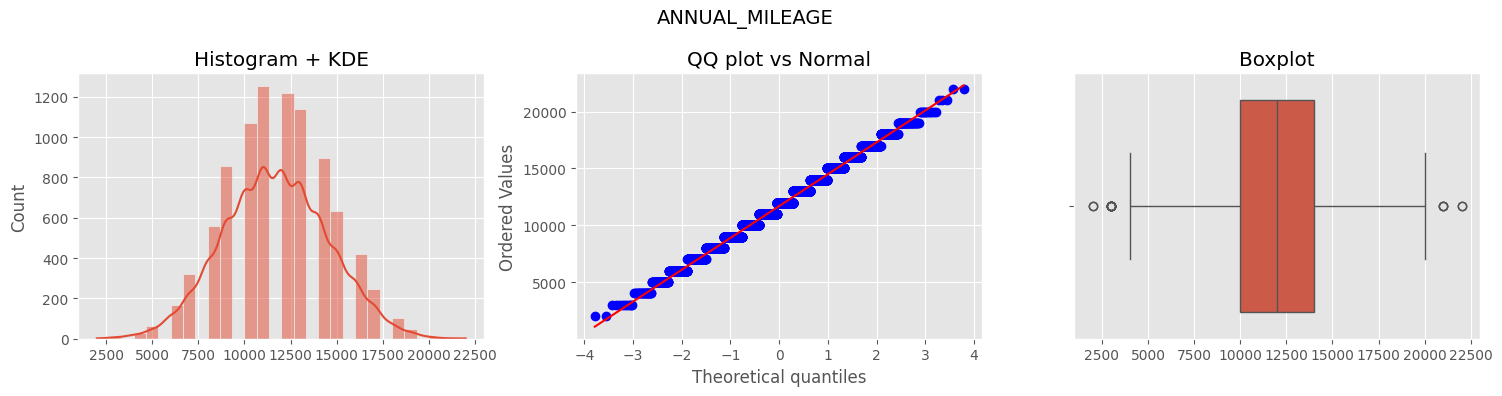

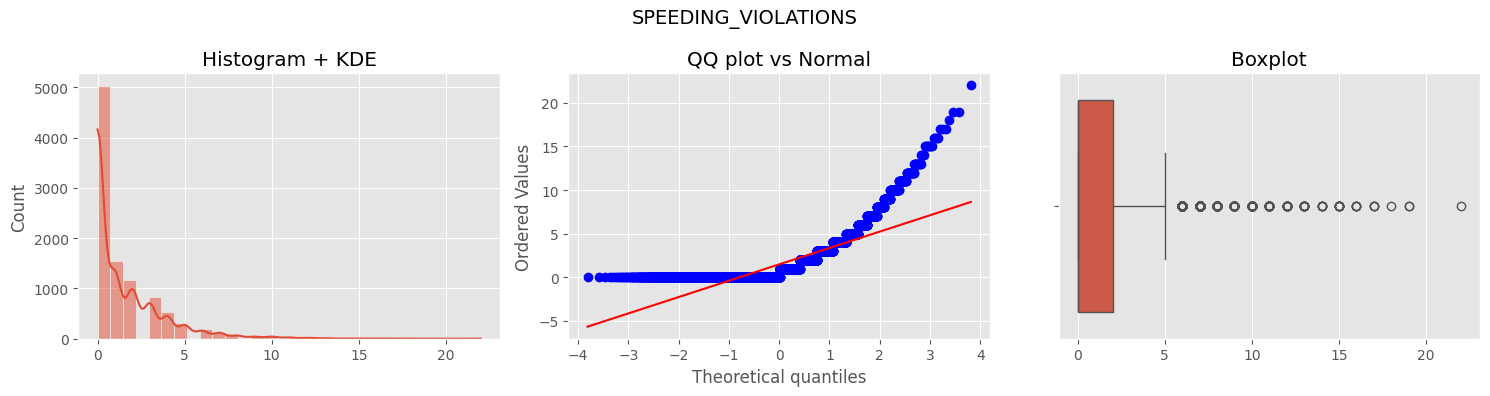

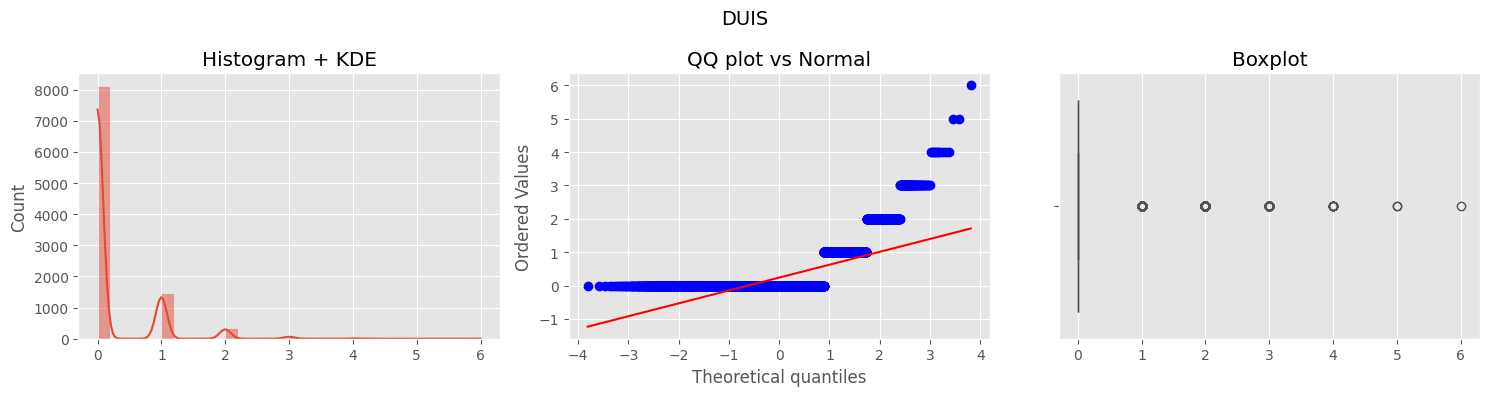

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

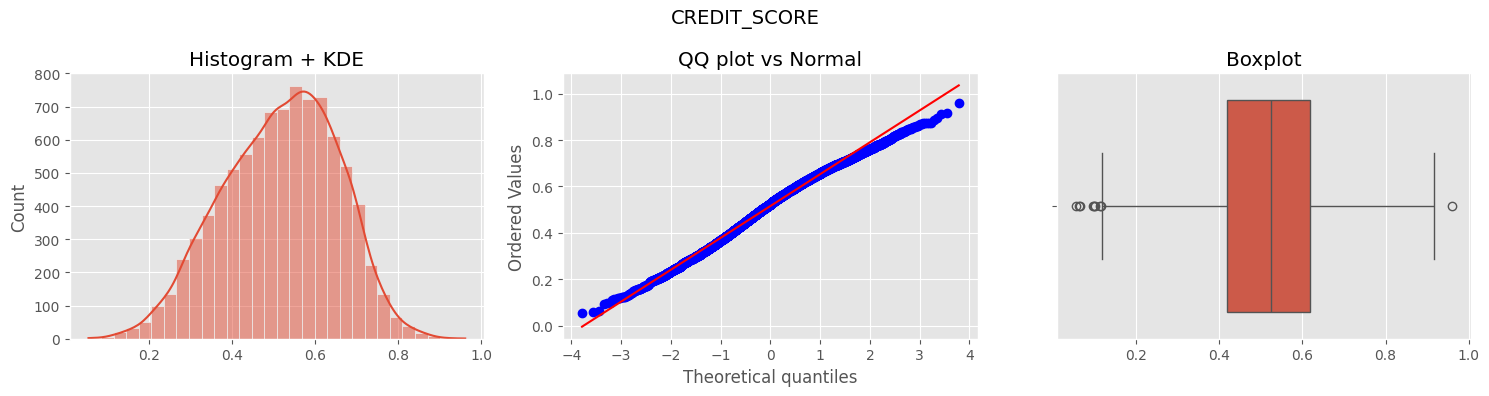

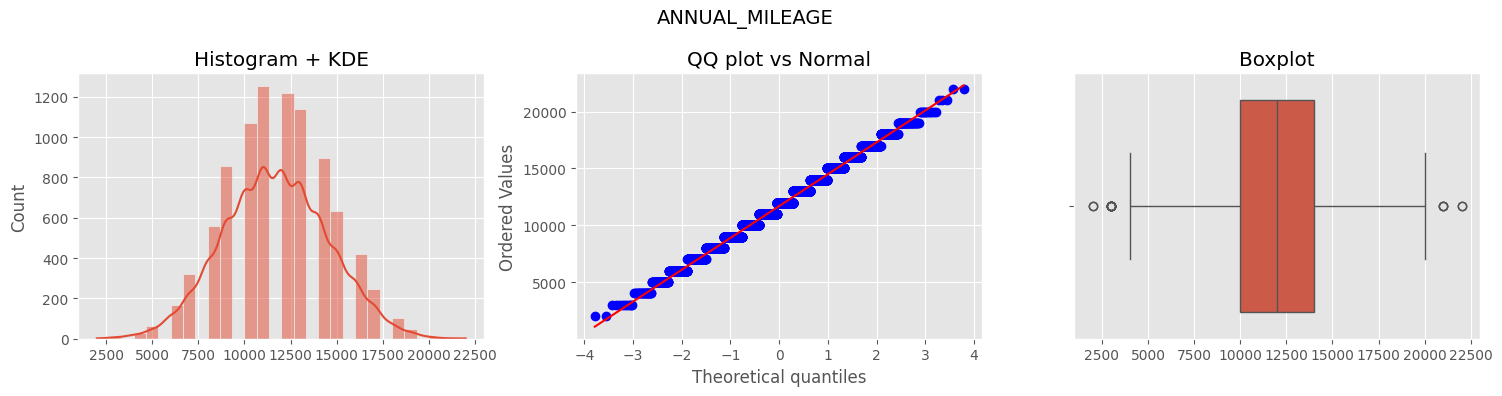

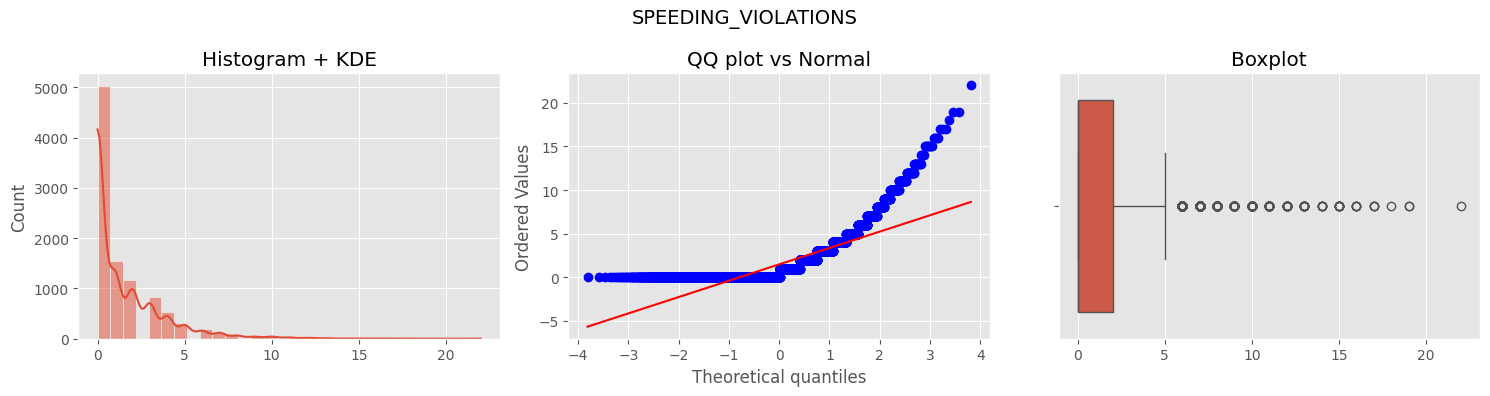

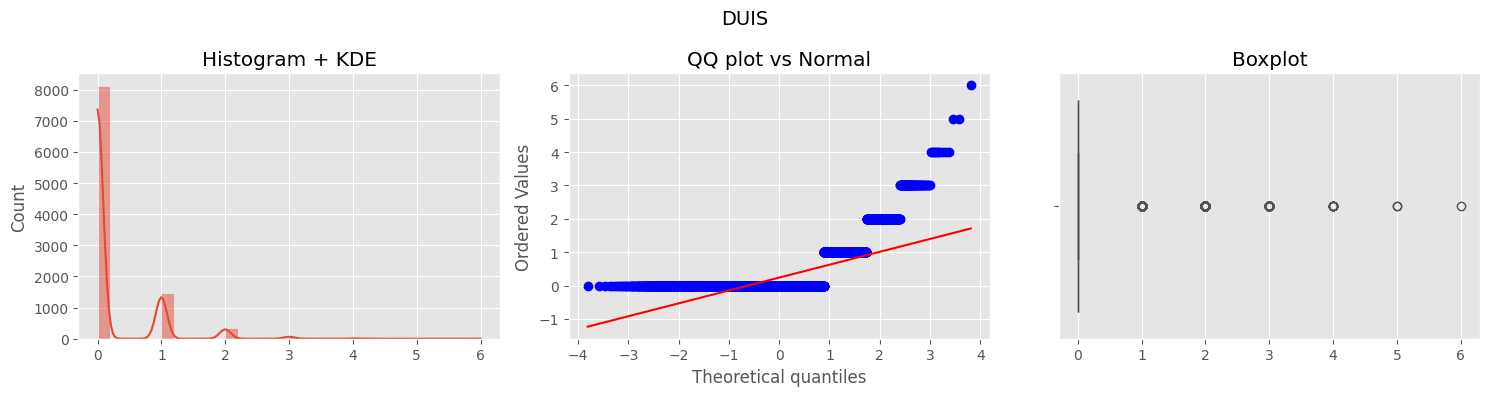

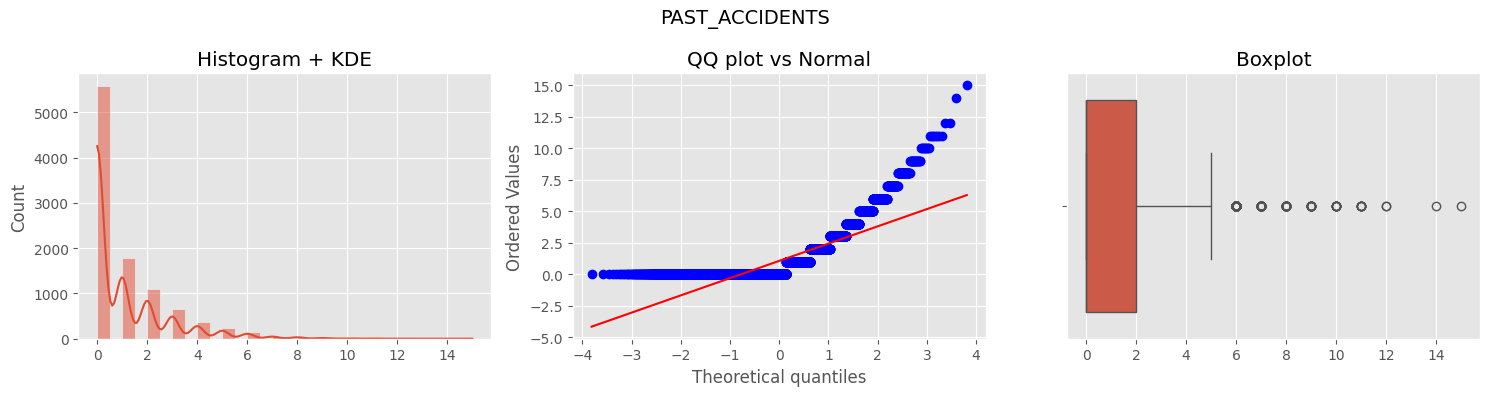

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

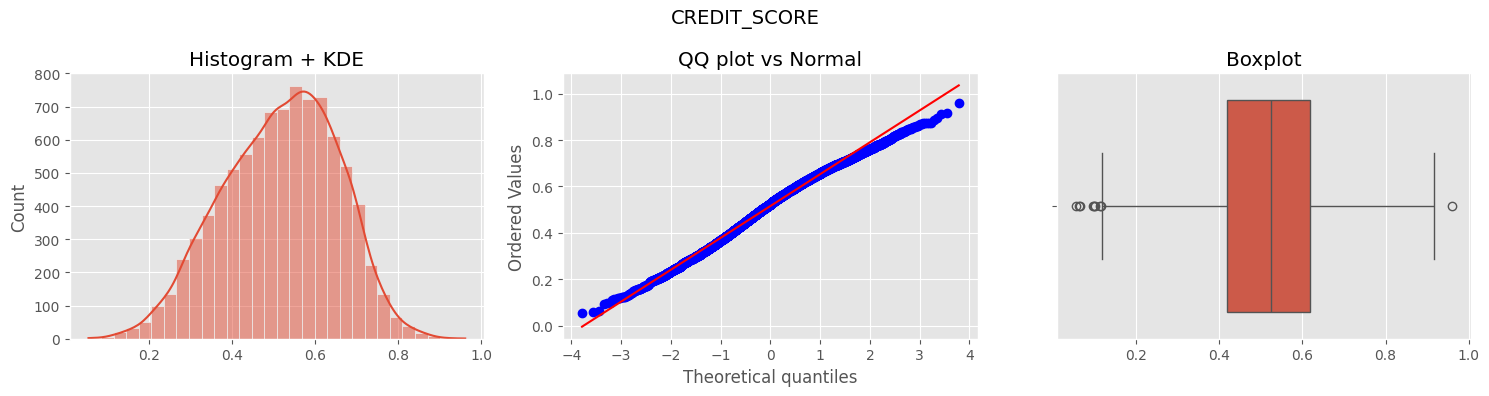

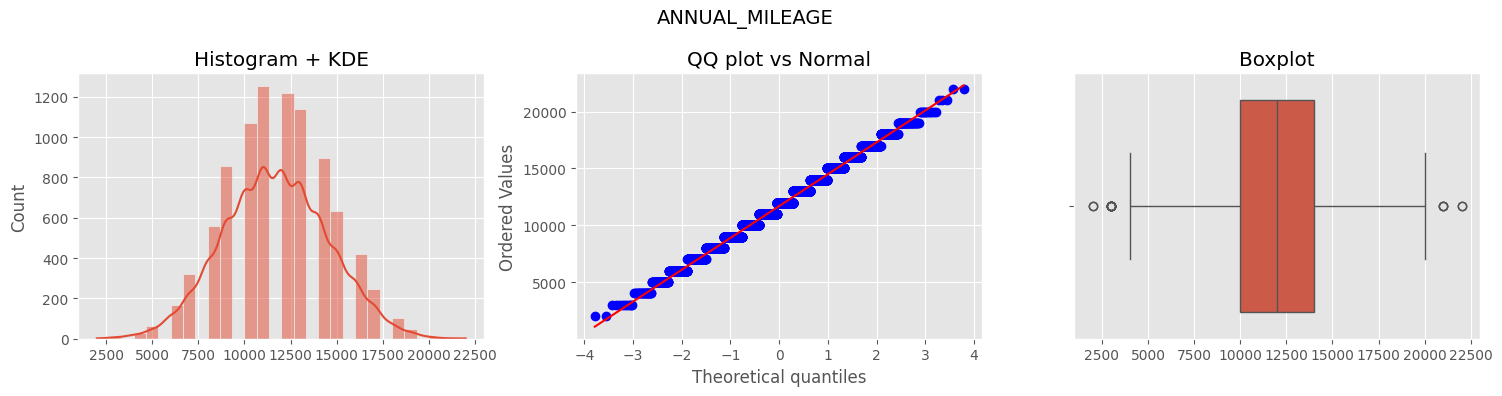

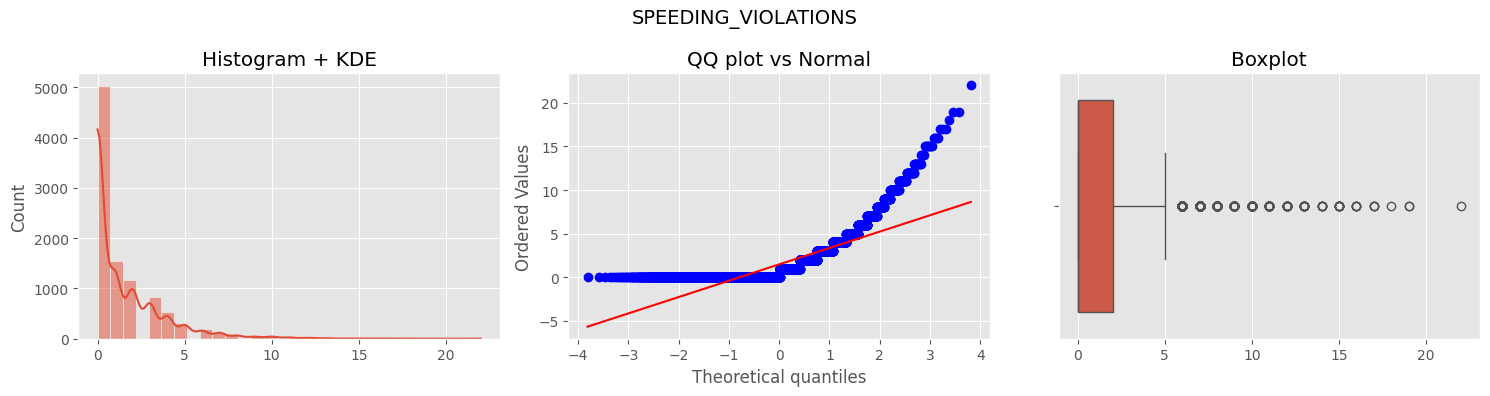

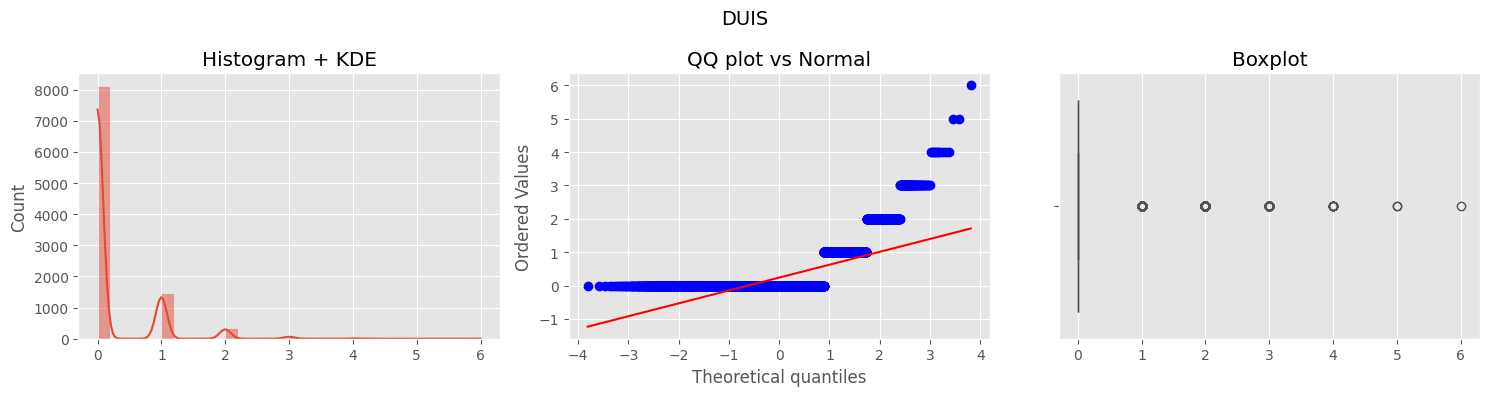

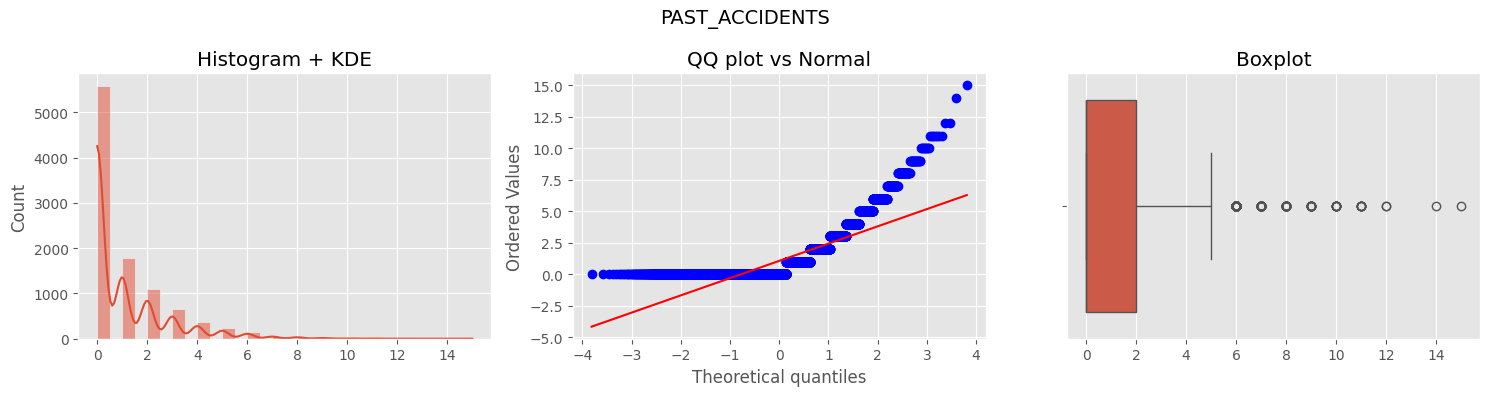

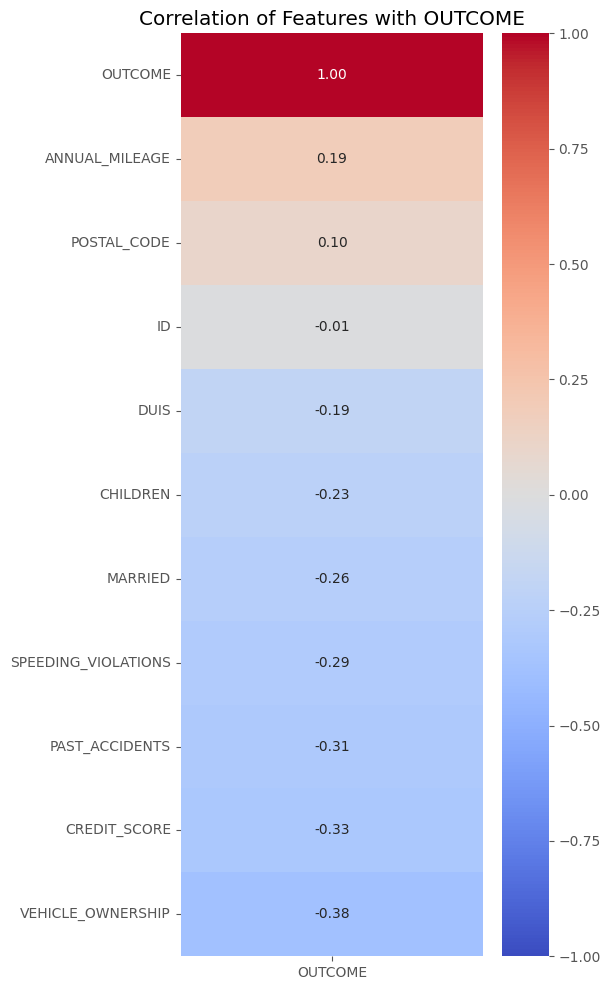

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

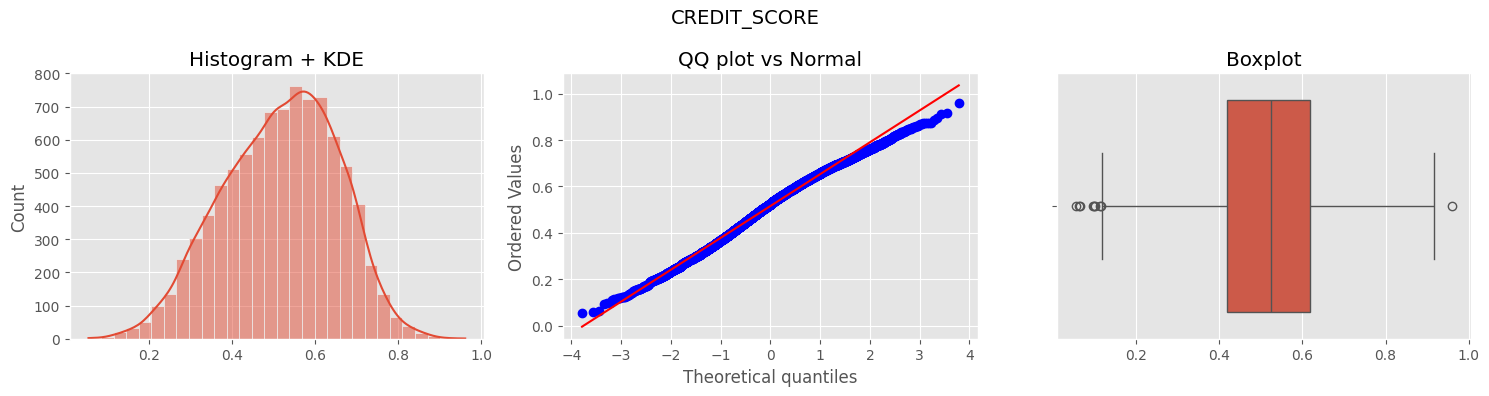

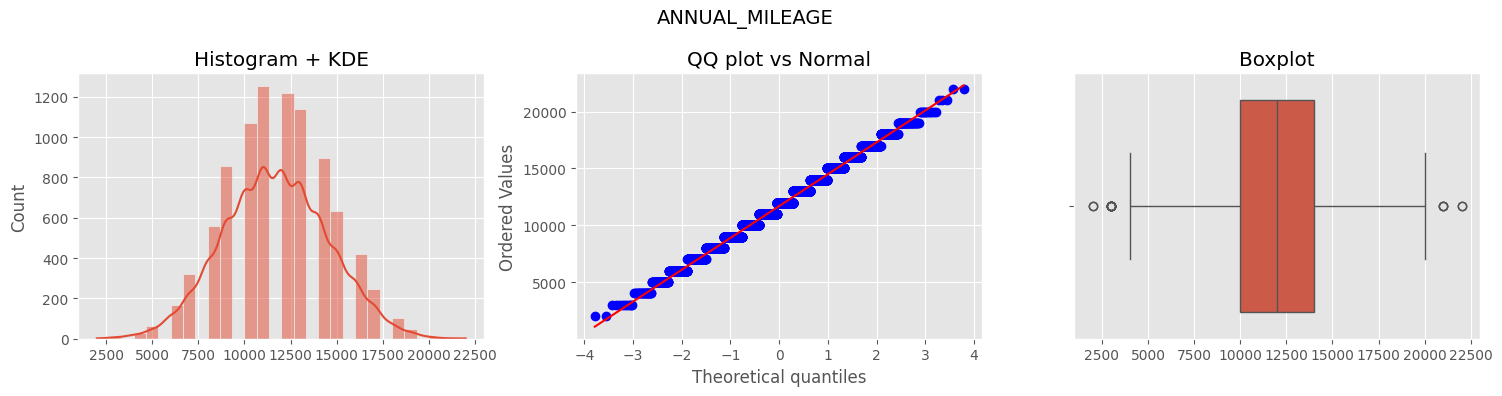

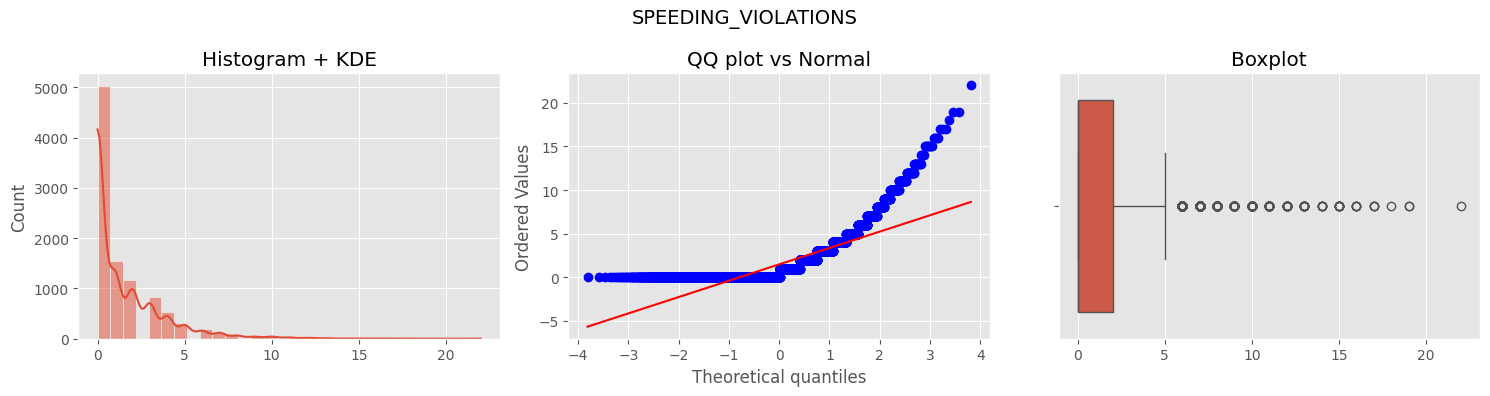

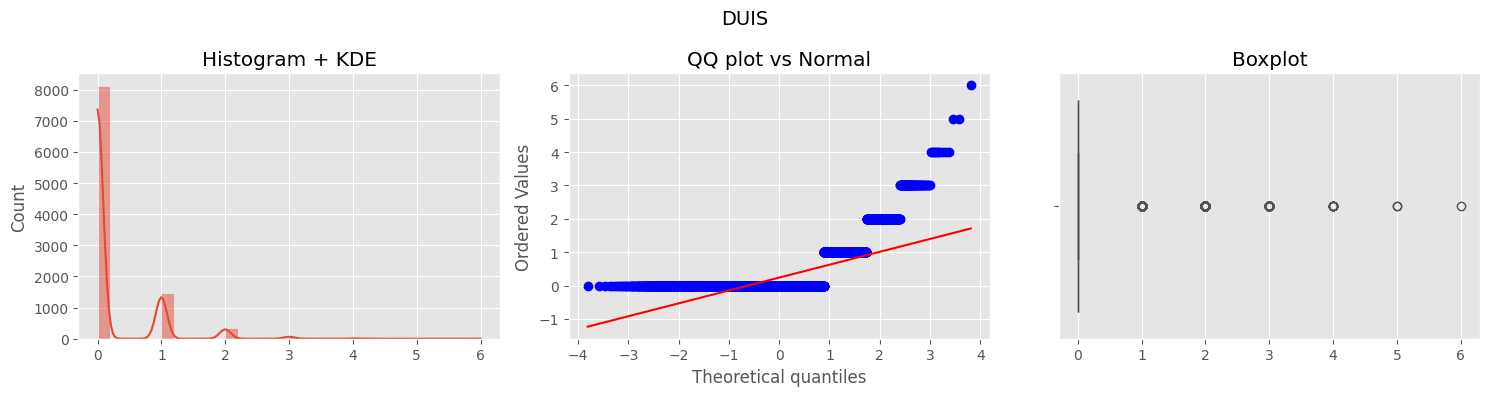

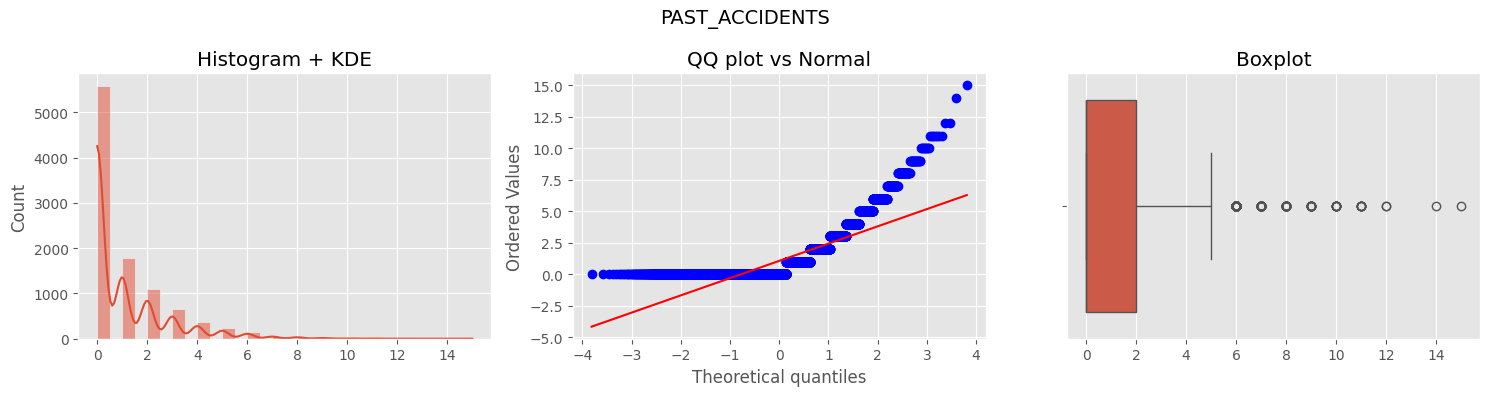

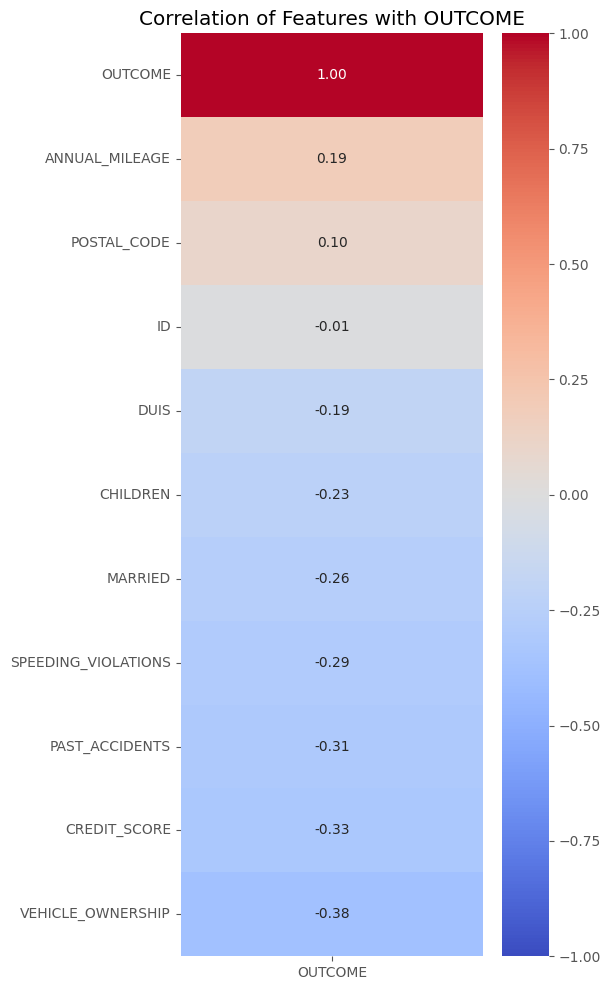

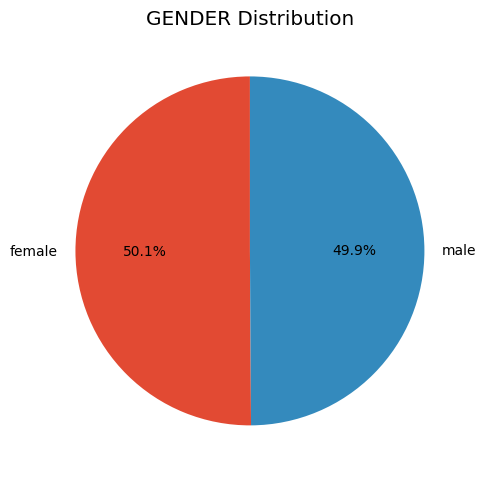

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

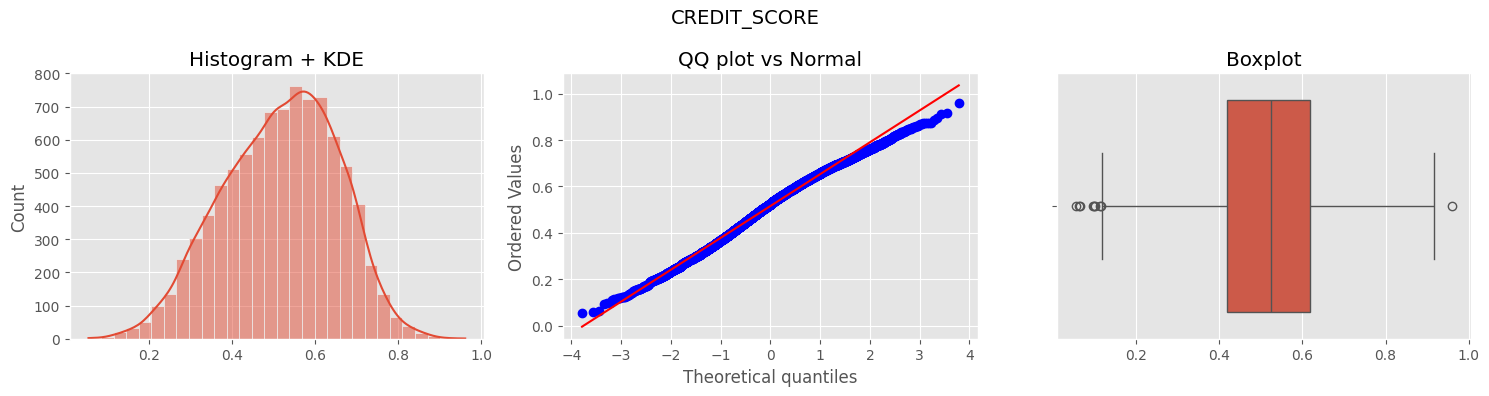

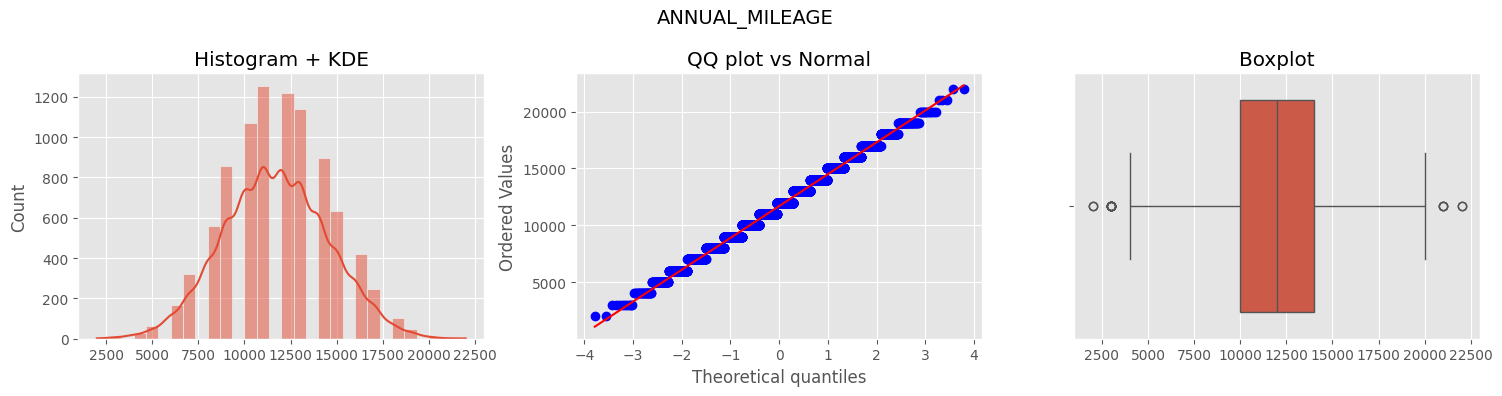

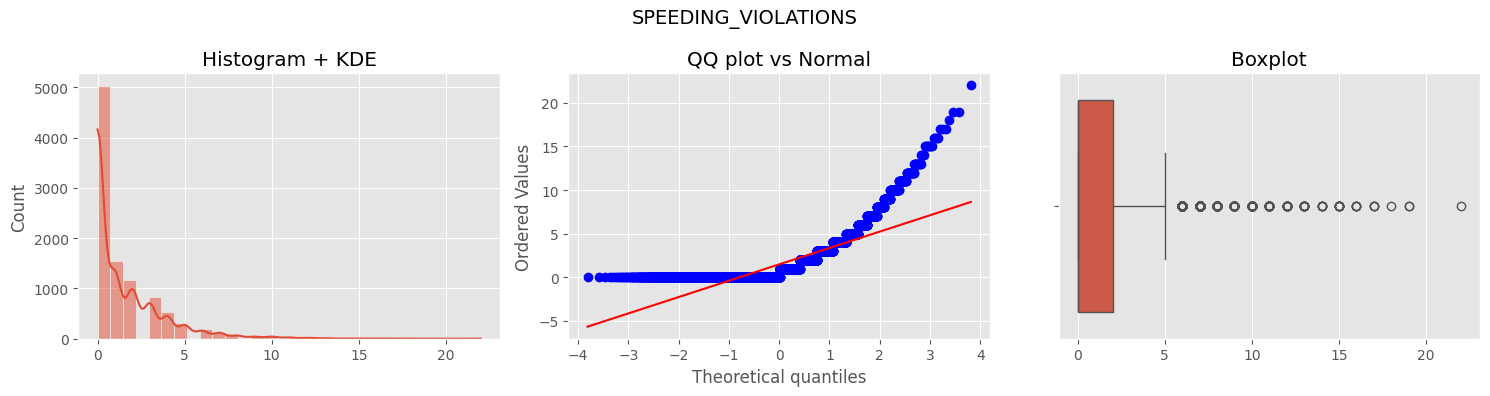

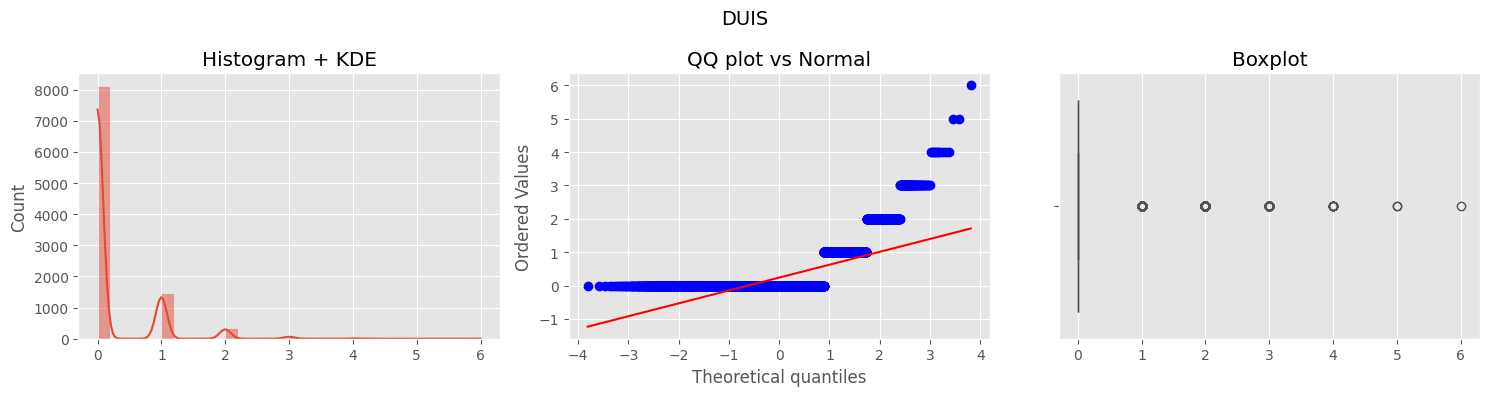

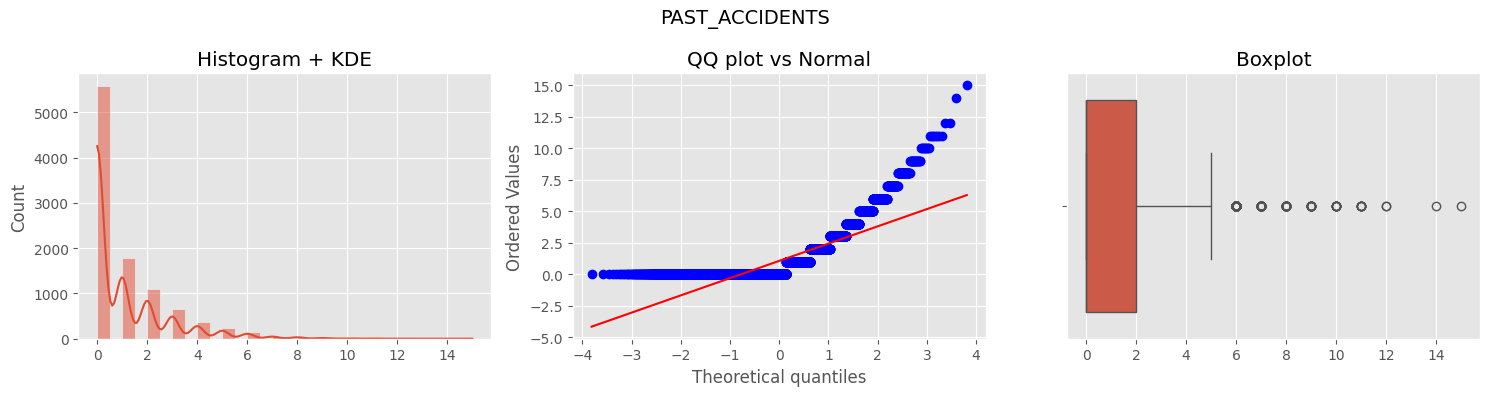

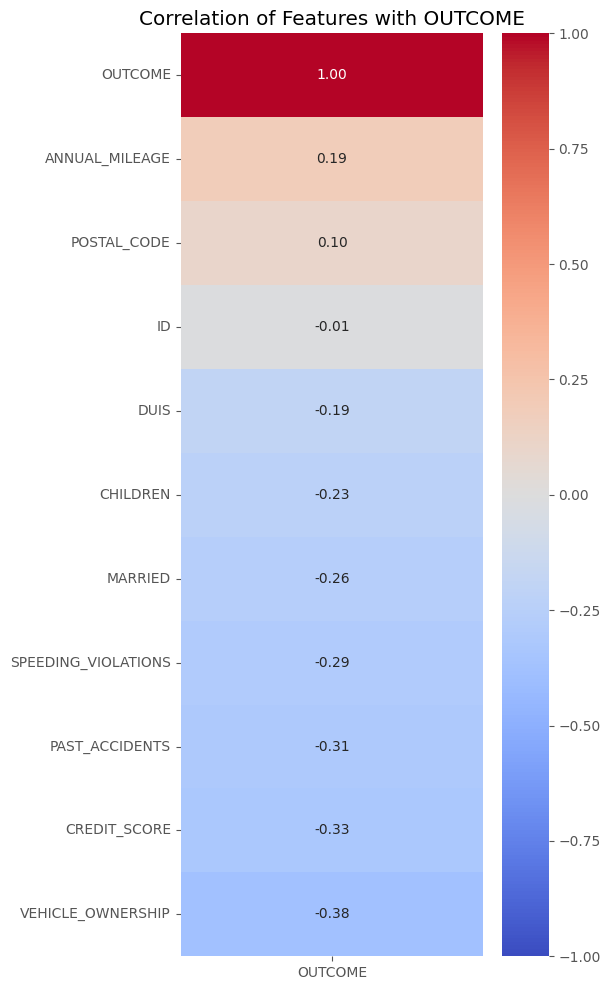

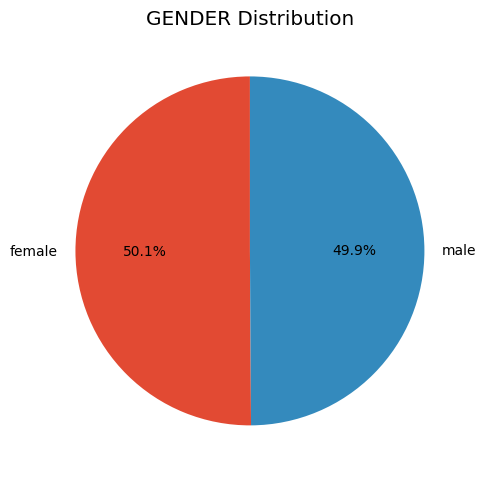

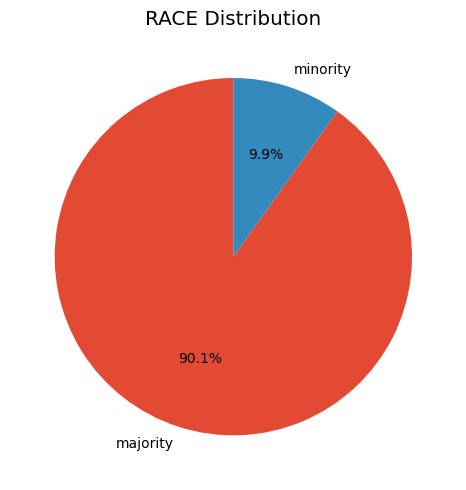

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

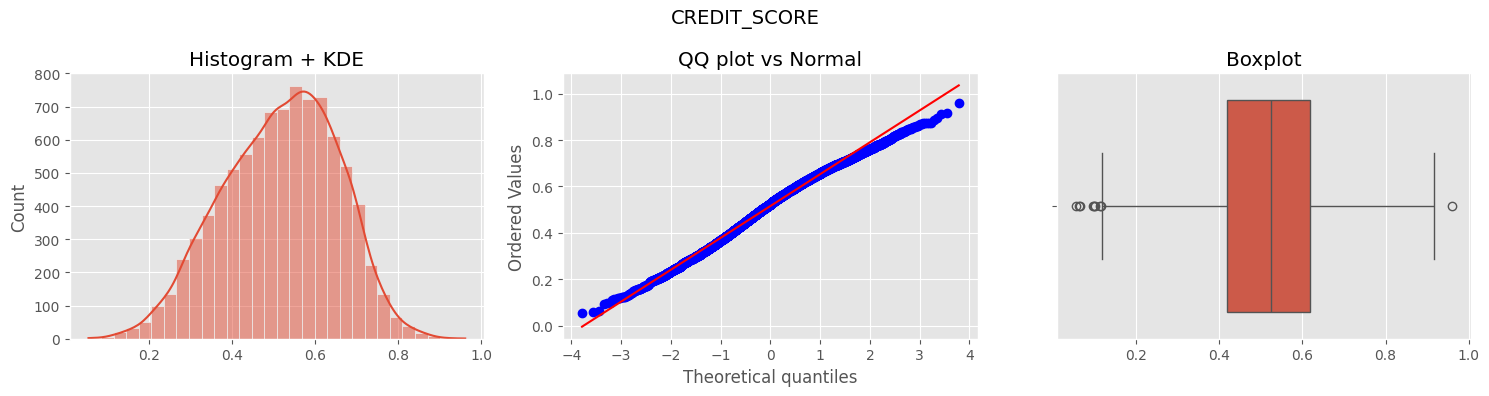

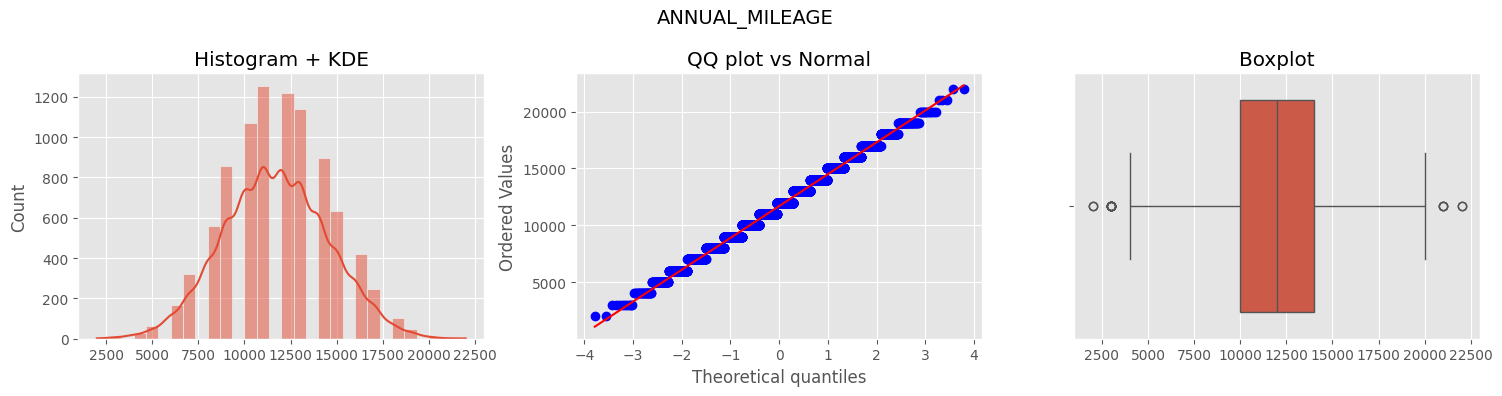

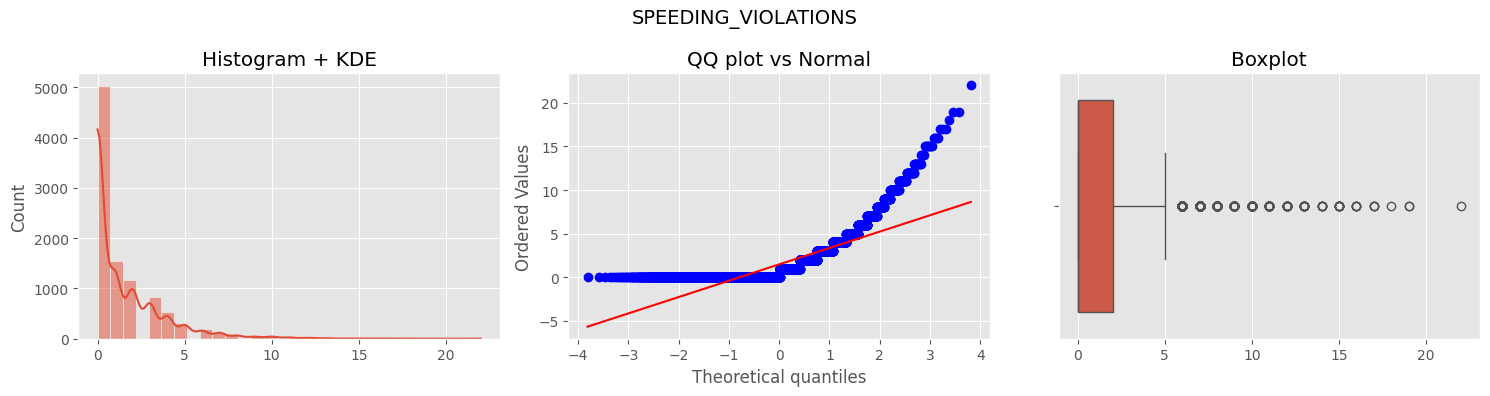

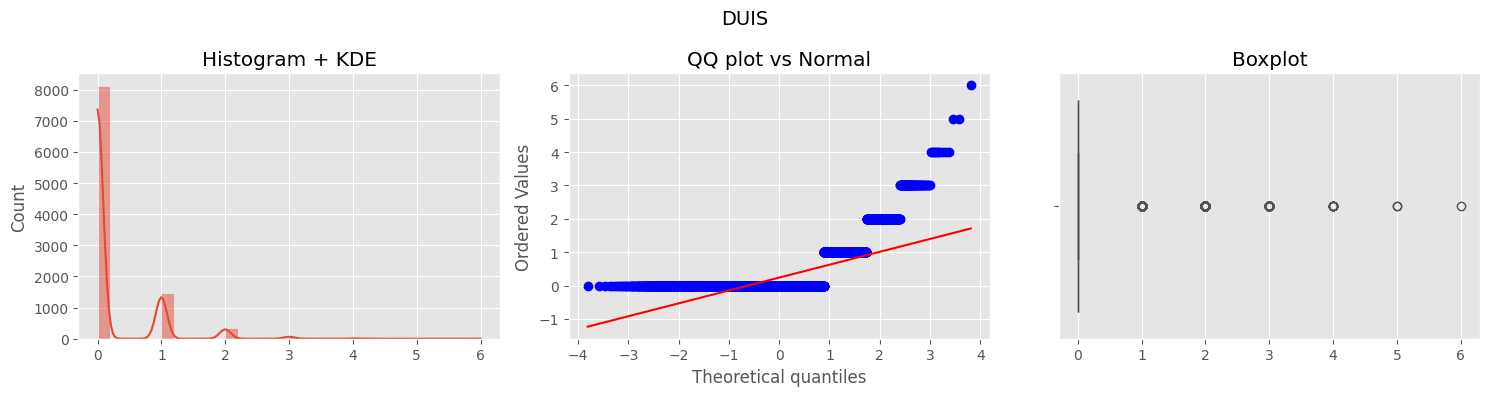

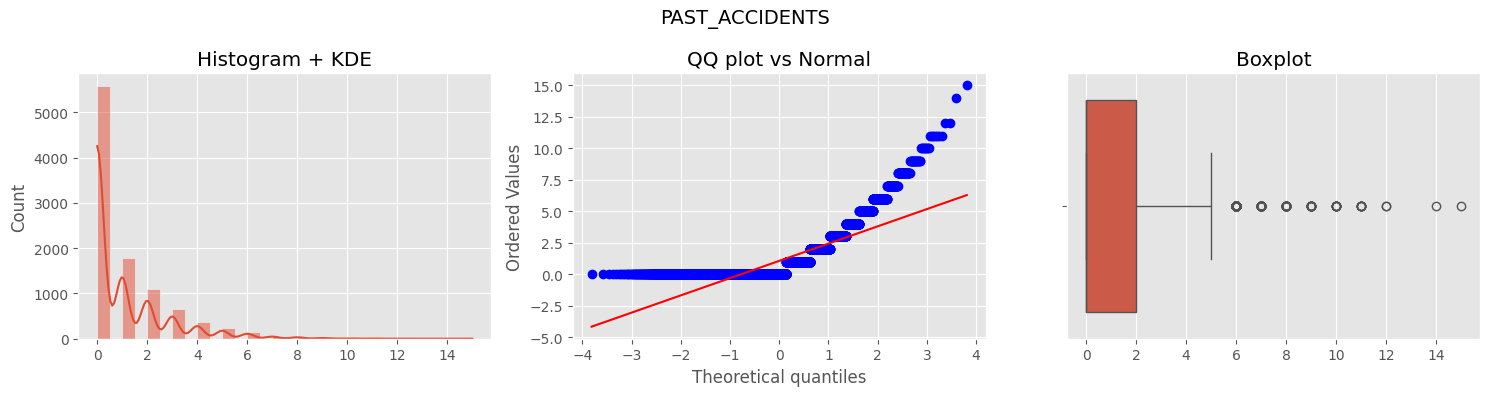

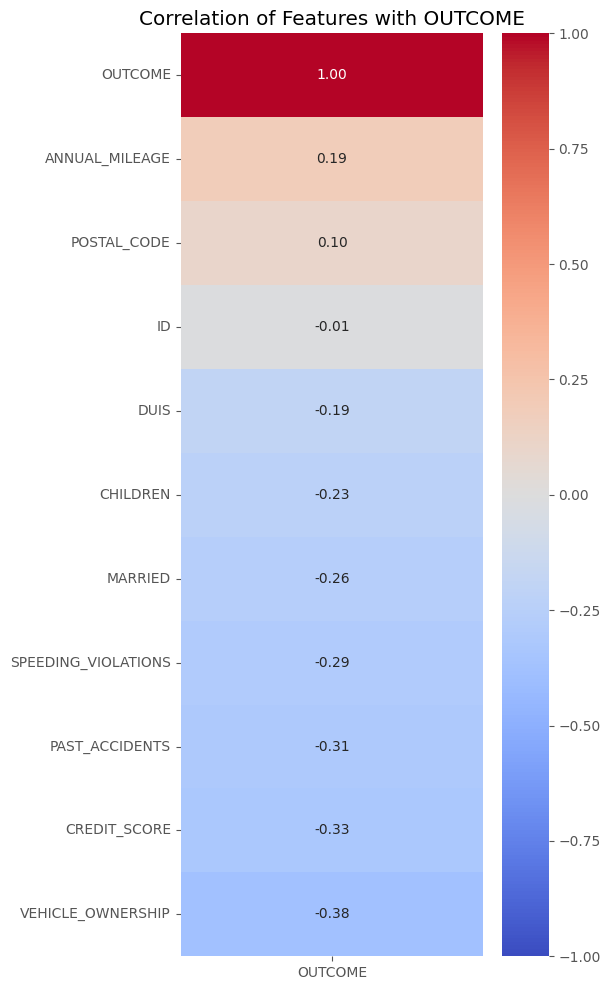

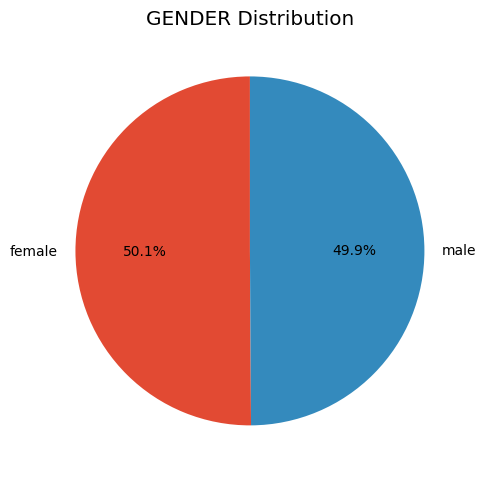

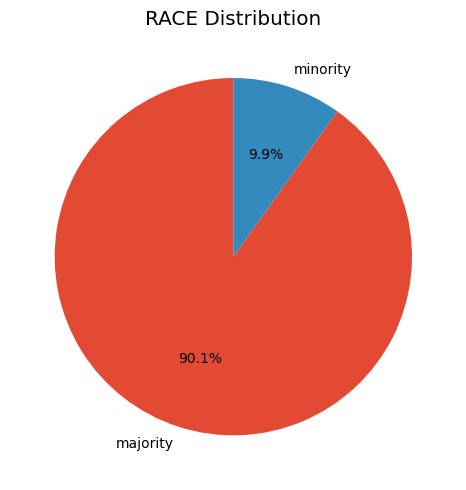

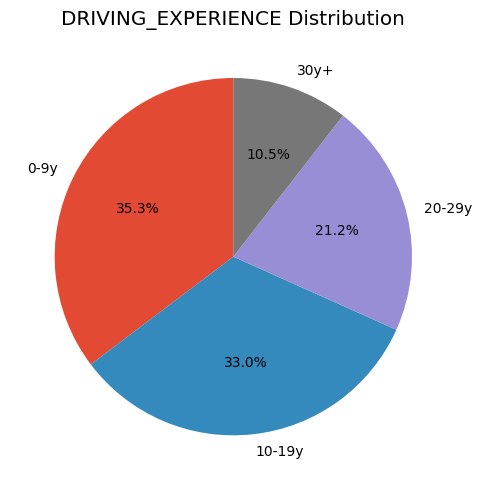

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

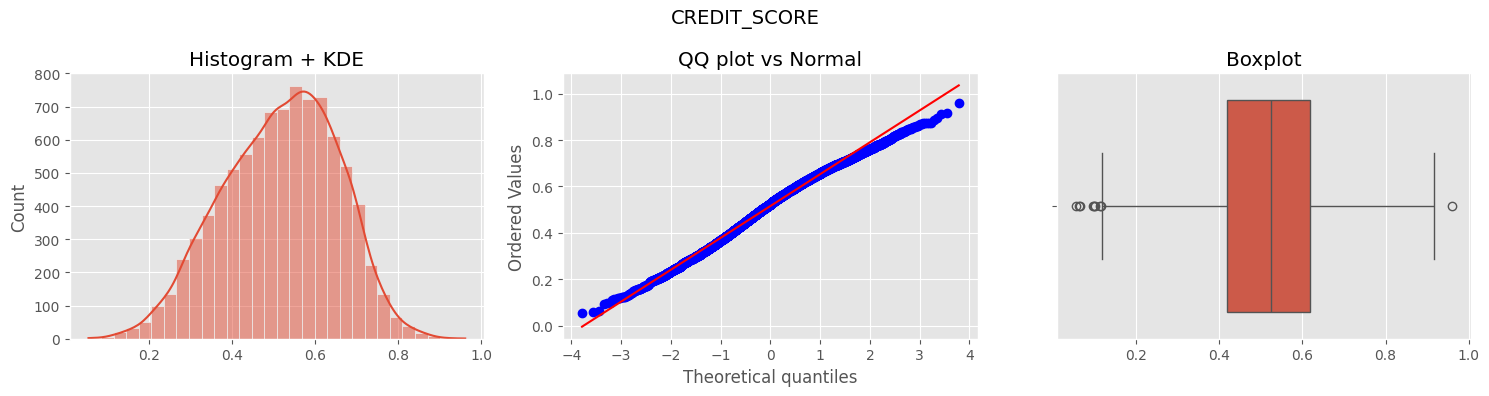

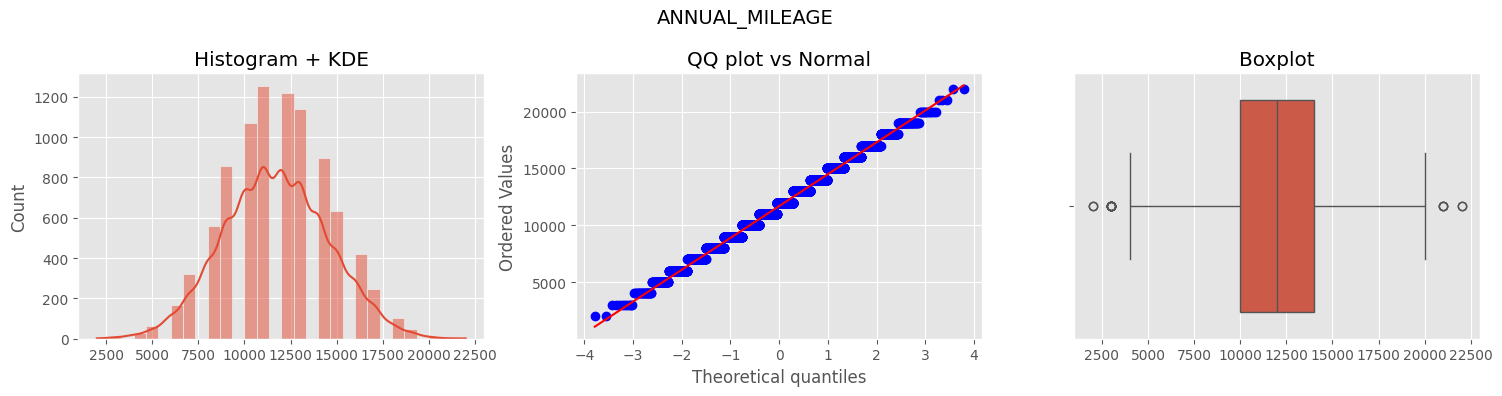

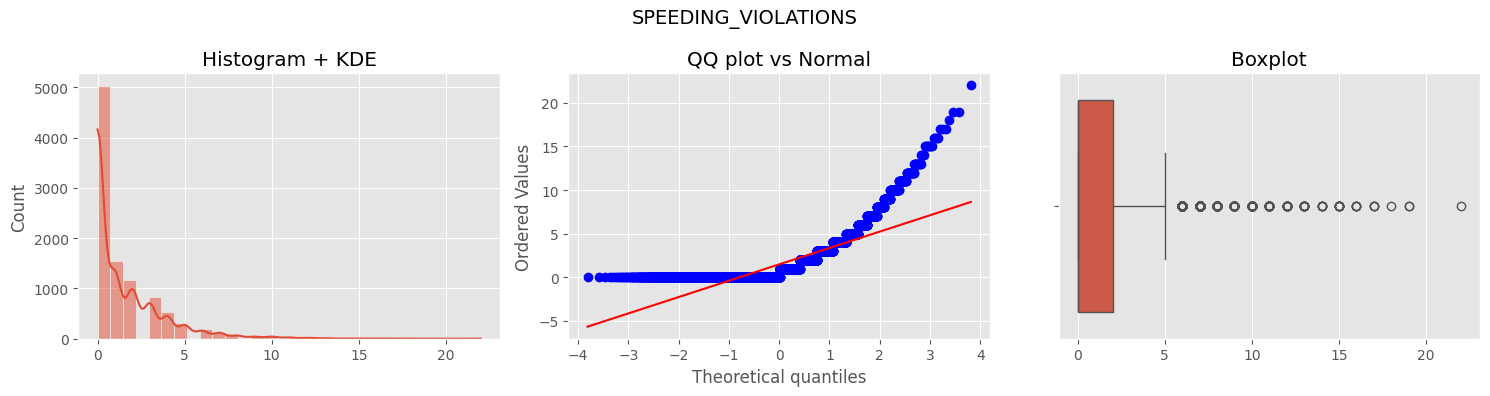

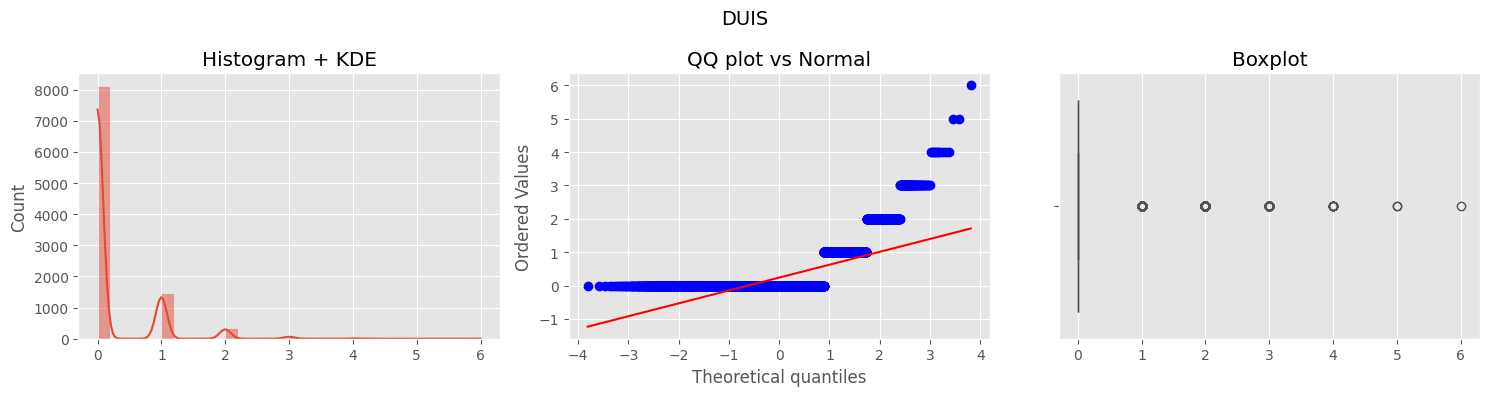

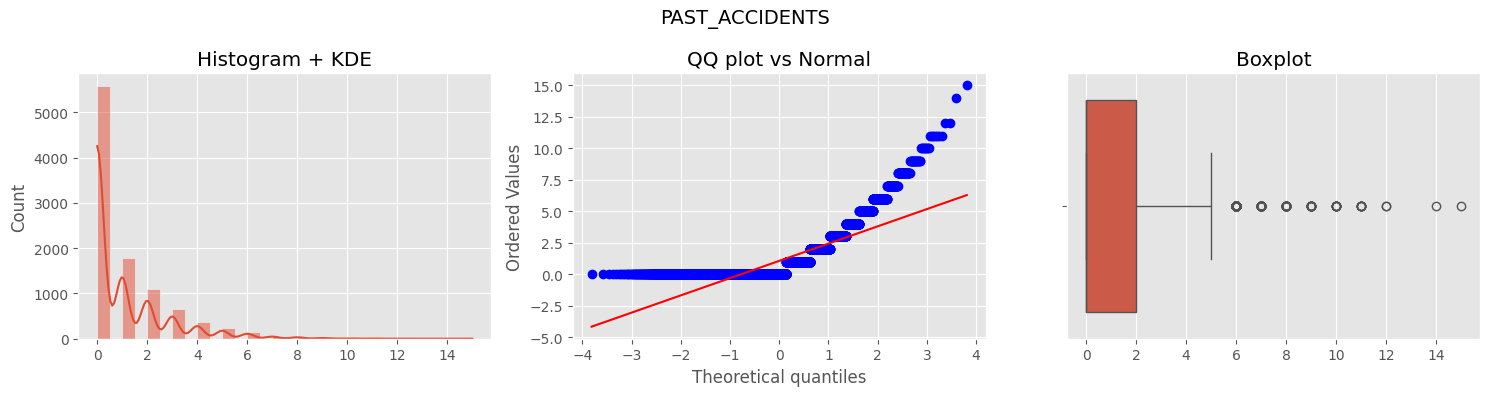

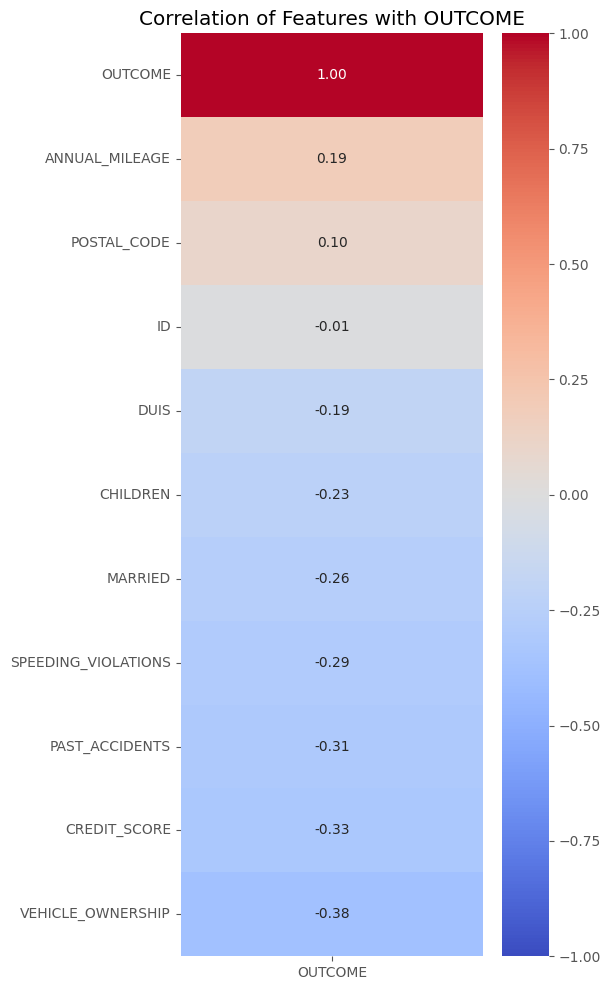

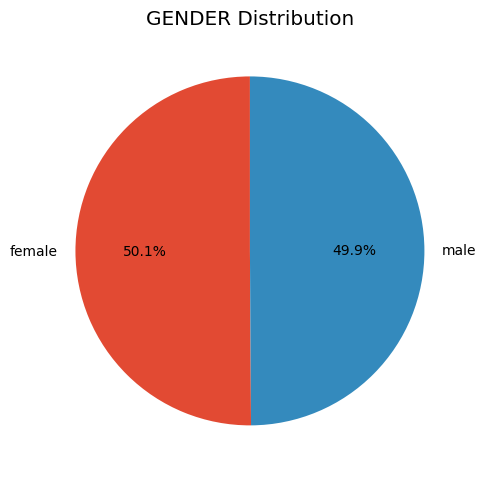

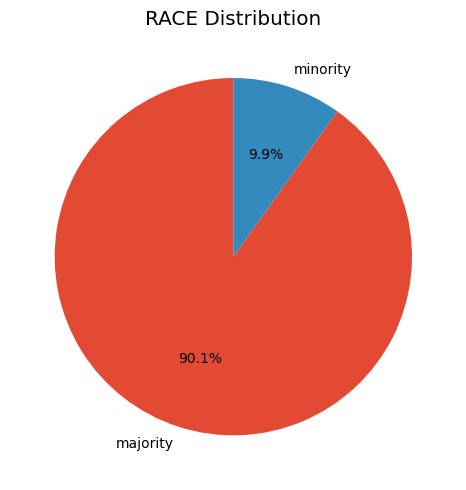

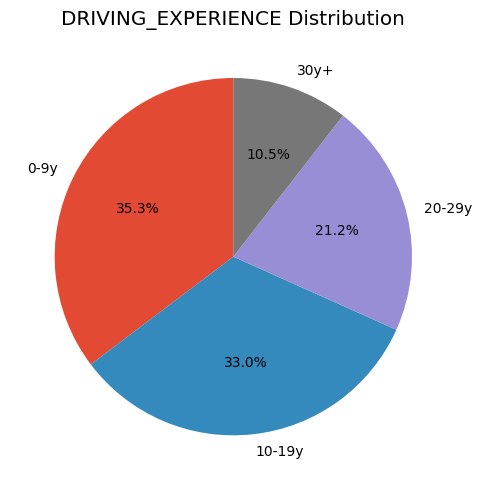

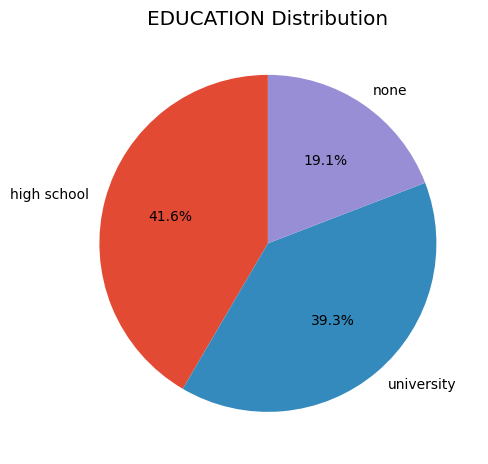

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

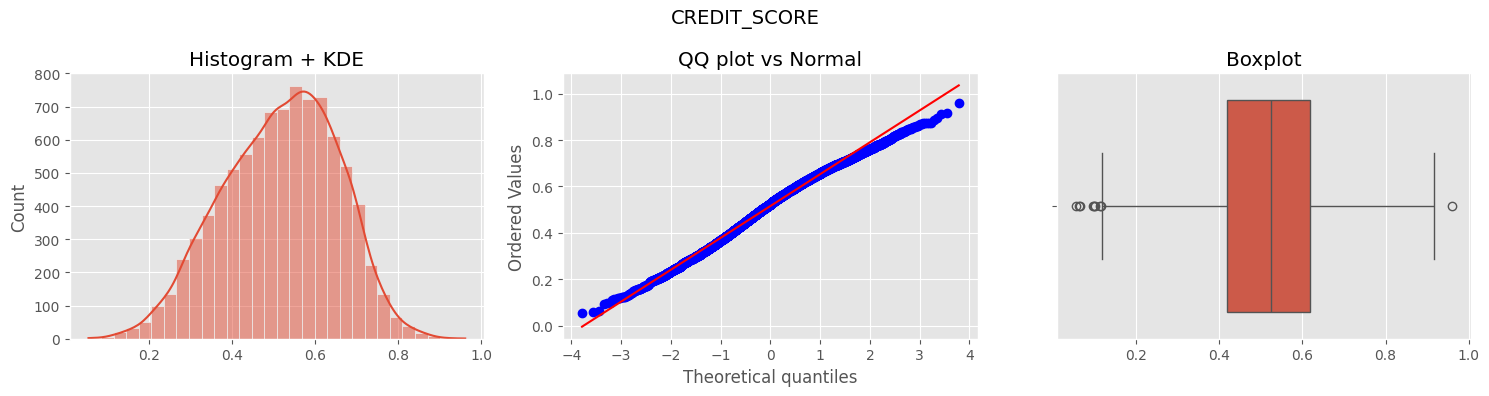

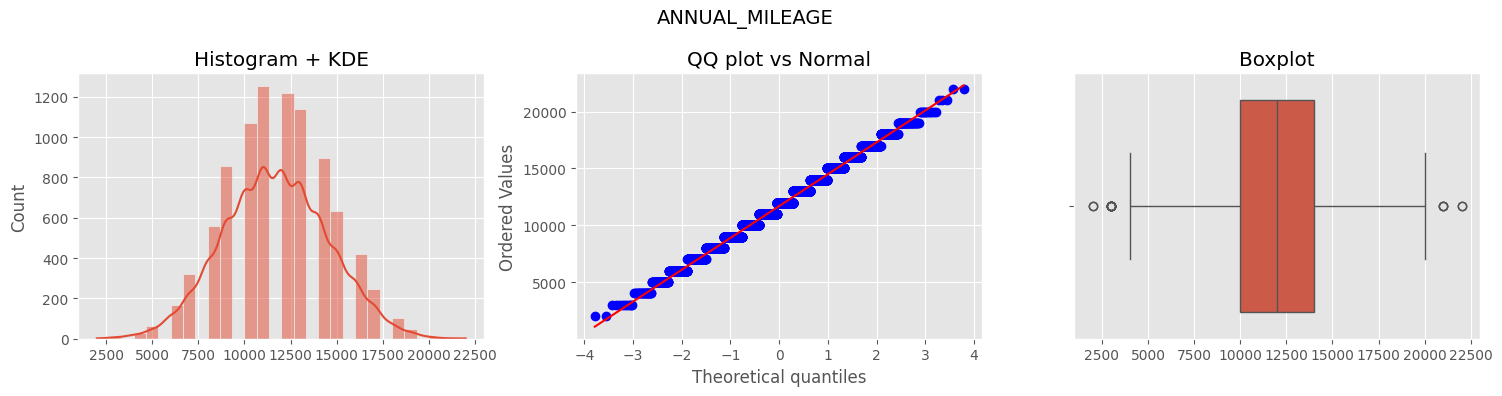

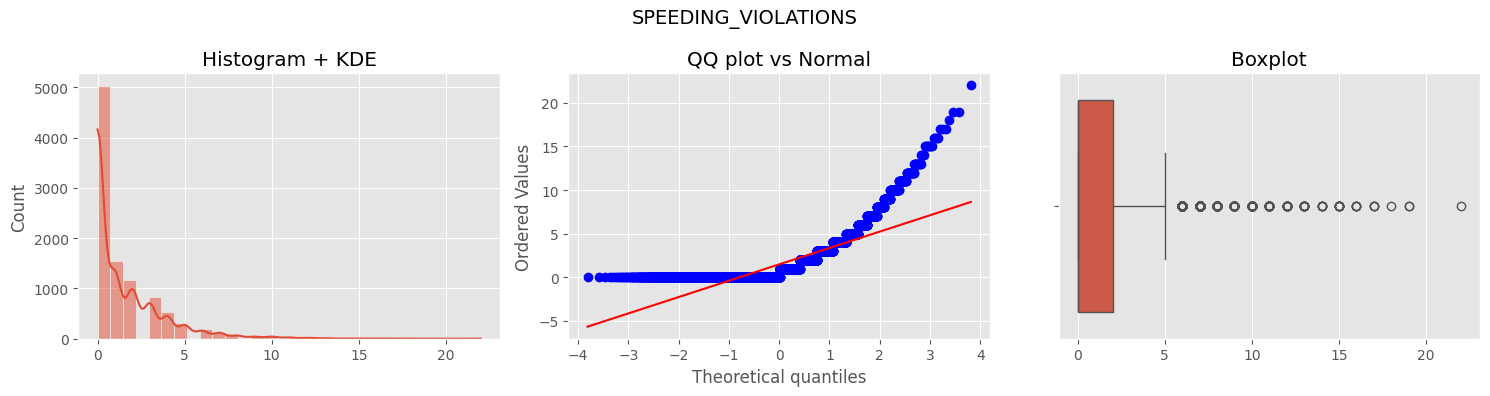

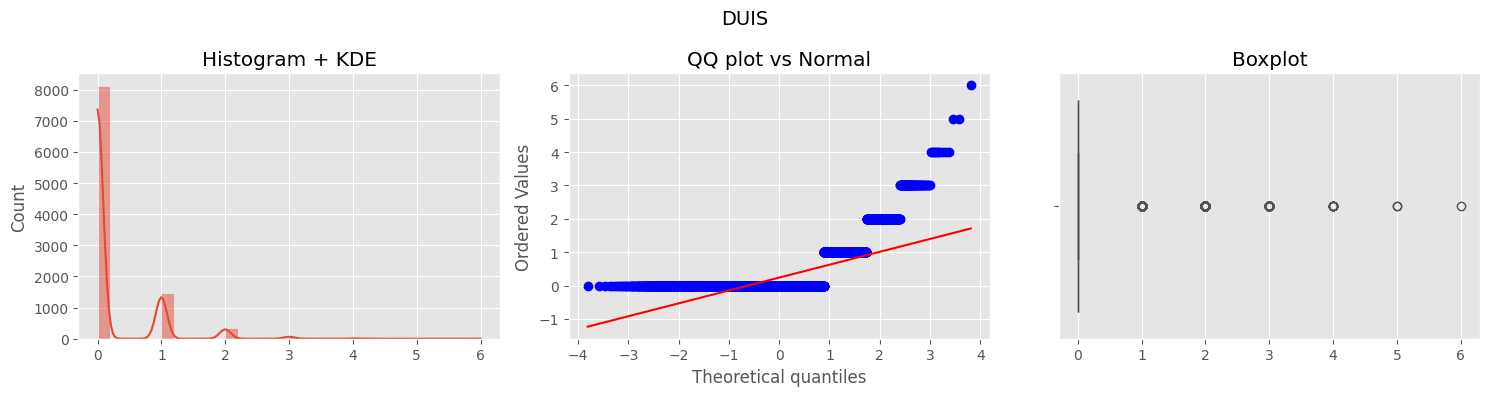

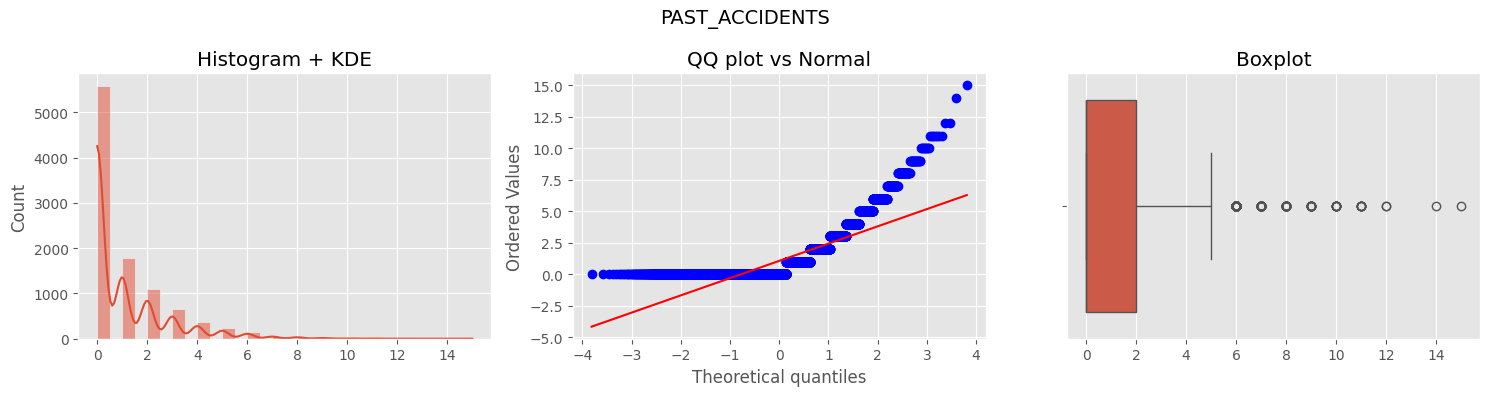

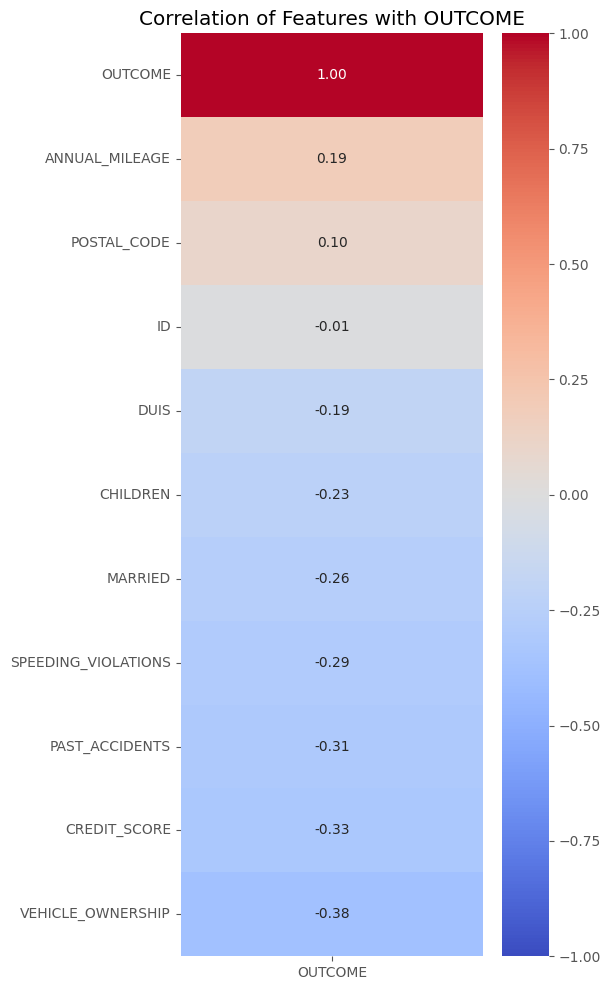

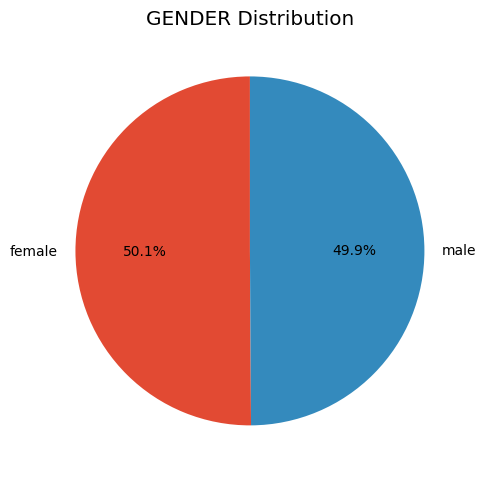

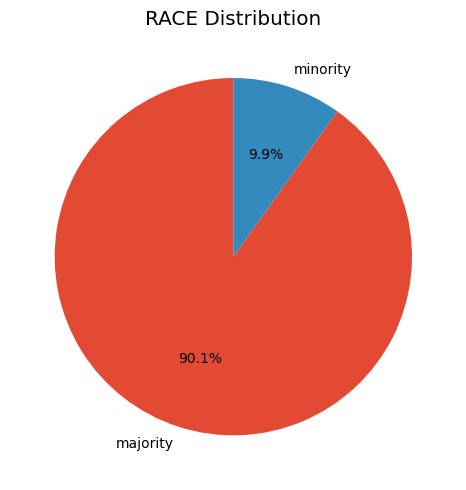

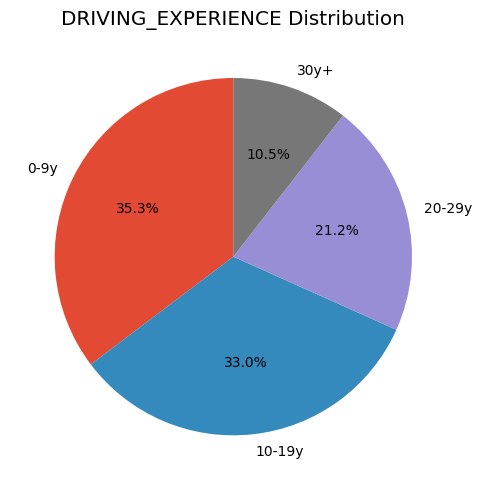

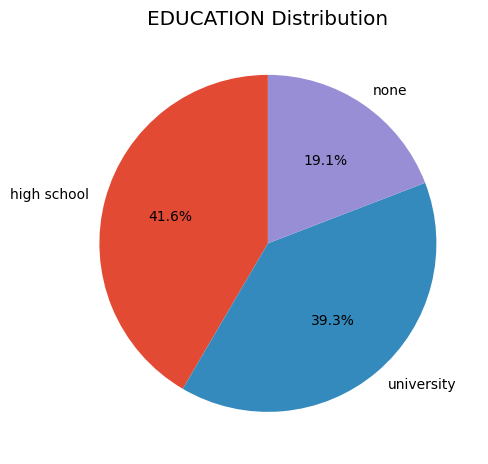

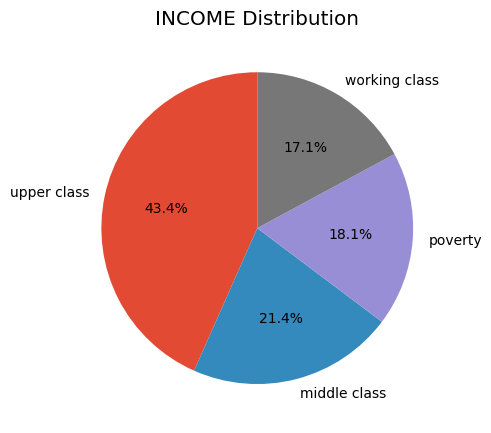

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

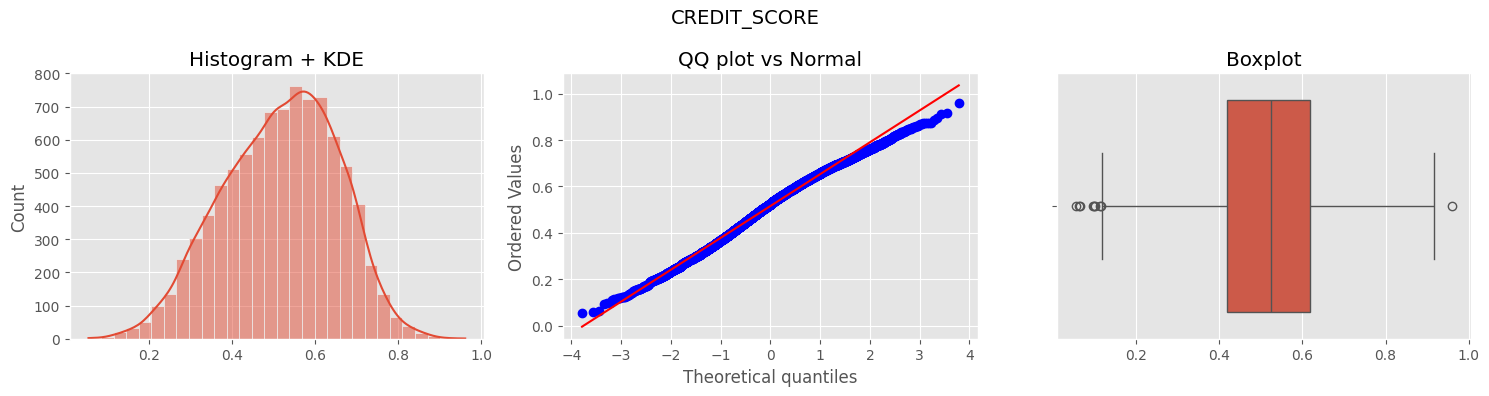

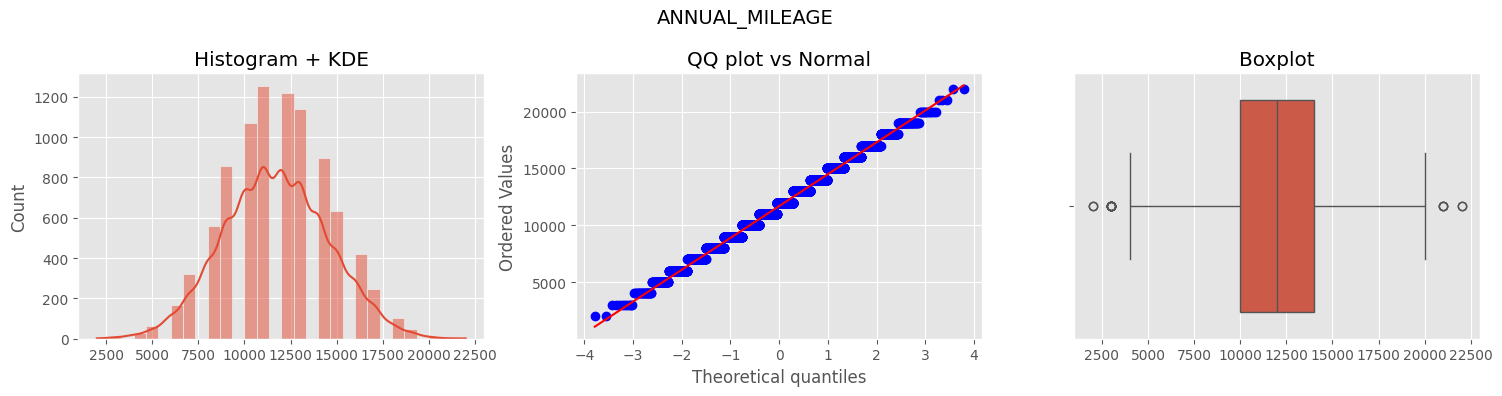

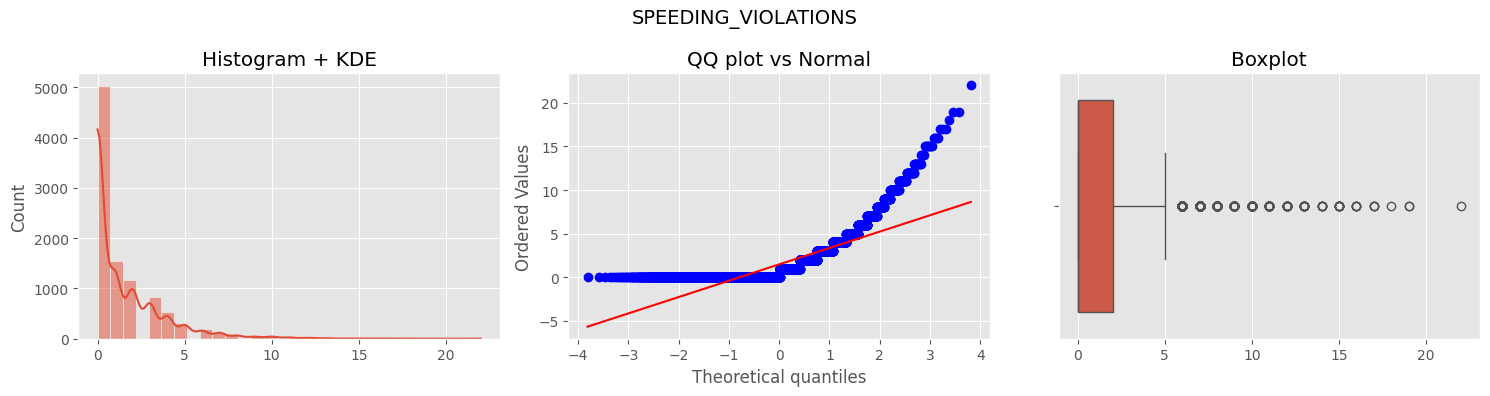

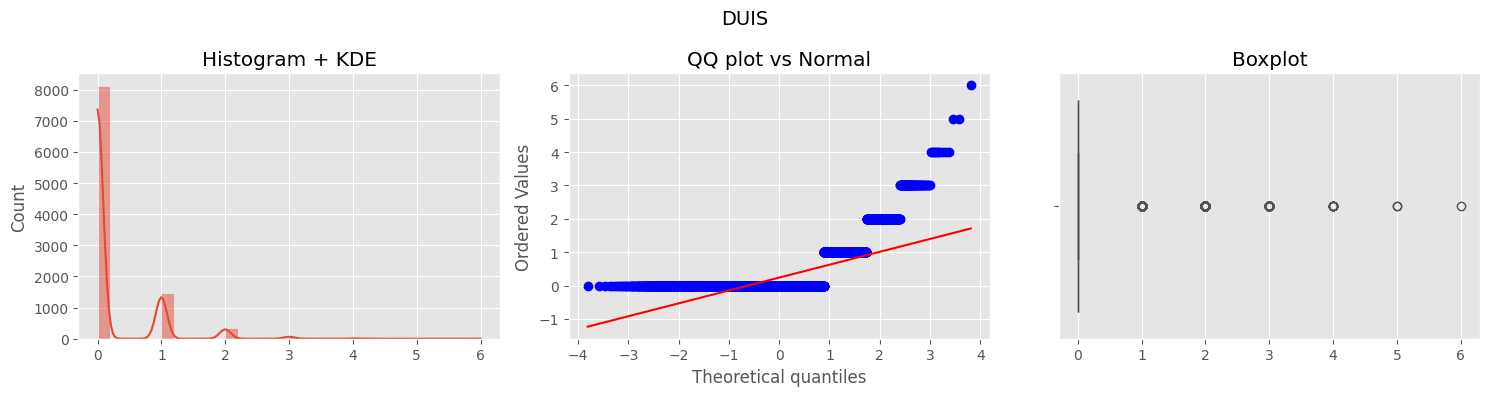

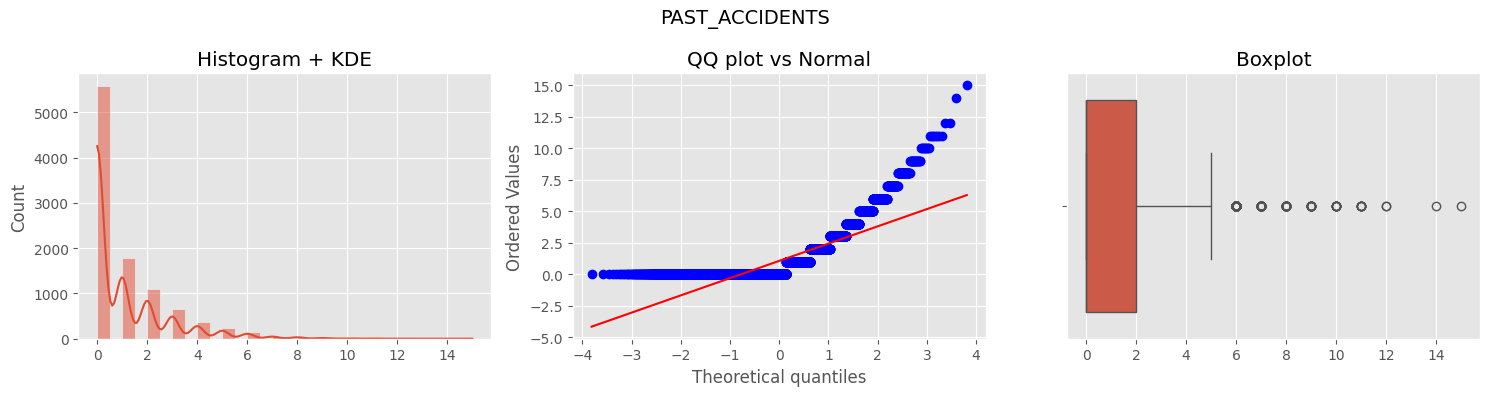

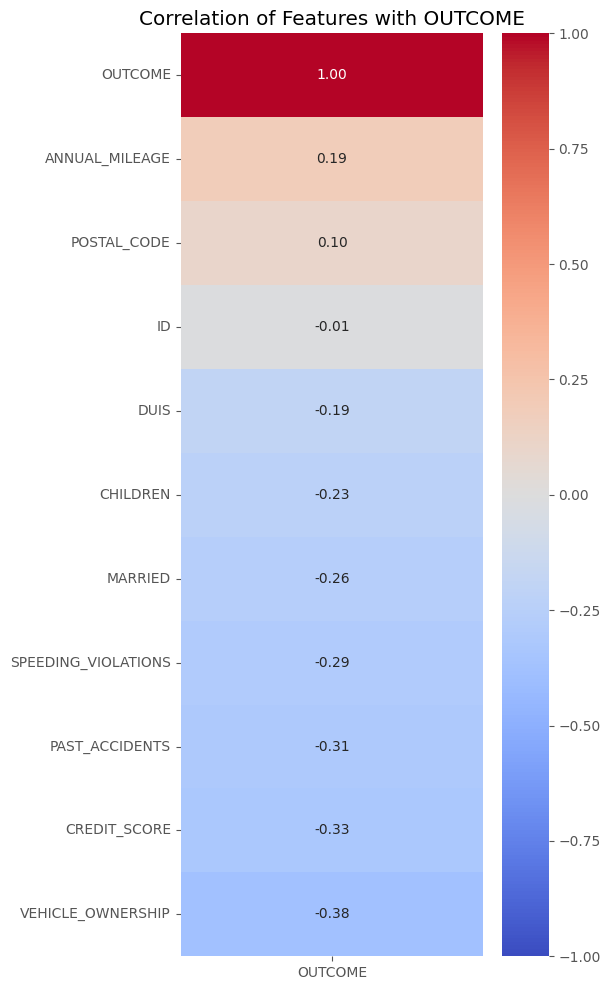

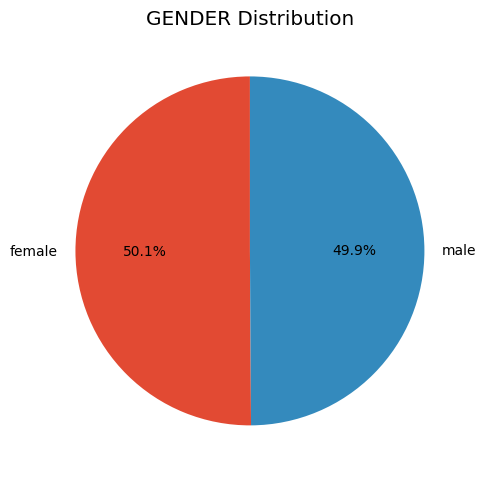

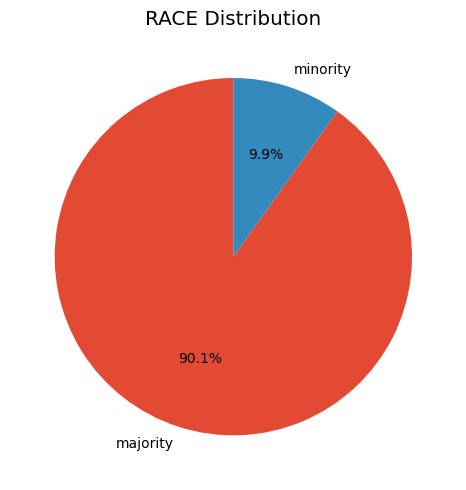

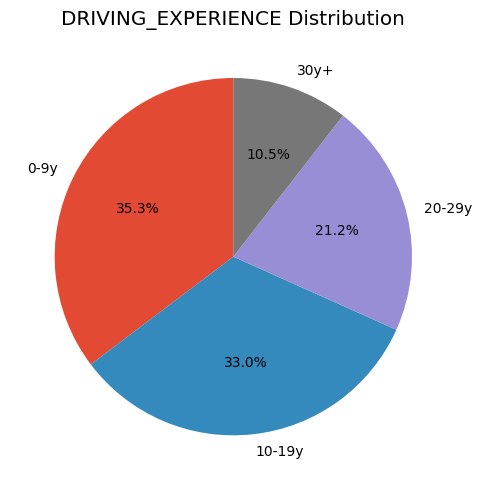

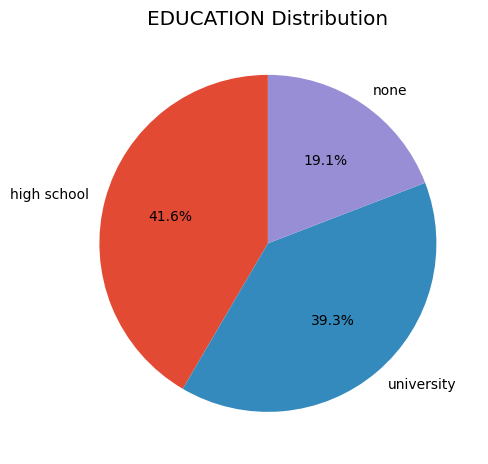

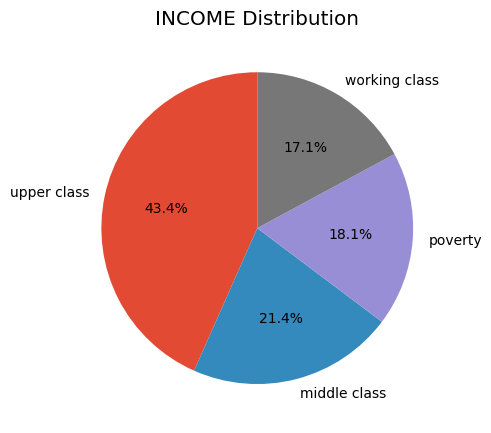

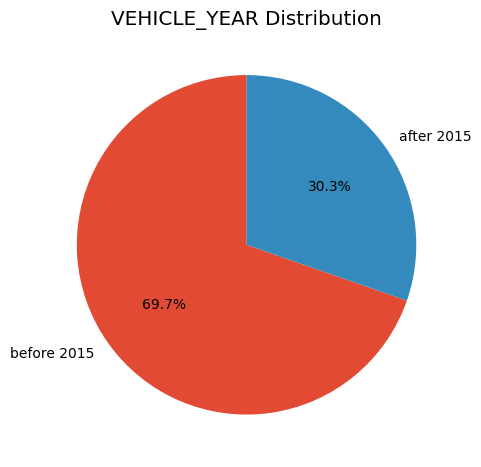

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

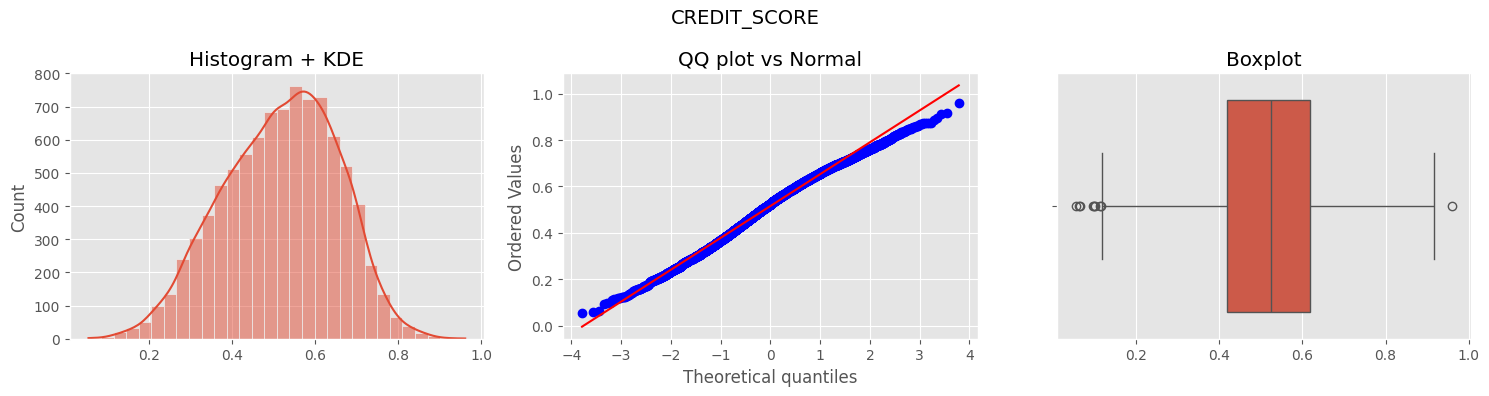

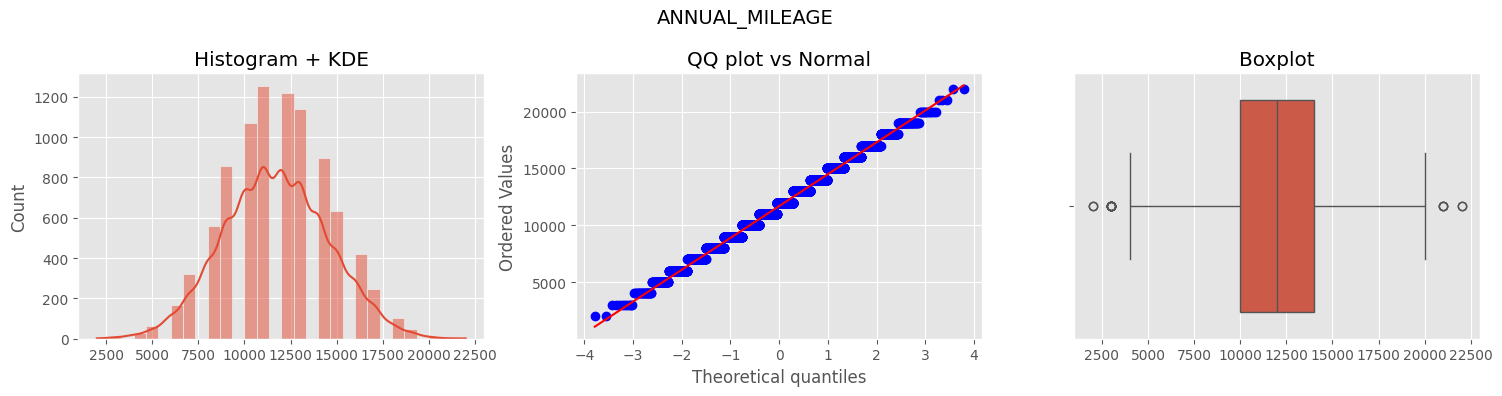

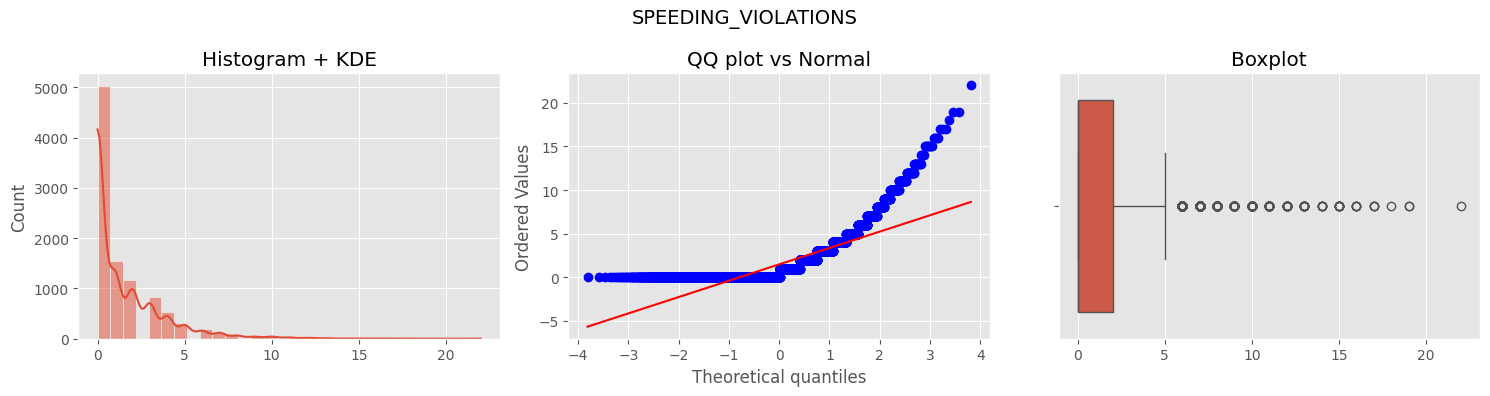

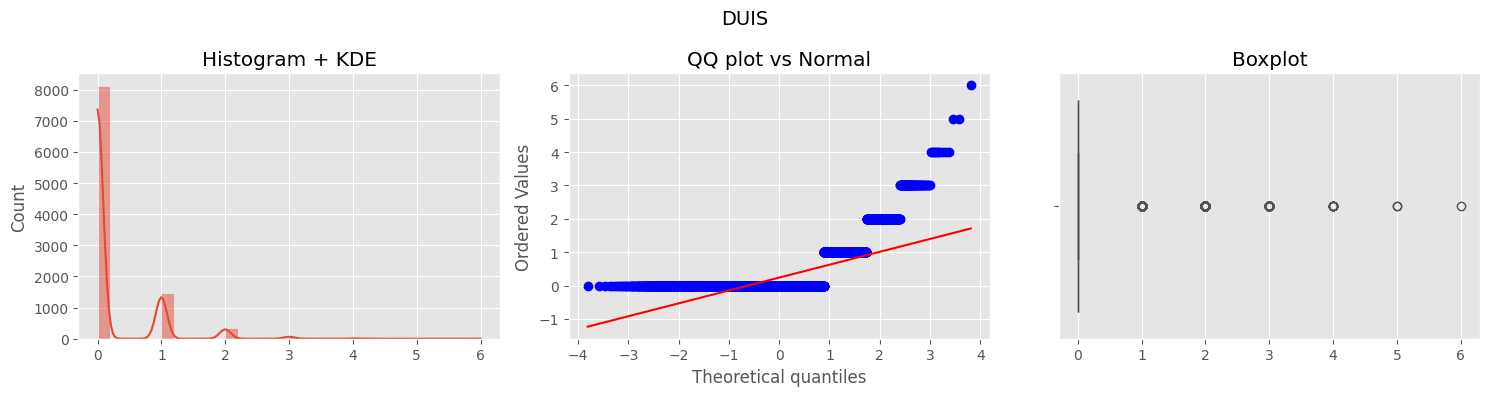

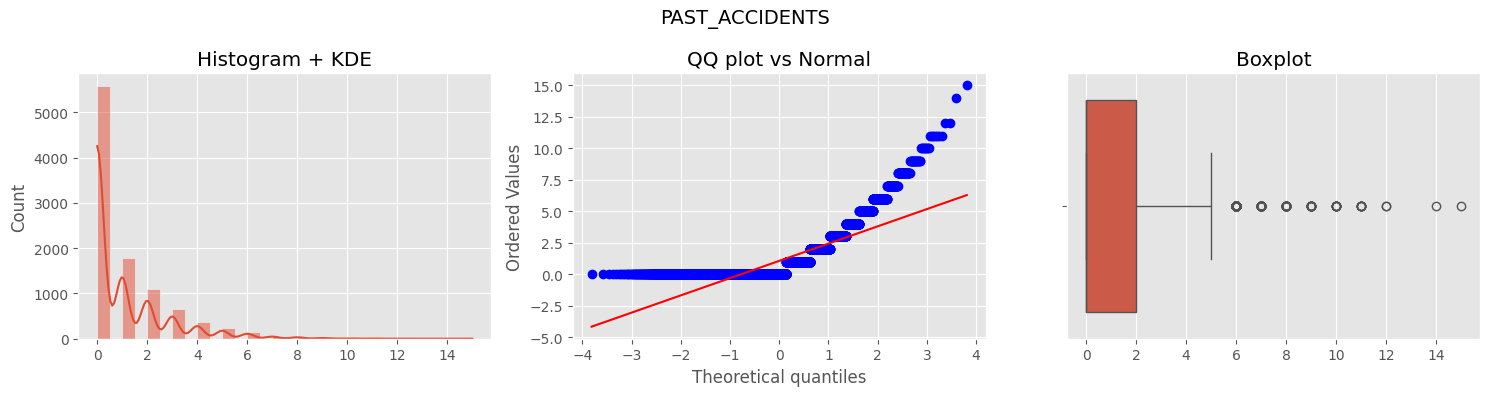

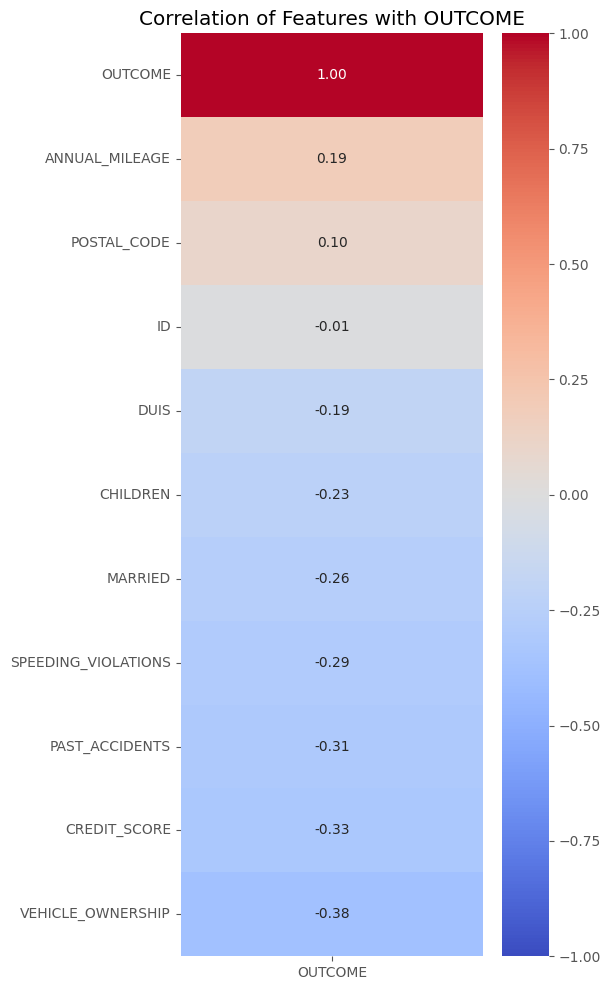

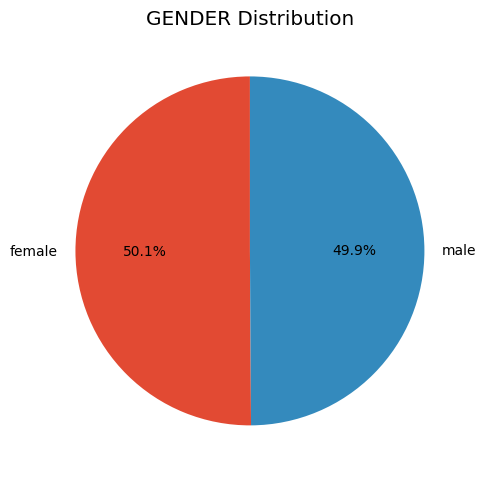

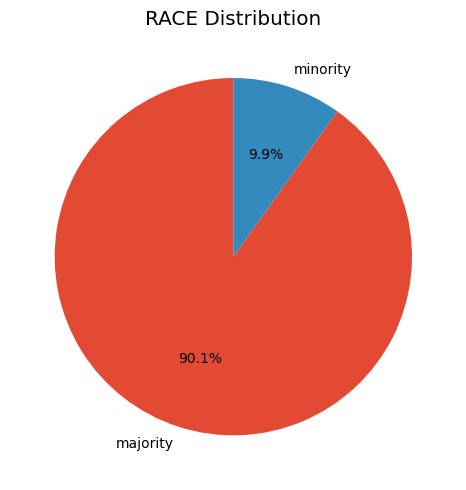

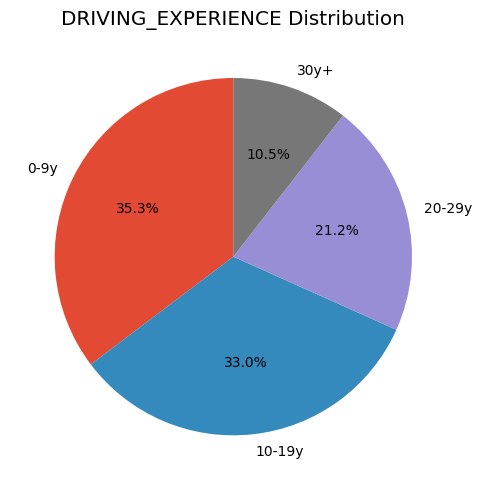

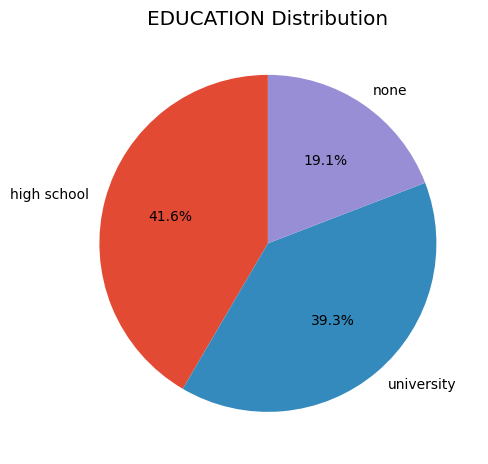

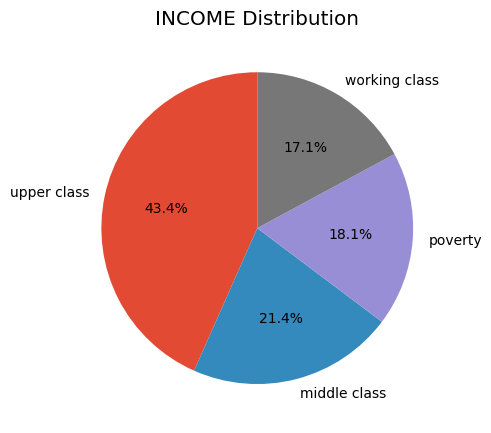

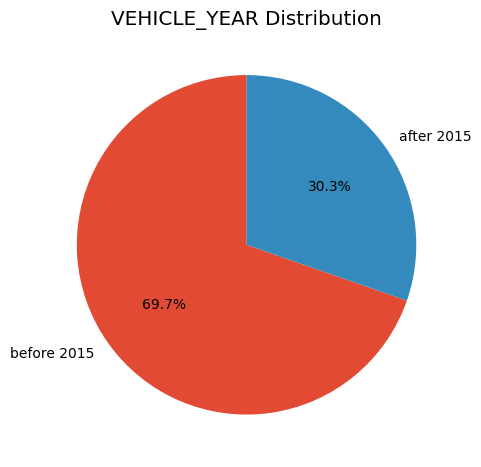

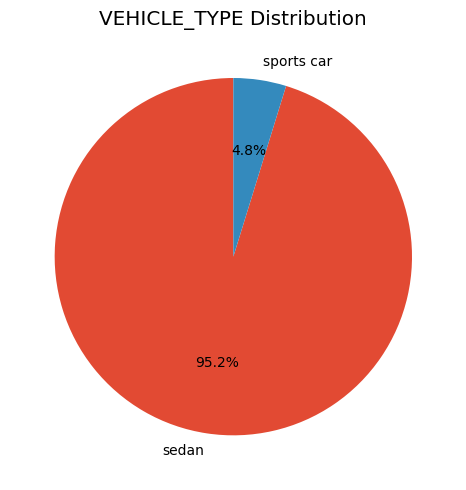

=== DATASET INFO ===
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 

ID    AGE  GENDER      RACE DRIVING_EXPERIENCE    EDUCATION  \
0  569520    65+  female  majority               0-9y  high school   
1  750365  16-25    male  majority               0-9y         none   
2  199901  16-25  female  majority               0-9y  high school   
3  478866  16-25    male  majority               0-9y   university   
4  731664  26-39    male  majority             10-19y         none   

          INCOME  CREDIT_SCORE  VEHICLE_OWNERSHIP VEHICLE_YEAR  MARRIED  \
0    upper class      0.629027                1.0   after 2015      0.0   
1        poverty      0.357757                0.0  before 2015      0.0   
2  working class      0.493146                1.0  before 2015      0.0   
3  working class      0.206013                1.0  before 2015      0.0   
4  working class      0.388366                1.0  before 2015      0.0   

   CHILDREN  POSTAL_CODE  ANNUAL_MILEAGE VEHICLE_TYPE  SPEEDING_VIOLATIONS  \
0       1.0        10238         12000.0        sedan                    0   
1       0.0        10238         16000.0        sedan                    0   
2       0.0        10238         11000.0        sedan                    0   
3       1.0        32765         11000.0        sedan                    0   
4       0.0        32765         12000.0        sedan                    2   

   DUIS  PAST_ACCIDENTS  OUTCOME  
0     0               0      0.0  
1     0               0      1.0  
2     0               0      0.0  
3     0               0      0.0  
4     0               1      1.0


=== DESCRIPTIVE STATISTICS ===


ID  CREDIT_SCORE  VEHICLE_OWNERSHIP       MARRIED  \
count   10000.000000   9018.000000       10000.000000  10000.000000   
mean   500521.906800      0.515813           0.697000      0.498200   
std    290030.768758      0.137688           0.459578      0.500022   
min       101.000000      0.053358           0.000000      0.000000   
25%    249638.500000      0.417191           0.000000      0.000000   
50%    501777.000000      0.525033           1.000000      0.000000   
75%    753974.500000      0.618312           1.000000      1.000000   
max    999976.000000      0.960819           1.000000      1.000000   

           CHILDREN   POSTAL_CODE  ANNUAL_MILEAGE  SPEEDING_VIOLATIONS  \
count  10000.000000  10000.000000     9043.000000         10000.000000   
mean       0.688800  19864.548400    11697.003207             1.482900   
std        0.463008  18915.613855     2818.434528             2.241966   
min        0.000000  10238.000000     2000.000000             0.000000   
25%        0.000000  10238.000000    10000.000000             0.000000   
50%        1.000000  10238.000000    12000.000000             0.000000   
75%        1.000000  32765.000000    14000.000000             2.000000   
max        1.000000  92101.000000    22000.000000            22.000000   

              DUIS  PAST_ACCIDENTS       OUTCOME  
count  10000.00000    10000.000000  10000.000000  
mean       0.23920        1.056300      0.313300  
std        0.55499        1.652454      0.463858  
min        0.00000        0.000000      0.000000  
25%        0.00000        0.000000      0.000000  
50%        0.00000        0.000000      0.000000  
75%        0.00000        2.000000      1.000000  
max        6.00000       15.000000      1.000000

<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  str    
 2   GENDER               10000 non-null  str    
 3   RACE                 10000 non-null  str    
 4   DRIVING_EXPERIENCE   10000 non-null  str    
 5   EDUCATION            10000 non-null  str    
 6   INCOME               10000 non-null  str    
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  str    
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  str    
 15  SPEEDING_VIOLATIONS  10000 non-null  int64  
 16

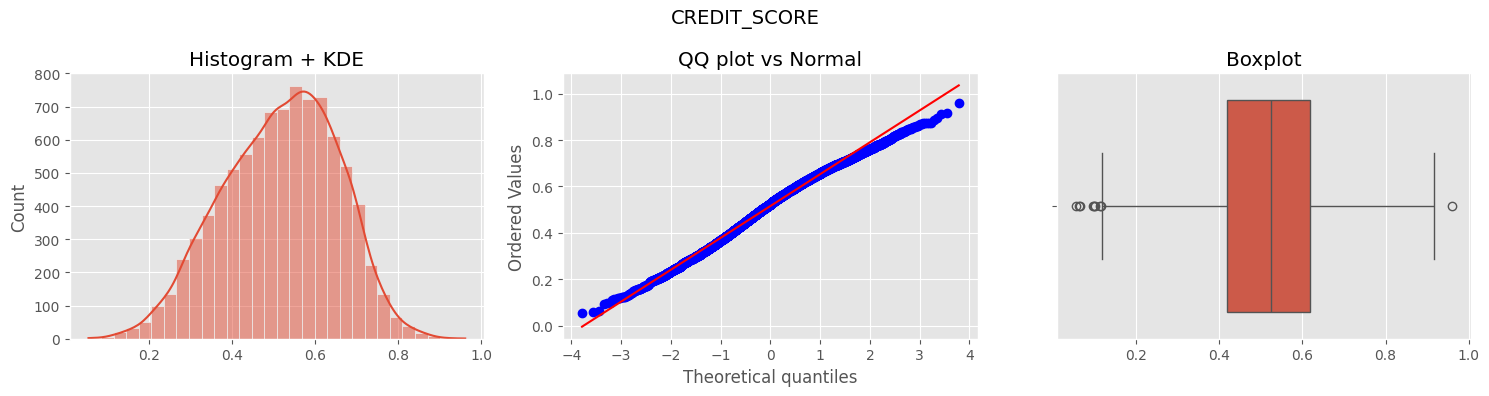

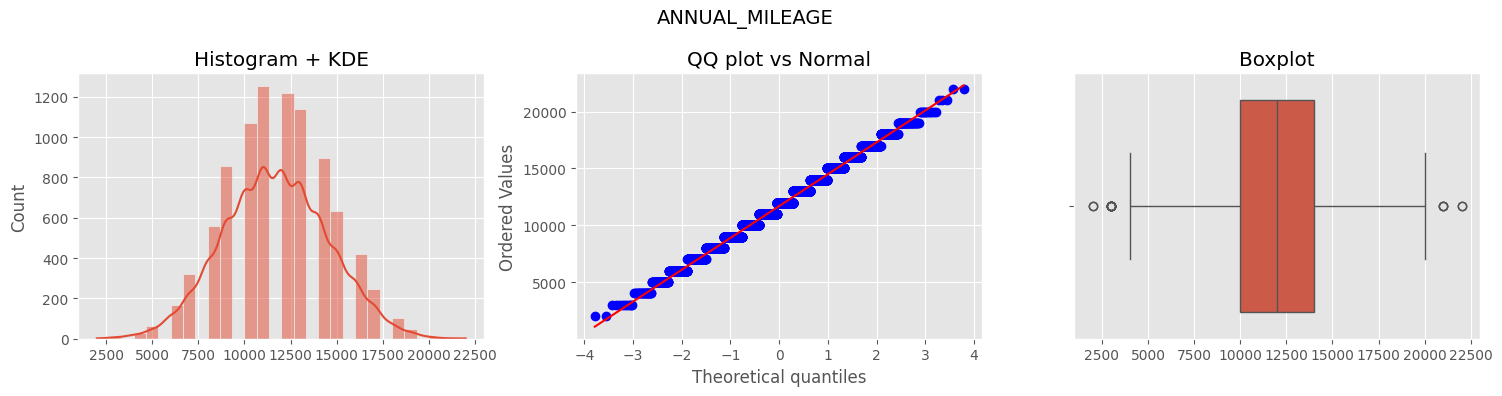

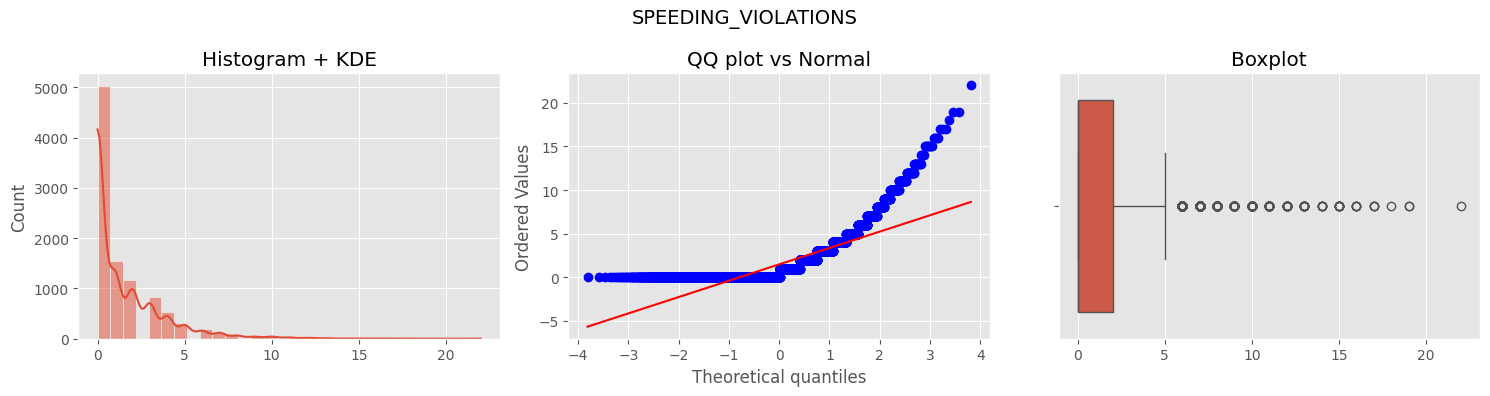

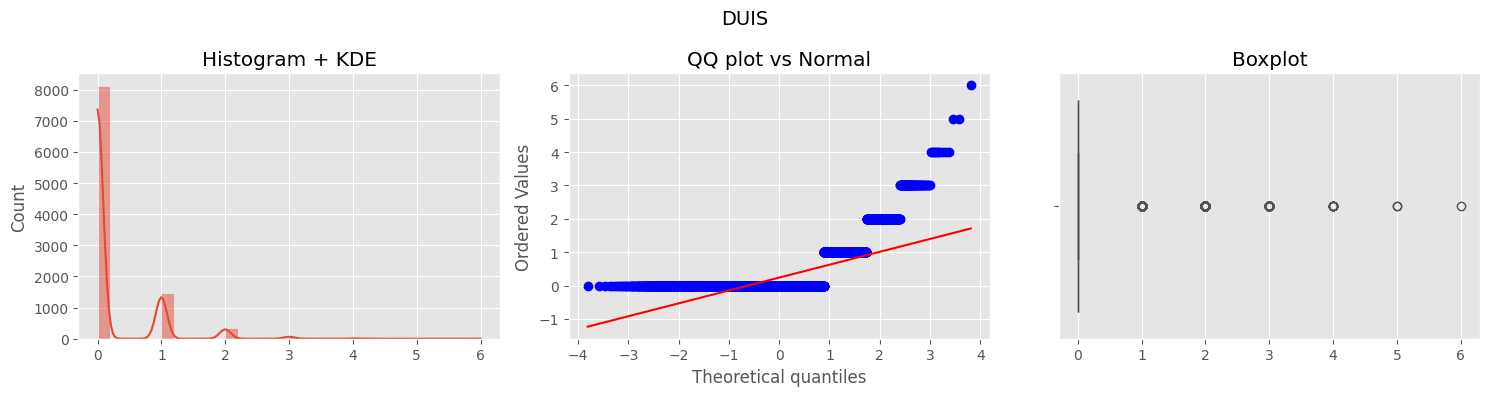

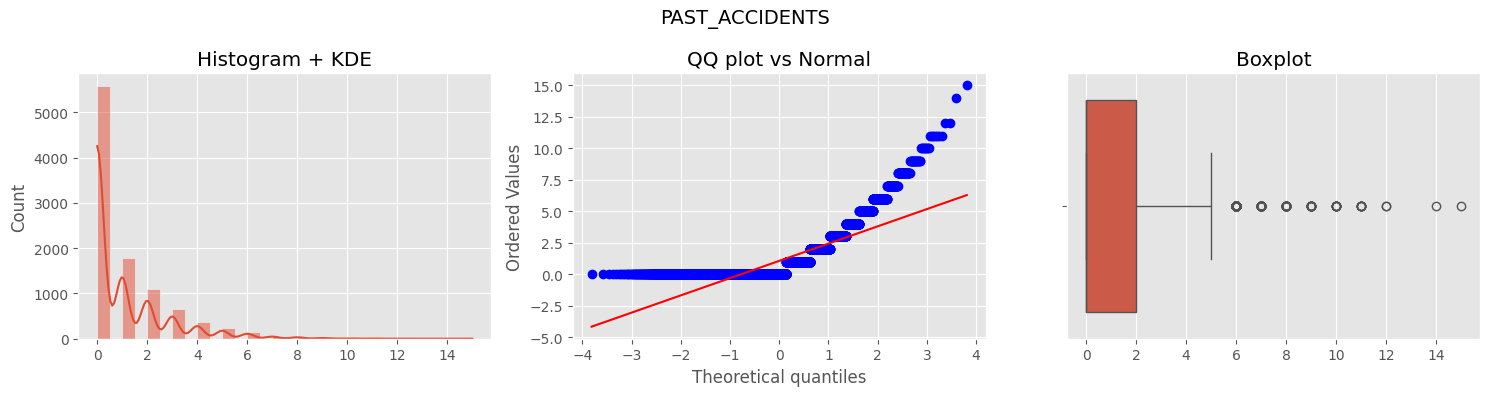

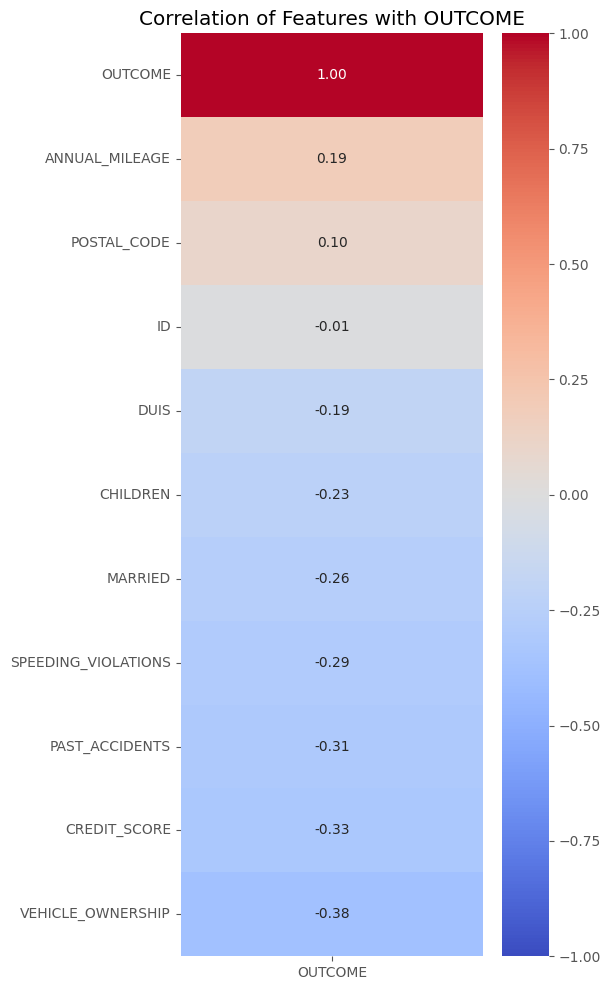

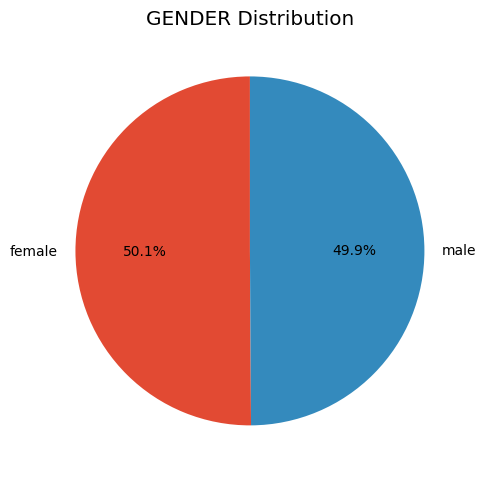

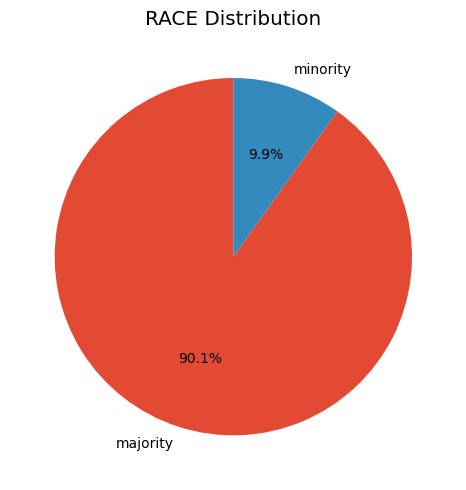

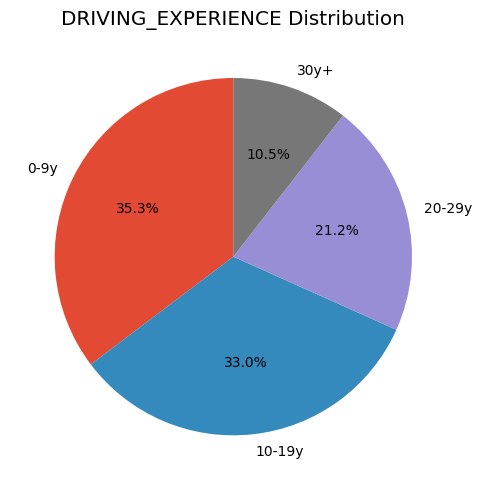

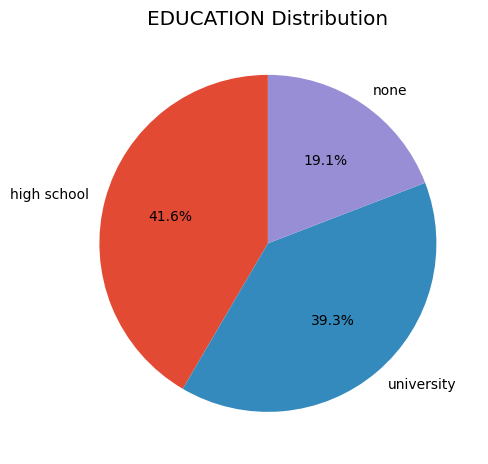

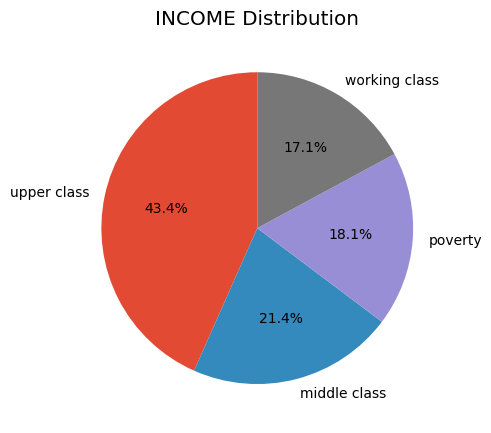

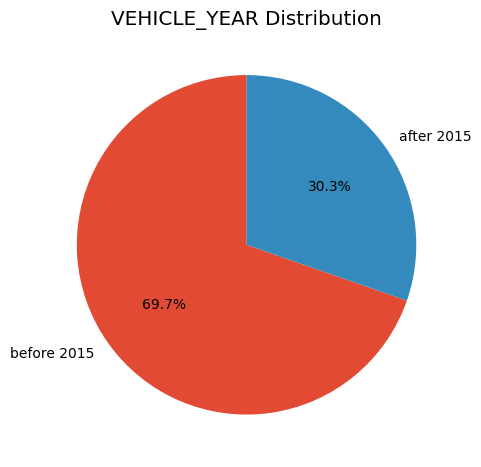

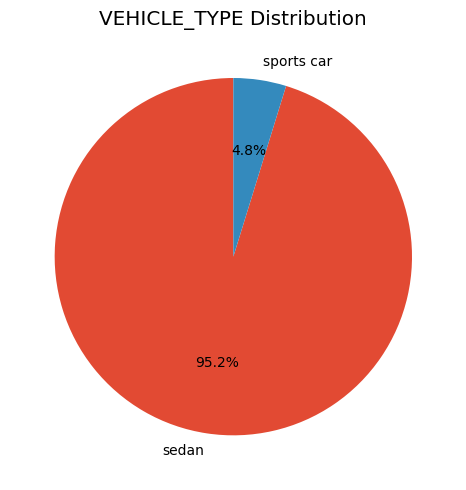

Dataset shape before: (10000, 19)
Nulls before:
CREDIT_SCORE      982
ANNUAL_MILEAGE    957
dtype: int64

Records dropped: 1,851 (18.5%)
Dataset shape after: (8149, 19)

=== TARGET PRESERVATION ===
Claim rate BEFORE: 0.3133
Claim rate AFTER:  0.3112
Difference: 0.0021
✅ Preserved


In [131]:
# Load data
# df, df_copy = load_data("Car_Insurance_Claim.csv")

# Explore
display_basic_info(df)
analyze_missing_data(df)

# Test normality
normality_results = test_normality(df, sample_size=5000)

# Plot diagnostics
plot_diagnostic_plots(df)
plot_correlation_heatmap(df)
plot_categorical_distributions(df)

# Preprocess
df = encode_ordinal_features(df)
df = encode_binary_features(df)
df_clean = drop_missing_values(df)

Train: (5704, 17), Test: (1630, 17), Val: (815, 17)

=== Logistic PERFORMANCE ===
Accuracy    : 0.8436
Precision   : 0.7603
Recall      : 0.7258
F1          : 0.7427
ROC-AUC     : 0.9079

=== Random Forest PERFORMANCE ===
Accuracy    : 0.8485
Precision   : 0.7664
Recall      : 0.7377
F1          : 0.7518
ROC-AUC     : 0.9133

=== XGBoost PERFORMANCE ===
Threshold   : 0.5972
Accuracy    : 0.8436
Precision   : 0.7165
Recall      : 0.8225
F1          : 0.7658
ROC-AUC     : 0.9213

MODEL COMPARISON


Train: (5704, 17), Test: (1630, 17), Val: (815, 17)

=== Logistic PERFORMANCE ===
Accuracy    : 0.8436
Precision   : 0.7603
Recall      : 0.7258
F1          : 0.7427
ROC-AUC     : 0.9079

=== Random Forest PERFORMANCE ===
Accuracy    : 0.8485
Precision   : 0.7664
Recall      : 0.7377
F1          : 0.7518
ROC-AUC     : 0.9133

=== XGBoost PERFORMANCE ===
Threshold   : 0.5972
Accuracy    : 0.8436
Precision   : 0.7165
Recall      : 0.8225
F1          : 0.7658
ROC-AUC     : 0.9213

MODEL COMPARISON


Accuracy  Precision  Recall      F1  ROC-AUC
Model                                                      
Logistic         0.8436     0.7603  0.7258  0.7427   0.9079
Random Forest    0.8485     0.7664  0.7377  0.7518   0.9133
XGBoost          0.8436     0.7165  0.8225  0.7658   0.9213

Train: (5704, 17), Test: (1630, 17), Val: (815, 17)

=== Logistic PERFORMANCE ===
Accuracy    : 0.8436
Precision   : 0.7603
Recall      : 0.7258
F1          : 0.7427
ROC-AUC     : 0.9079

=== Random Forest PERFORMANCE ===
Accuracy    : 0.8485
Precision   : 0.7664
Recall      : 0.7377
F1          : 0.7518
ROC-AUC     : 0.9133

=== XGBoost PERFORMANCE ===
Threshold   : 0.5972
Accuracy    : 0.8436
Precision   : 0.7165
Recall      : 0.8225
F1          : 0.7658
ROC-AUC     : 0.9213

MODEL COMPARISON


Accuracy  Precision  Recall      F1  ROC-AUC
Model                                                      
Logistic         0.8436     0.7603  0.7258  0.7427   0.9079
Random Forest    0.8485     0.7664  0.7377  0.7518   0.9133
XGBoost          0.8436     0.7165  0.8225  0.7658   0.9213

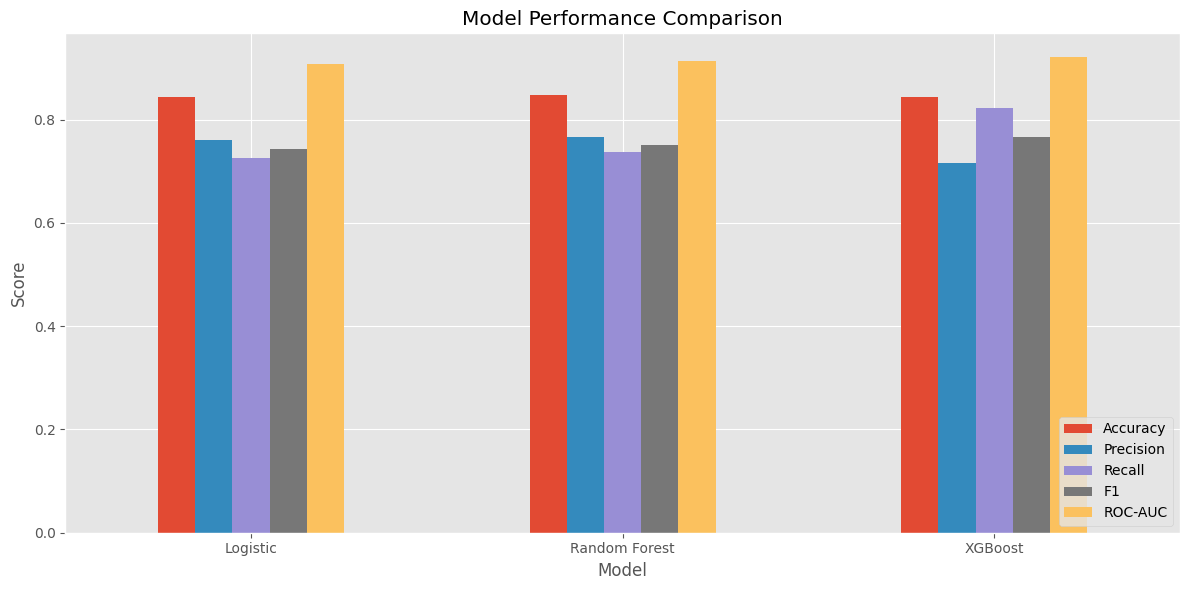

Accuracy  Precision    Recall        F1   ROC-AUC
Model                                                           
Logistic       0.843558   0.760331  0.725838  0.742684  0.907888
Random Forest  0.848466   0.766393  0.737673  0.751759  0.913306
XGBoost        0.843558   0.716495  0.822485  0.765840  0.921328

In [132]:
# Split
X_train, X_test, X_val, y_train, y_test, y_val = split_data(df_clean)

# Train models
logit = train_logit(X_train, y_train, C=1.0)
rf = train_random_forest(X_train, y_train, n_estimators=200)
xgb_model_recall = train_xgboost(X_train, y_train,  n_estimators = 355, learning_rate = 0.14960040405145628, max_depth = 2, min_child_weight = 7, 
                          subsample = 0.936370062213827, colsample_bytree = 0.8644659014780961 ,gamma = 4.2044544489396145,
                          reg_alpha = 0.4600882894025401, reg_lambda = 1.7197319996146099 )
xgb_model_still_recall = train_xgboost(X_train, y_train, n_estimators = 227, learning_rate = 0.2799367199473953, max_depth = 9, min_child_weight = 1,
                          subsample = 0.8285551718236109, colsample_bytree = 0.6613917880650725, gamma = 0.017926244506471428,
                          reg_alpha = 0.3067439242926182, reg_lambda = 5.908863845419243)
xgb_model_precision_not_overfit = train_xgboost(X_train, y_train, n_estimators = 168, learning_rate = 0.015631599062567773, max_depth = 3, min_child_weight = 3,
                          subsample = 0.554904730920193, colsample_bytree = 0.5661206393438786, gamma = 3.960461038350048,
                          reg_alpha = 0.3861040848230848, reg_lambda = 4.152049268977841, threshold = 0.8969)
xgb_model_pure_precision = train_xgboost(X_train, y_train, n_estimators = 390, learning_rate = 0.006815540405463377 , max_depth = 2, min_child_weight = 2,
                          subsample = 0.989490234485494, colsample_bytree = 0.525423870221976, gamma = 1.0421710162042357 ,
                          reg_alpha = 0.43294444051781733, reg_lambda = 4.9417861111563814, threshold = 0.8910)
xgb_model = train_xgboost(X_train, y_train, n_estimators = 320, learning_rate = 0.16330202627321247 , max_depth = 4, min_child_weight = 10,
                          subsample = 0.8634104334210331, colsample_bytree = 0.7784784378425039, gamma = 4.999770127015127,
                          reg_alpha = 0.9365294668951473, reg_lambda = 9.768584844844348, threshold = 0.5972)
# Evaluate
logit_metrics = evaluate_model(logit, X_test, y_test, "Logistic")
rf_metrics = evaluate_model(rf, X_test, y_test, "Random Forest")
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, "XGBoost", is_xgb=True, threshold = 0.5972)

# Compare
compare_models([logit_metrics, rf_metrics, xgb_metrics])

In [133]:
# Optimize
best_params, study = optimize_xgboost_optuna(X_train, y_train, X_val, y_val, cv_folds = 10, n_trials=100)

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<01:53,  1.24s/it]

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<01:53,  1.24s/it]

[I 2026-02-24 01:49:15,553] Trial 7 finished with value: 0.7628590134021953 and parameters: {'n_estimators': 196, 'learning_rate': 0.15866810152088356, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9919490489533596, 'colsample_bytree': 0.5931335866925262, 'gamma': 8.393019746804073, 'reg_alpha': 0.5293206950088326, 'reg_lambda': 9.83385128306212, 'threshold': 0.6473722606563548}. Best is trial 6 with value: 0.7702156054577385.


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<01:53,  1.24s/it]

[I 2026-02-24 01:49:15,553] Trial 7 finished with value: 0.7628590134021953 and parameters: {'n_estimators': 196, 'learning_rate': 0.15866810152088356, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9919490489533596, 'colsample_bytree': 0.5931335866925262, 'gamma': 8.393019746804073, 'reg_alpha': 0.5293206950088326, 'reg_lambda': 9.83385128306212, 'threshold': 0.6473722606563548}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<02:39,  1.74s/it]


[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<01:53,  1.24s/it]

[I 2026-02-24 01:49:15,553] Trial 7 finished with value: 0.7628590134021953 and parameters: {'n_estimators': 196, 'learning_rate': 0.15866810152088356, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9919490489533596, 'colsample_bytree': 0.5931335866925262, 'gamma': 8.393019746804073, 'reg_alpha': 0.5293206950088326, 'reg_lambda': 9.83385128306212, 'threshold': 0.6473722606563548}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<02:39,  1.74s/it]


[W 2026-02-24 01:49:15,961] Trial 8 failed with parameters: {'n_estimators': 136, 'learning_rate': 0.26858600198833377, 'max_depth': 12, 'min_child_weight': 12, 'subsample': 0.568536958145276, 'colsample_bytree': 0.5928880735075346, 'gamma': 10.250395630587505, 'reg_alpha': 0.3827040401337464, 'reg_lambda': 7.209022013784865, 'threshold': 0.6331484677896997} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2200/4018432438.py", line 41, in objective
    y_proba_cv = cross_val_predict(
                 ^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.

[I 2026-02-24 01:49:02,154] A new study created in memory with name: no-name-7b321b1e-7615-46c9-955e-13b7092e04d8
Best trial: 0. Best value: 0.767004:   1%|          | 1/100 [00:04<08:07,  4.92s/it]

[I 2026-02-24 01:49:07,073] Trial 0 finished with value: 0.767004334522544 and parameters: {'n_estimators': 490, 'learning_rate': 0.28820910215073403, 'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.5547081862093844, 'colsample_bytree': 0.5639681050128373, 'gamma': 12.968854026275816, 'reg_alpha': 0.1694789777331398, 'reg_lambda': 8.65555024776534, 'threshold': 0.5579133683291585}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   2%|▏         | 2/100 [00:06<04:22,  2.68s/it]

[I 2026-02-24 01:49:08,185] Trial 1 finished with value: 0.7567970209509822 and parameters: {'n_estimators': 135, 'learning_rate': 0.03177177378489762, 'max_depth': 9, 'min_child_weight': 11, 'subsample': 0.5057720330155859, 'colsample_bytree': 0.8923511359985552, 'gamma': 1.4211828153369728, 'reg_alpha': 0.47779808297553455, 'reg_lambda': 2.344288242717073, 'threshold': 0.6352104849099124}. Best is trial 0 with value: 0.767004334522544.


Best trial: 0. Best value: 0.767004:   3%|▎         | 3/100 [00:07<03:29,  2.16s/it]

[I 2026-02-24 01:49:09,727] Trial 2 finished with value: 0.7606090467628464 and parameters: {'n_estimators': 229, 'learning_rate': 0.0752682469206203, 'max_depth': 5, 'min_child_weight': 12, 'subsample': 0.6833074313807672, 'colsample_bytree': 0.6426728473313013, 'gamma': 1.1932442541552897, 'reg_alpha': 0.16538874498067307, 'reg_lambda': 3.165706410703174, 'threshold': 0.48082727420250504}. Best is trial 0 with value: 0.767004334522544.


Best trial: 3. Best value: 0.769214:   4%|▍         | 4/100 [00:09<03:07,  1.95s/it]

[I 2026-02-24 01:49:11,361] Trial 3 finished with value: 0.7692137006795208 and parameters: {'n_estimators': 343, 'learning_rate': 0.09180712663388806, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7700596333105691, 'colsample_bytree': 0.6168754490472592, 'gamma': 4.992034838512564, 'reg_alpha': 0.19592897211953872, 'reg_lambda': 3.883948318295306, 'threshold': 0.6610803883156249}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   5%|▌         | 5/100 [00:10<02:38,  1.67s/it]

[I 2026-02-24 01:49:12,535] Trial 4 finished with value: 0.6862019758766231 and parameters: {'n_estimators': 296, 'learning_rate': 0.18136092334109033, 'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.6953670397498126, 'colsample_bytree': 0.550236794106155, 'gamma': 7.633201093048908, 'reg_alpha': 0.6417960281561205, 'reg_lambda': 5.904725144594619, 'threshold': 0.809140243862313}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 3. Best value: 0.769214:   6%|▌         | 6/100 [00:11<02:04,  1.32s/it]

[I 2026-02-24 01:49:13,176] Trial 5 finished with value: 0.7503132845908883 and parameters: {'n_estimators': 140, 'learning_rate': 0.03412926830039006, 'max_depth': 2, 'min_child_weight': 9, 'subsample': 0.9535575087221955, 'colsample_bytree': 0.8979124128237377, 'gamma': 10.372805802020338, 'reg_alpha': 0.17105331815157235, 'reg_lambda': 9.213014559206314, 'threshold': 0.4239497250180909}. Best is trial 3 with value: 0.7692137006795208.


Best trial: 6. Best value: 0.770216:   7%|▋         | 7/100 [00:12<02:02,  1.31s/it]

[I 2026-02-24 01:49:14,470] Trial 6 finished with value: 0.7702156054577385 and parameters: {'n_estimators': 375, 'learning_rate': 0.20898177410855015, 'max_depth': 9, 'min_child_weight': 19, 'subsample': 0.8966969500127651, 'colsample_bytree': 0.9024181286991062, 'gamma': 12.543718358798543, 'reg_alpha': 0.2579835793837578, 'reg_lambda': 3.2372191744041983, 'threshold': 0.4938522720374031}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<01:53,  1.24s/it]

[I 2026-02-24 01:49:15,553] Trial 7 finished with value: 0.7628590134021953 and parameters: {'n_estimators': 196, 'learning_rate': 0.15866810152088356, 'max_depth': 2, 'min_child_weight': 2, 'subsample': 0.9919490489533596, 'colsample_bytree': 0.5931335866925262, 'gamma': 8.393019746804073, 'reg_alpha': 0.5293206950088326, 'reg_lambda': 9.83385128306212, 'threshold': 0.6473722606563548}. Best is trial 6 with value: 0.7702156054577385.


Best trial: 6. Best value: 0.770216:   8%|▊         | 8/100 [00:13<02:39,  1.74s/it]


[W 2026-02-24 01:49:15,961] Trial 8 failed with parameters: {'n_estimators': 136, 'learning_rate': 0.26858600198833377, 'max_depth': 12, 'min_child_weight': 12, 'subsample': 0.568536958145276, 'colsample_bytree': 0.5928880735075346, 'gamma': 10.250395630587505, 'reg_alpha': 0.3827040401337464, 'reg_lambda': 7.209022013784865, 'threshold': 0.6331484677896997} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/optuna/study/_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_2200/4018432438.py", line 41, in objective
    y_proba_cv = cross_val_predict(
                 ^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/python/3.12.1/lib/python3.

KeyboardInterrupt: 

COMPLETE CALIBRATION PIPELINE
CALIBRATION DIAGNOSTICS
Brier Score - Train: 0.1070, Test: 0.1167
Log Loss    - Train: 0.3392, Test: 0.3635
Gap (Train-Test): Brier=-0.0097, LogLoss=-0.0243

CALIBRATION FIX: ISOTONIC
Brier Score Improvement: 0.1167 → 0.1049 (10.1% better)


COMPLETE CALIBRATION PIPELINE
CALIBRATION DIAGNOSTICS
Brier Score - Train: 0.1070, Test: 0.1167
Log Loss    - Train: 0.3392, Test: 0.3635
Gap (Train-Test): Brier=-0.0097, LogLoss=-0.0243

CALIBRATION FIX: ISOTONIC
Brier Score Improvement: 0.1167 → 0.1049 (10.1% better)


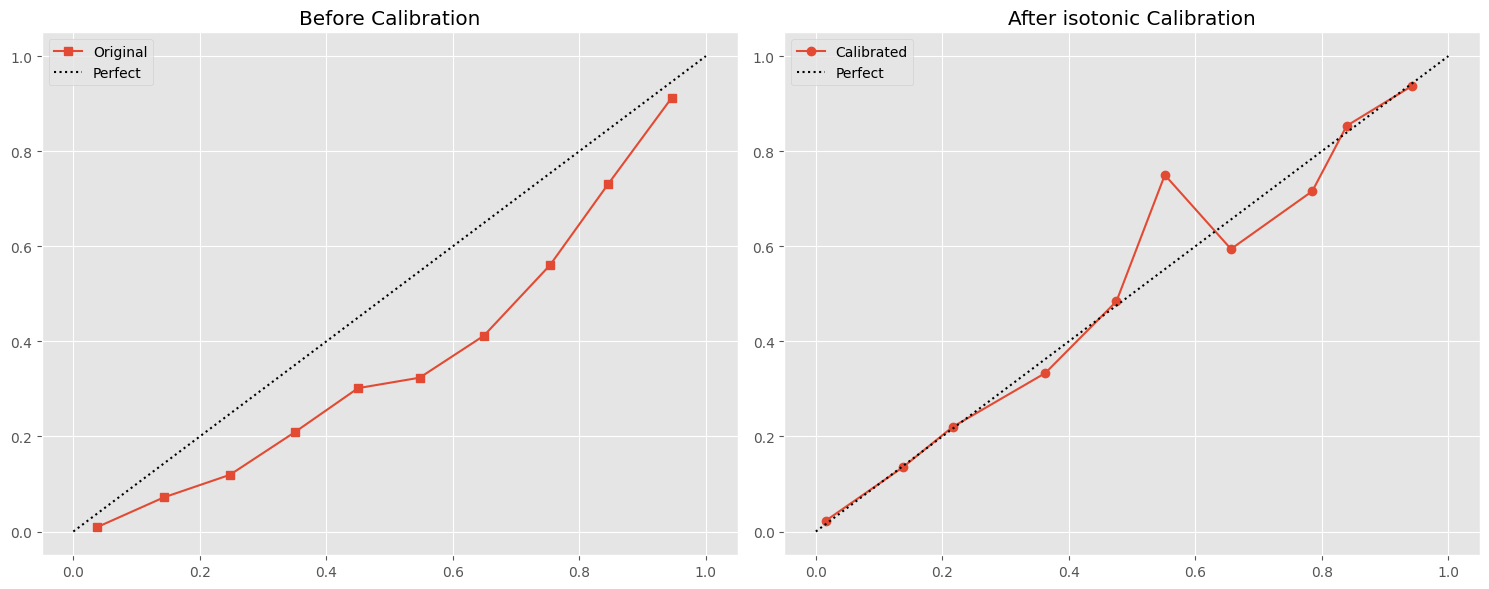

COMPLETE CALIBRATION PIPELINE
CALIBRATION DIAGNOSTICS
Brier Score - Train: 0.1070, Test: 0.1167
Log Loss    - Train: 0.3392, Test: 0.3635
Gap (Train-Test): Brier=-0.0097, LogLoss=-0.0243

CALIBRATION FIX: ISOTONIC
Brier Score Improvement: 0.1167 → 0.1049 (10.1% better)


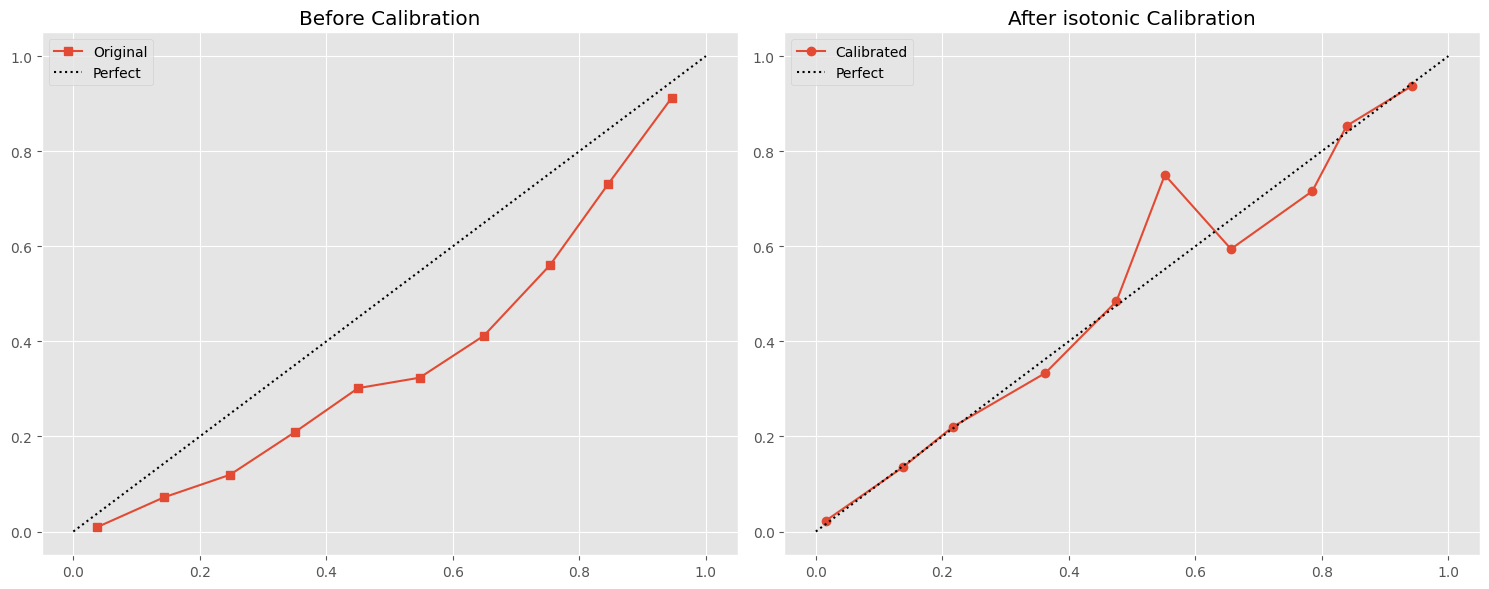


CALIBRATION FIX: PLATT


InvalidParameterError: The 'cv' parameter of CalibratedClassifierCV must be an int in the range [2, inf), an object implementing 'split' and 'get_n_splits', an iterable or None. Got 'prefit' instead.

In [134]:
# Tests ALL methods, picks BEST
final_calibrator, y_calib_best, results = complete_calibration_pipeline(
    xgb_model, X_train, y_train, X_test, y_test
)

print("\\nBEST METHOD:", list(results.keys())[list(results.values()).index(min(results.values()))])
print("Brier improvement:", (1 - min(results.values())/0.1196)*100, "%")


In [135]:
calibrator = IsotonicRegression(out_of_bounds='clip')
train_proba = xgb_model.predict_proba(X_train)[:, 1]


In [136]:
calibrator.fit(train_proba, y_train)

# Create production model
production_model = CalibratedXGBoost(xgb_model, calibrator)

In [137]:
# Check improvement
test_raw = xgb_model.predict_proba(X_test)[:, 1]
test_calib = production_model.predict_proba(X_test)[:, 1]

print(f"Brier Raw:     {brier_score_loss(y_test, test_raw):.4f}")
print(f"Brier Calib:   {brier_score_loss(y_test, test_calib):.4f}")
print(f"Improvement:   {(1 - brier_score_loss(y_test, test_calib) / brier_score_loss(y_test, test_raw)) * 100:.1f}%")


Brier Raw:     0.1167
Brier Calib:   0.1049
Improvement:   10.1%


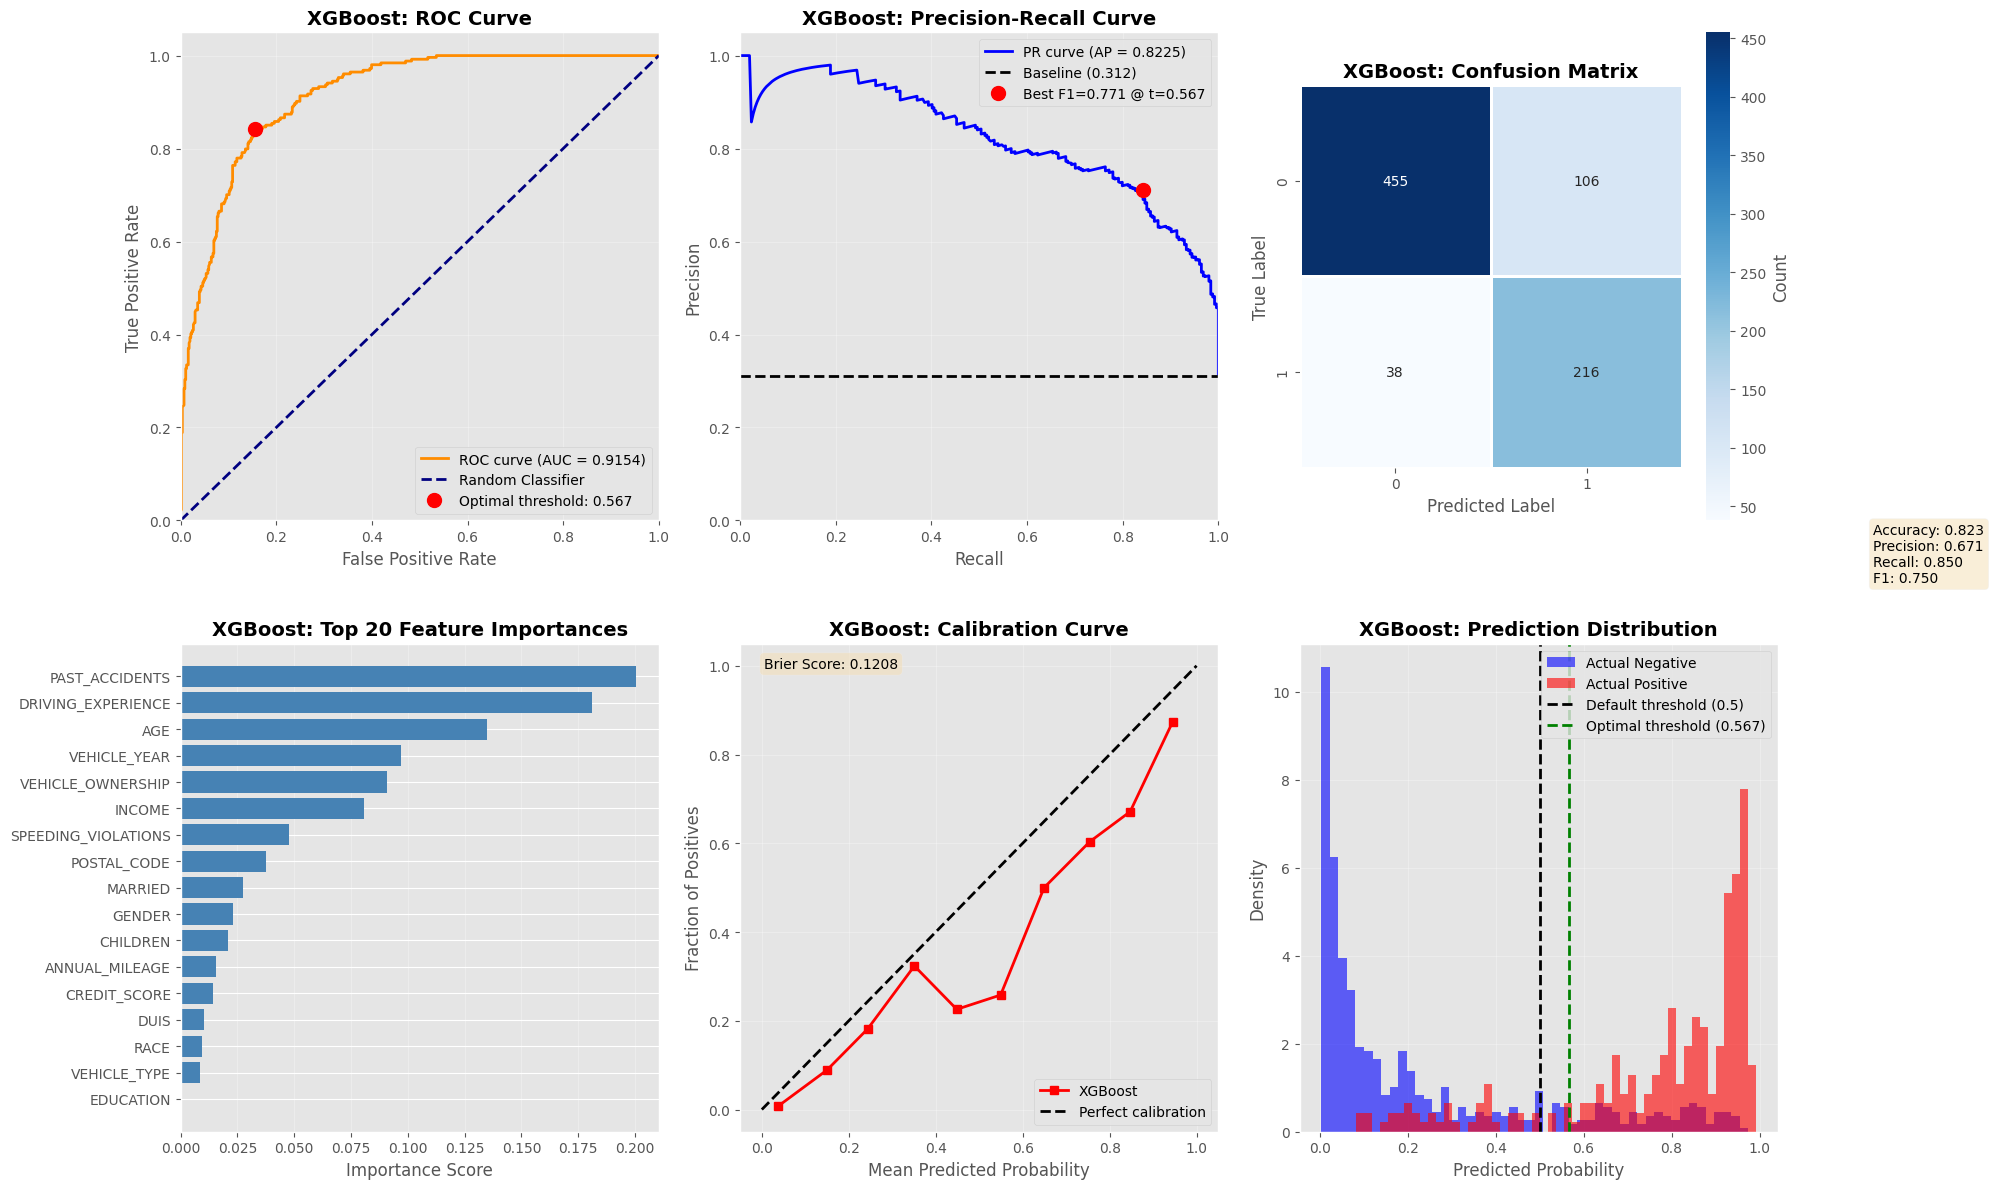


XGBOOST DIAGNOSTIC SUMMARY

1. CLASSIFICATION METRICS:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0     0.9229    0.8111    0.8634       561
         1.0     0.6708    0.8504    0.7500       254

    accuracy                         0.8233       815
   macro avg     0.7969    0.8307    0.8067       815
weighted avg     0.8443    0.8233    0.8280       815


2. PROBABILITY METRICS:
--------------------------------------------------------------------------------
ROC-AUC Score:           0.9154
Average Precision (AP):  0.8225
Brier Score:             0.1208 (lower is better)
Log Loss:                0.3741 (lower is better)

3. OPTIMAL THRESHOLDS:
--------------------------------------------------------------------------------
ROC-based threshold:     0.5671 (max TPR-FPR)
PR-based threshold:      0.5671 (max F1)
Current threshold:       0.5000 (default)

4. CLASS DISTRIBUTION:
--------

{'roc_auc': 0.9154210001824639,
 'avg_precision': 0.8225447520803726,
 'brier_score': 0.12081334739923477,
 'optimal_threshold_roc': np.float64(0.5670774579048157),
 'optimal_threshold_pr': np.float32(0.56707746),
 'confusion_matrix': array([[455, 106],
        [ 38, 216]])}

In [138]:
plot_xgboost_diagnostics(xgb_model, X_train, y_train, X_val, y_val)

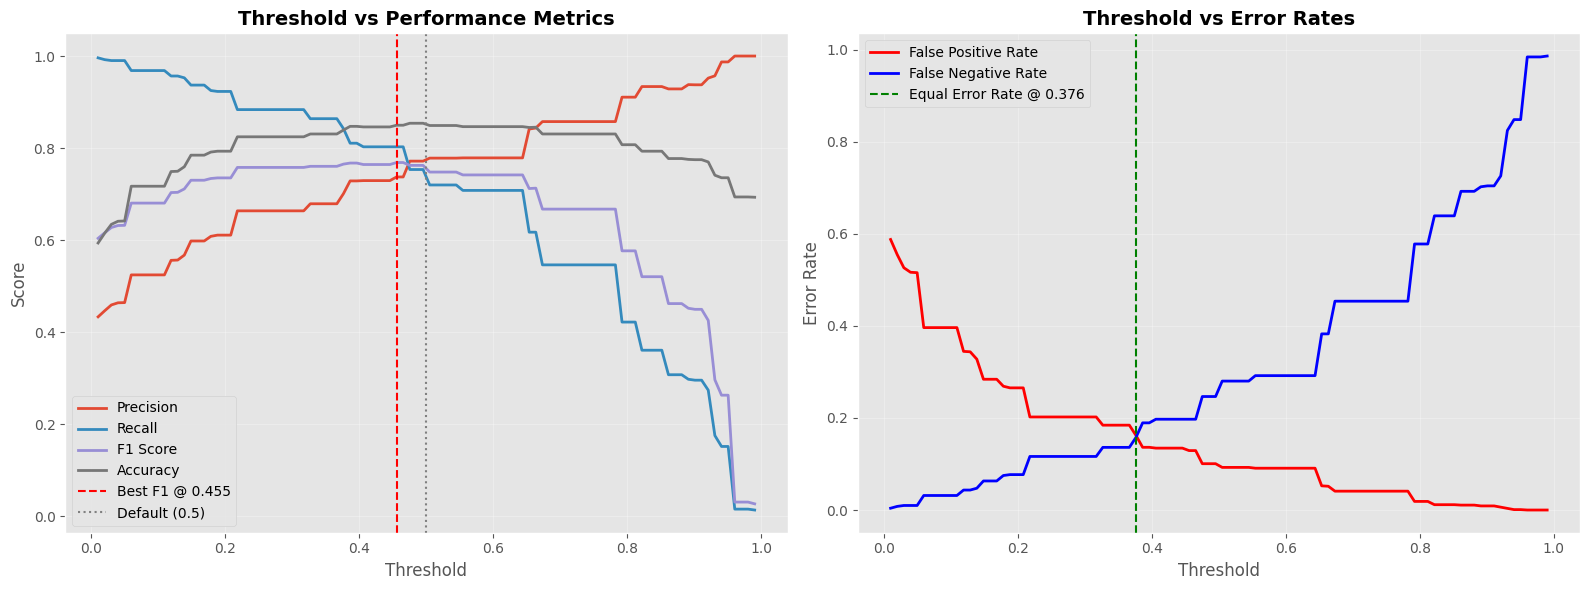


THRESHOLD RECOMMENDATIONS
Best F1 threshold:      0.4555 (F1=0.7686)
Equal error rate:       0.3763 (FPR=FNR=0.1621)
High precision (0.9+):  0.7920
High recall (0.9+):     0.2080


In [139]:
plot_threshold_analysis(production_model, X_test, y_test)

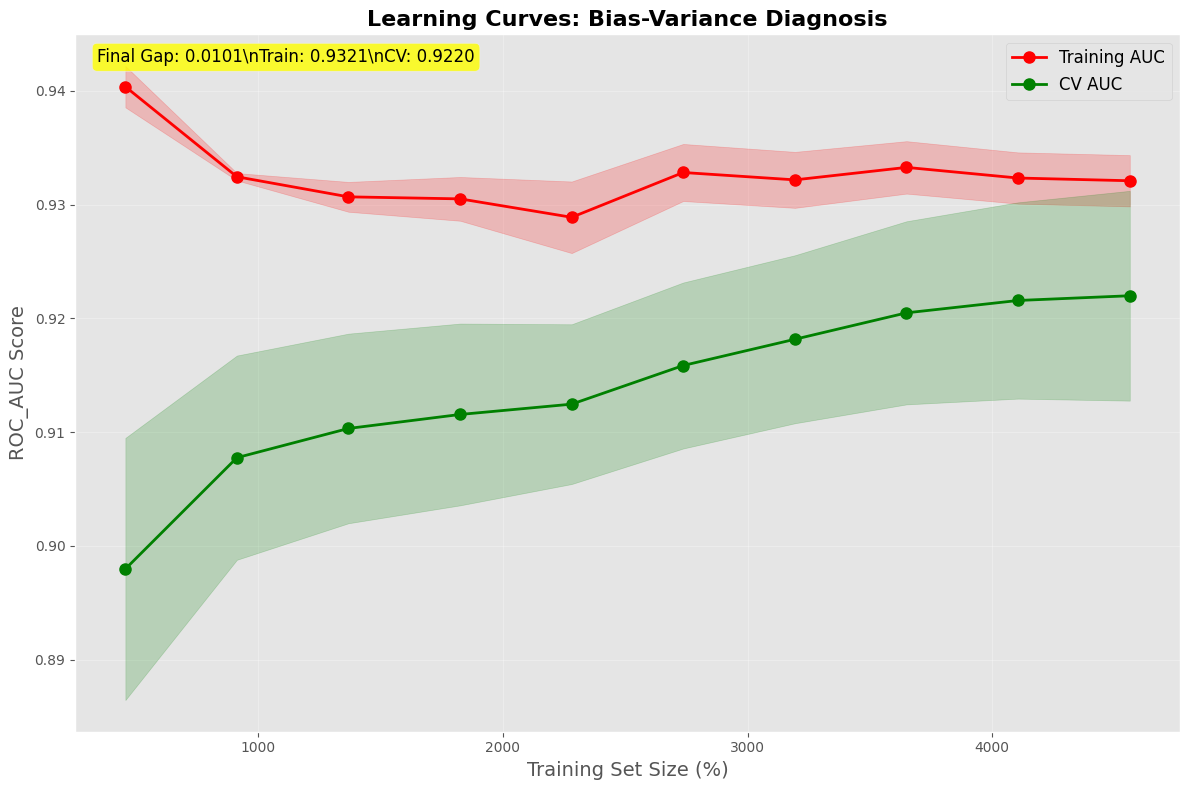


🧠 LEARNING CURVE DIAGNOSIS
Final Train AUC: 0.9321
Final CV AUC:    0.9220
Gap:            0.0101
CV Std:         0.0111

✅ PERFECT - Optimal bias-variance tradeoff!
   Ready for production

CV Stability: ✅ EXCELLENT (low variance)


{'final_gap': np.float64(0.010106048083960095),
 'train_auc': np.float64(0.9320968547250743),
 'cv_auc': np.float64(0.9219908066411142),
 'cv_std': np.float64(0.011084798631493673)}

In [140]:
plot_learning_curves(
    xgb_model,    
    X_train,        
    y_train,        
    cv=5            
)

In [141]:
# Save everything in ONE file
joblib.dump({
    'xgb_model': xgb_model,
    'calibrator': calibrator,
    'threshold': 0.549,
    'production_model': production_model
}, 'calibrated_xgboost_final.pkl')

['calibrated_xgboost_final.pkl']

In [142]:
y_pred_final = production_model.predict(X_test, threshold=0.549)
print(classification_report(y_test, y_pred_final))



              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89      1123
         1.0       0.78      0.72      0.75       507

    accuracy                           0.85      1630
   macro avg       0.83      0.81      0.82      1630
weighted avg       0.85      0.85      0.85      1630



In [143]:
# Risk tiers for pricing
risk_tiers = pd.qcut(production_model.predict_proba(X_test)[:,1], q=5)
risk_analysis = pd.DataFrame({
    'tier': risk_tiers,
    'actual': y_test
}).groupby('tier')['actual'].agg(['count', 'mean'])
print(risk_analysis)


                   count      mean
tier                              
(-0.001, 0.00691]    465  0.004301
(0.00691, 0.0585]    229  0.061135
(0.0585, 0.32]       291  0.182131
(0.32, 0.668]        322  0.500000
(0.668, 1.0]         323  0.857585


ERROR ANALYSIS: FALSE POSITIVES & FALSE NEGATIVES

False Positives: 184 (11.3%)
False Negatives: 80 (4.9%)
True Positives:  427 (26.2%)
True Negatives:  939 (57.6%)

FALSE POSITIVE ANALYSIS (Legitimate customers flagged)
                             mean           std           50%
AGE                      0.836957      0.839948      1.000000
GENDER                   0.440217      0.497768      0.000000
RACE                     0.135870      0.343585      0.000000
DRIVING_EXPERIENCE       0.347826      0.499941      0.000000
EDUCATION                0.934783      0.721328      1.000000
INCOME                   1.141304      1.087249      1.000000
CREDIT_SCORE             0.449692      0.129553      0.453198
VEHICLE_OWNERSHIP        0.646739      0.479287      1.000000
VEHICLE_YEAR             0.070652      0.256942      0.000000
MARRIED                  0.331522      0.472045      0.000000
CHILDREN                 0.641304      0.480926      1.000000
POSTAL_CODE          22032.836957  

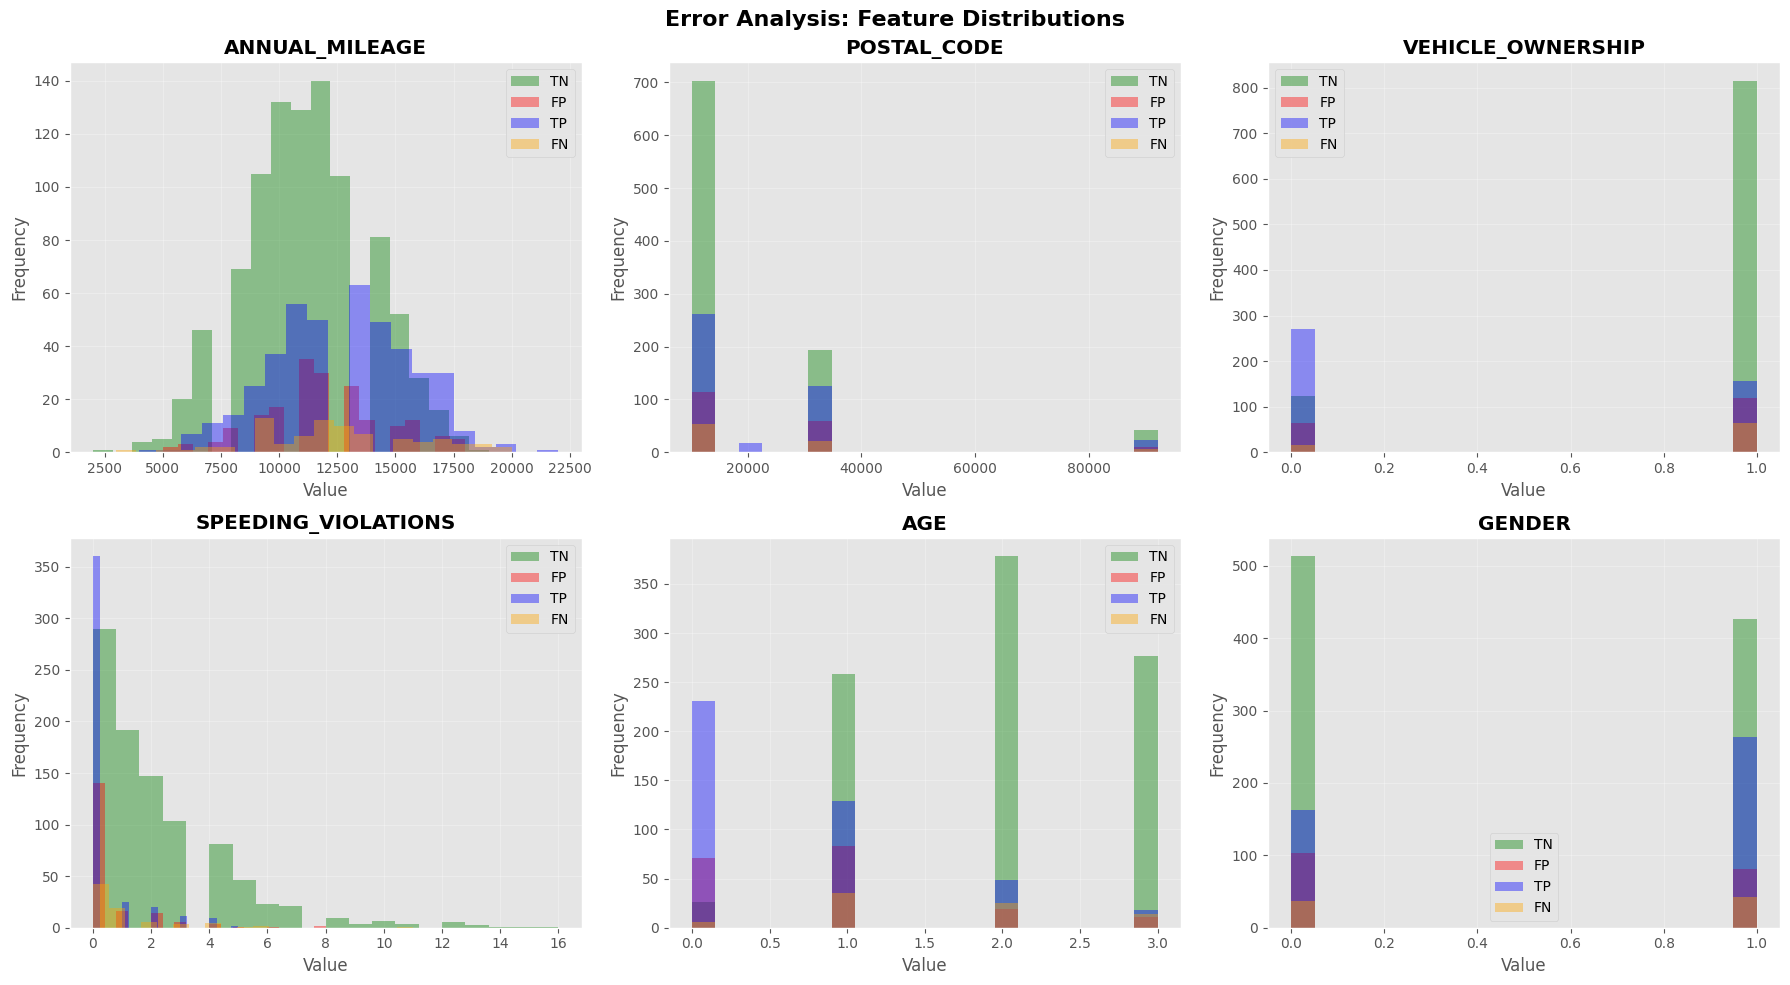


PROBABILITY DISTRIBUTION BY ERROR TYPE


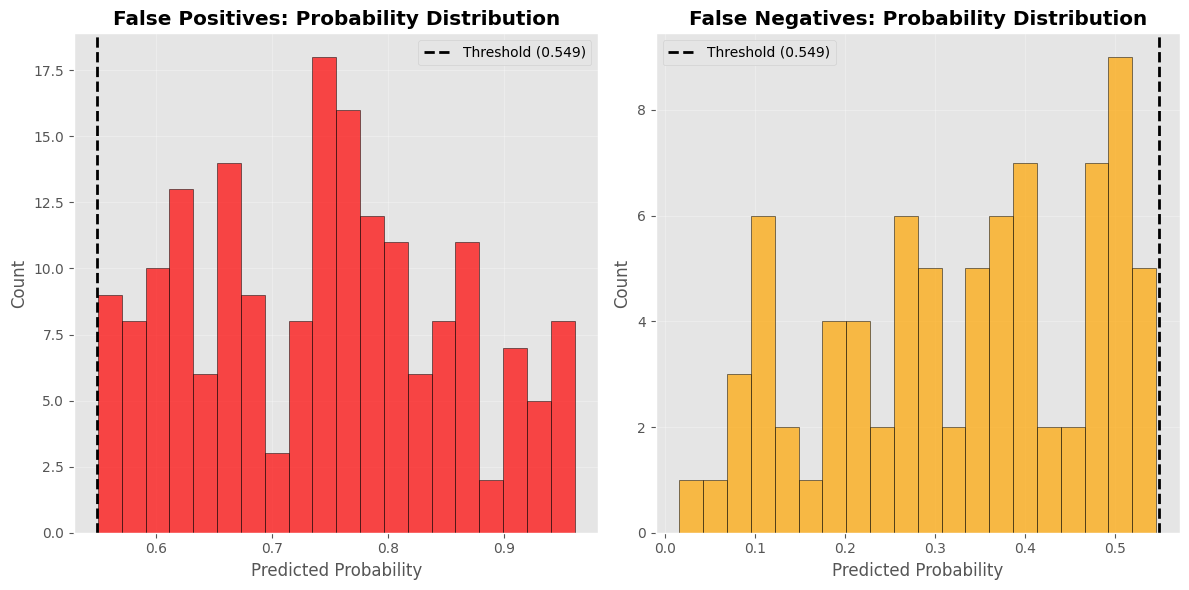


FP Probability Range: [0.550 - 0.960]
FN Probability Range: [0.016 - 0.546]


In [144]:
# Cell 1: Error Analysis
error_results = analyze_prediction_errors(xgb_model, X_train, X_test, y_test, threshold=0.549)


Prediction 42: Proba=0.618 → CLAIM
\nTop 10 Features Driving This Decision:
                                 feature  importance    value
PAST_ACCIDENTS            PAST_ACCIDENTS       0.200      0.0
DRIVING_EXPERIENCE    DRIVING_EXPERIENCE       0.181      0.0
AGE                                  AGE       0.135      2.0
VEHICLE_YEAR                VEHICLE_YEAR       0.097      0.0
VEHICLE_OWNERSHIP      VEHICLE_OWNERSHIP       0.091      1.0
INCOME                            INCOME       0.081      2.0
SPEEDING_VIOLATIONS  SPEEDING_VIOLATIONS       0.048      0.0
POSTAL_CODE                  POSTAL_CODE       0.038  32765.0
MARRIED                          MARRIED       0.028      1.0
GENDER                            GENDER       0.023      0.0


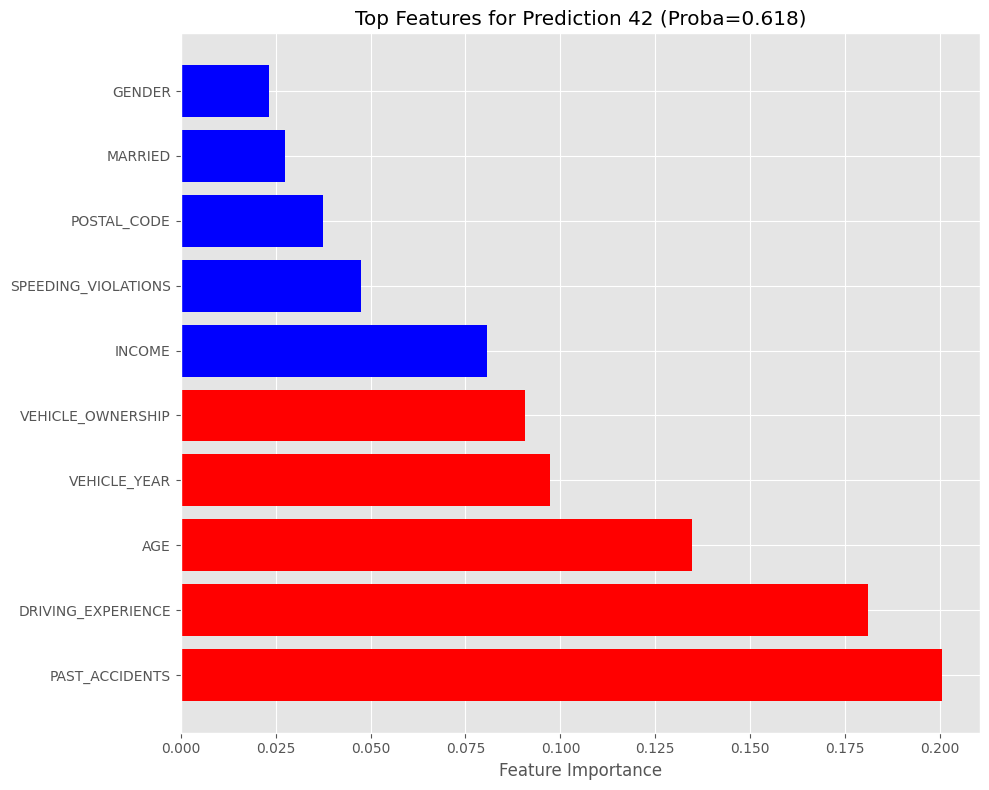

feature  importance    value
PAST_ACCIDENTS            PAST_ACCIDENTS    0.200452      0.0
DRIVING_EXPERIENCE    DRIVING_EXPERIENCE    0.181096      0.0
AGE                                  AGE    0.134688      2.0
VEHICLE_YEAR                VEHICLE_YEAR    0.097167      0.0
VEHICLE_OWNERSHIP      VEHICLE_OWNERSHIP    0.090790      1.0
INCOME                            INCOME    0.080598      2.0
SPEEDING_VIOLATIONS  SPEEDING_VIOLATIONS    0.047614      0.0
POSTAL_CODE                  POSTAL_CODE    0.037580  32765.0
MARRIED                          MARRIED    0.027520      1.0
GENDER                            GENDER    0.023187      0.0

In [145]:
# analyze_shap_values(xgb_model, X_train, X_test, y_test)
explain_single_prediction(xgb_model, X_test, idx=42)

BUSINESS IMPACT ANALYSIS

1. COST-BENEFIT ANALYSIS
--------------------------------------------------------------------------------
Cost per False Positive:  $150
Cost per False Negative:  $8,000
Benefit per True Positive: $5,000

Current Threshold (0.549):
  Net Profit: $1,492,950.00
  Precision: 0.696
  Recall: 0.846

Optimal Business Threshold (0.079):
  Net Profit: $2,413,150.00
  Improvement: $920,200.00 (61.6%)
  Precision: 0.441
  Recall: 0.996


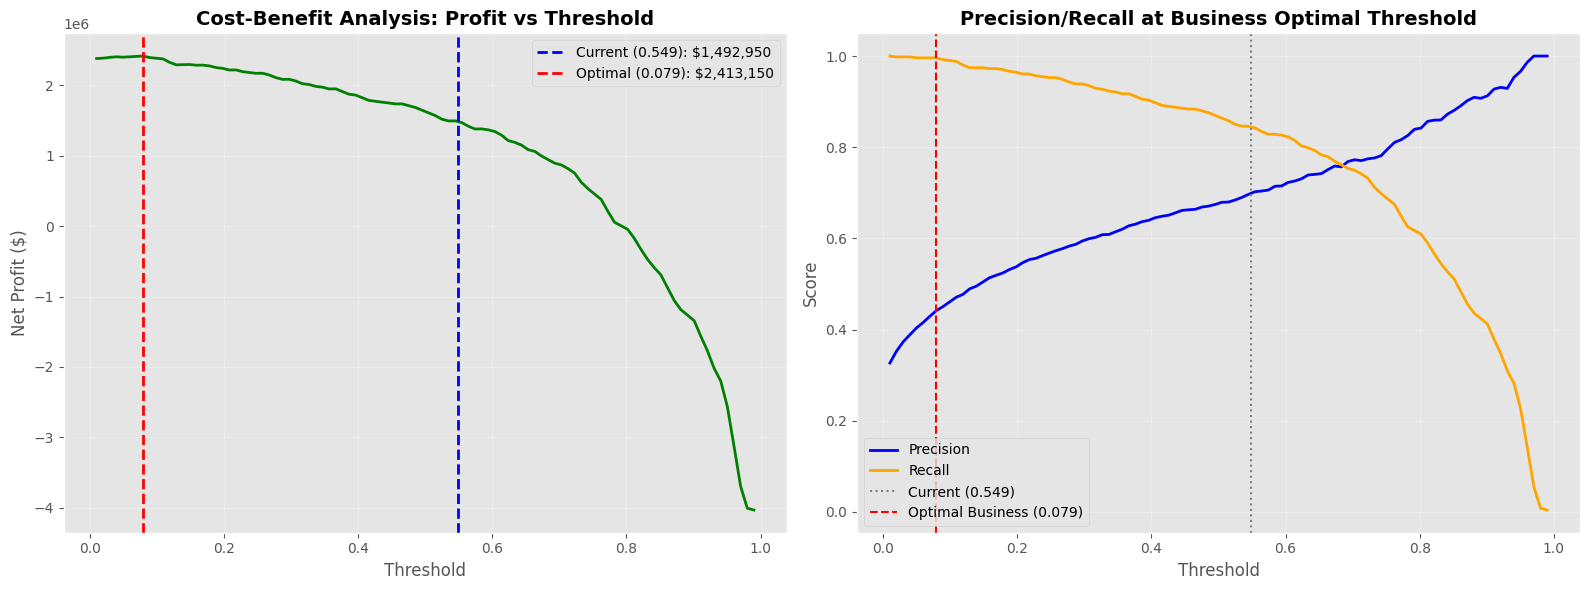


2. RISK STRATIFICATION
--------------------------------------------------------------------------------
           Count  Claims  Claim_Rate
Risk_Tier                           
Very Low     326     1.0    0.003067
Low          326    12.0    0.036810
Medium       326    53.0    0.162577
High         326   161.0    0.493865
Very High    326   280.0    0.858896


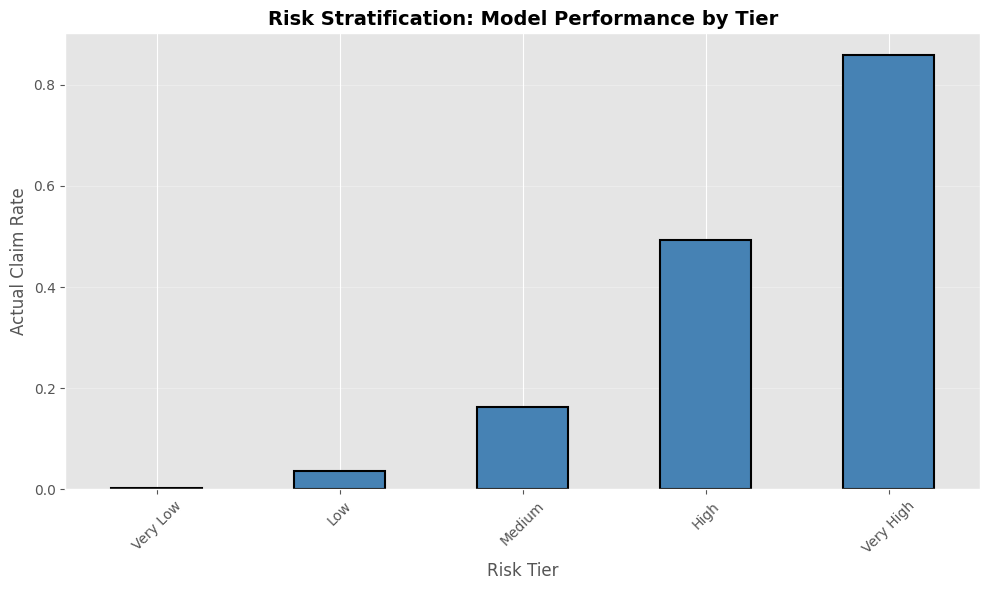


3. PREMIUM PRICING SIMULATION
--------------------------------------------------------------------------------
Base Premium:      $1,200
Avg Claim Amount:  $8,000

Total Premiums:    $3,526,197.50
Total Claims Paid: $4,056,000.00
Net Profit:        $-529,802.50
Loss Ratio:        115.02% (target: <75%)
⚠️  HIGH LOSS RATIO - Consider premium adjustments


{'optimal_threshold': np.float64(0.07929292929292929),
 'max_profit': np.int64(2413150),
 'current_profit': np.int64(1492950),
 'tier_analysis':            Count  Claims  Claim_Rate
 Risk_Tier                           
 Very Low     326     1.0    0.003067
 Low          326    12.0    0.036810
 Medium       326    53.0    0.162577
 High         326   161.0    0.493865
 Very High    326   280.0    0.858896,
 'loss_ratio': np.float64(1.1502475400200924)}

In [146]:
business_impact_analysis(xgb_model, X_test, y_test, threshold=0.549)

PERMUTATION IMPORTANCE (True Predictive Power)

Computing (may take 30-60 seconds)...

Top 15 Most Important Features:
            feature  importance      std
 DRIVING_EXPERIENCE    0.130408 0.005236
  VEHICLE_OWNERSHIP    0.052615 0.006776
       VEHICLE_YEAR    0.040753 0.005362
        POSTAL_CODE    0.036460 0.003672
             GENDER    0.019837 0.002166
     ANNUAL_MILEAGE    0.007563 0.001303
SPEEDING_VIOLATIONS    0.001451 0.000656
     PAST_ACCIDENTS    0.000727 0.000873
            MARRIED    0.000589 0.001089
                AGE    0.000179 0.000862
               RACE    0.000067 0.000060
           CHILDREN    0.000033 0.000067
       VEHICLE_TYPE    0.000026 0.000055
          EDUCATION    0.000000 0.000000
               DUIS   -0.000096 0.000084


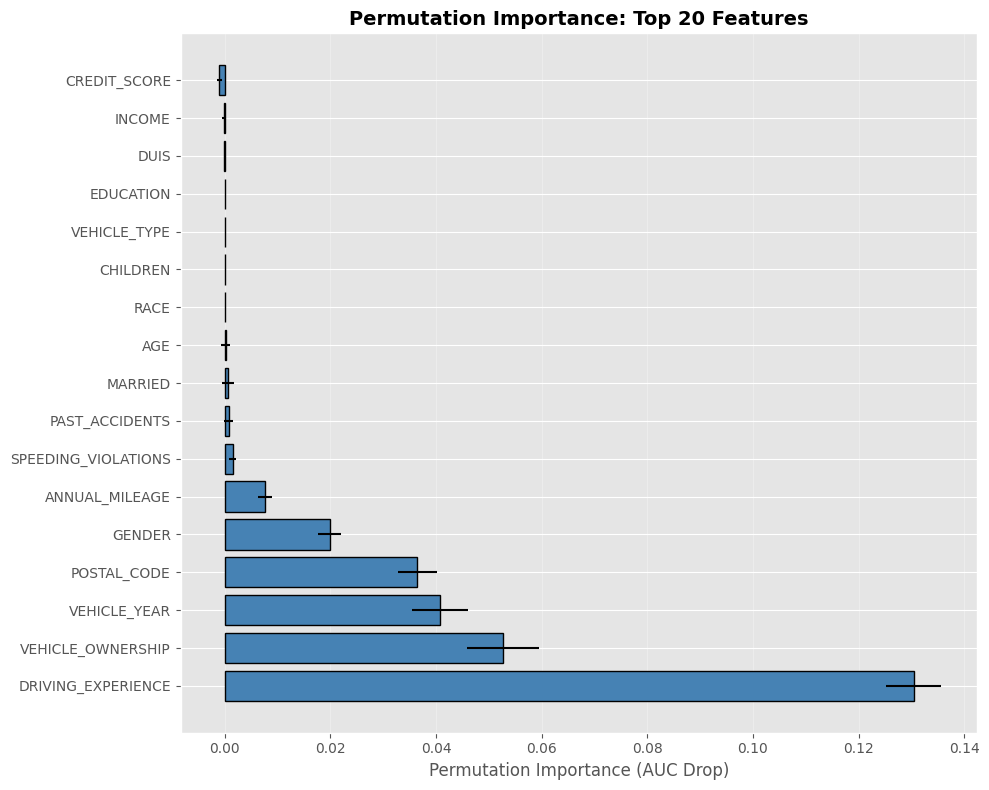

feature  importance       std
3    DRIVING_EXPERIENCE    0.130408  0.005236
7     VEHICLE_OWNERSHIP    0.052615  0.006776
8          VEHICLE_YEAR    0.040753  0.005362
11          POSTAL_CODE    0.036460  0.003672
1                GENDER    0.019837  0.002166
12       ANNUAL_MILEAGE    0.007563  0.001303
14  SPEEDING_VIOLATIONS    0.001451  0.000656
16       PAST_ACCIDENTS    0.000727  0.000873
9               MARRIED    0.000589  0.001089
0                   AGE    0.000179  0.000862
2                  RACE    0.000067  0.000060
10             CHILDREN    0.000033  0.000067
13         VEHICLE_TYPE    0.000026  0.000055
4             EDUCATION    0.000000  0.000000
15                 DUIS   -0.000096  0.000084
5                INCOME   -0.000197  0.000300
6          CREDIT_SCORE   -0.001051  0.000468

In [147]:
compute_permutation_importance(xgb_model, X_test, y_test)

CROSS-VALIDATION: MULTIPLE METRICS

Running 10-fold cross-validation...

RESULTS:
--------------------------------------------------------------------------------
Metric          Train Mean   Test Mean    Test Std   Gap       
--------------------------------------------------------------------------------
roc_auc              0.9305      0.9111    0.0184    0.0195
accuracy             0.8485      0.8344    0.0171    0.0141
precision            0.7134      0.6953    0.0252    0.0181
recall               0.8575      0.8343    0.0442    0.0233
f1                   0.7788      0.7579    0.0253    0.0209
brier                0.1082      0.1198    0.0114    0.0117
log_loss             0.3448      0.3760    0.0315    0.0312

OVERFITTING ANALYSIS:
--------------------------------------------------------------------------------
✅ No significant overfitting detected across all metrics


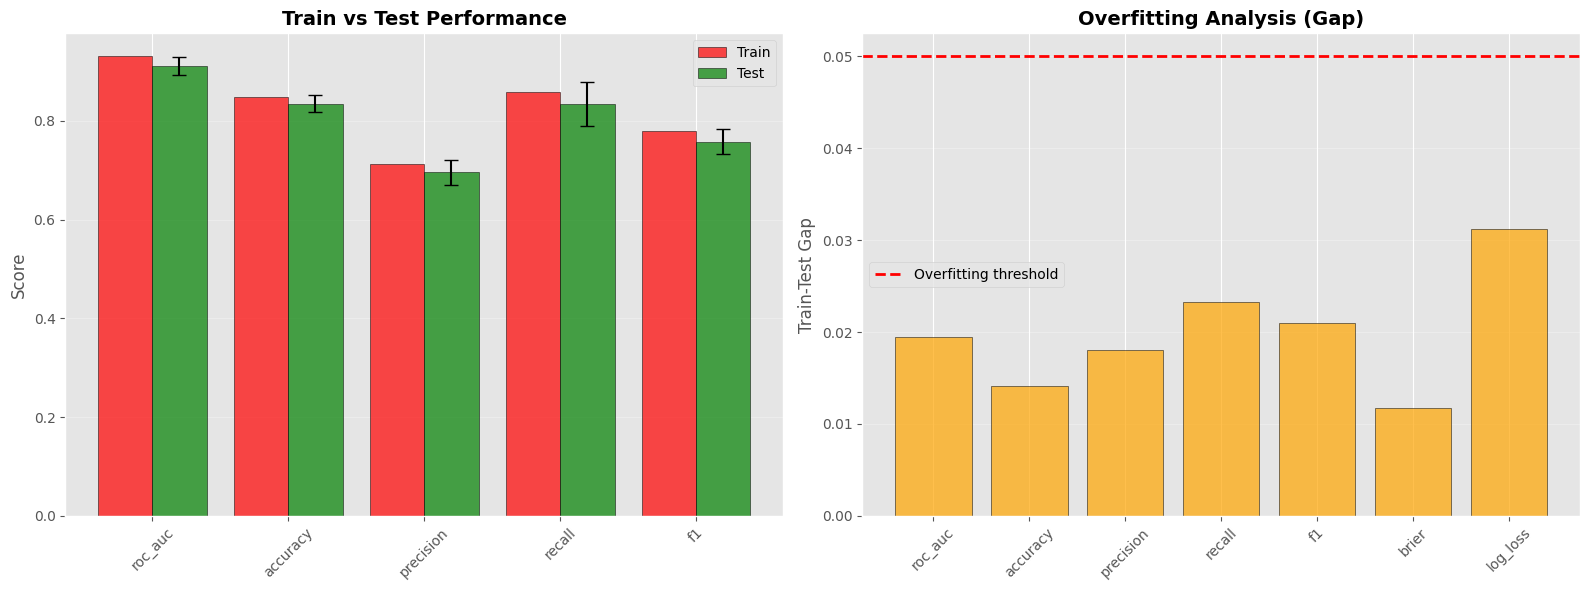

metric  train_mean  test_mean  test_std       gap
0    roc_auc    0.930541   0.911055  0.018421  0.019485
1   accuracy    0.848466   0.834356  0.017134  0.014110
2  precision    0.713381   0.695326  0.025174  0.018056
3     recall    0.857549   0.834275  0.044215  0.023275
4         f1    0.778804   0.757866  0.025282  0.020938
5      brier    0.108154   0.119842  0.011431  0.011688
6   log_loss    0.344800   0.376025  0.031510  0.031224

In [148]:
cross_validation_multiple_metrics(xgb_model, X_test, y_test)

PARTIAL DEPENDENCE PLOTS (Marginal Feature Effects)
Feature names detected: 17 features
Top 6 features by XGBoost importance: ['PAST_ACCIDENTS', 'DRIVING_EXPERIENCE', 'AGE', 'VEHICLE_YEAR', 'VEHICLE_OWNERSHIP', 'INCOME']


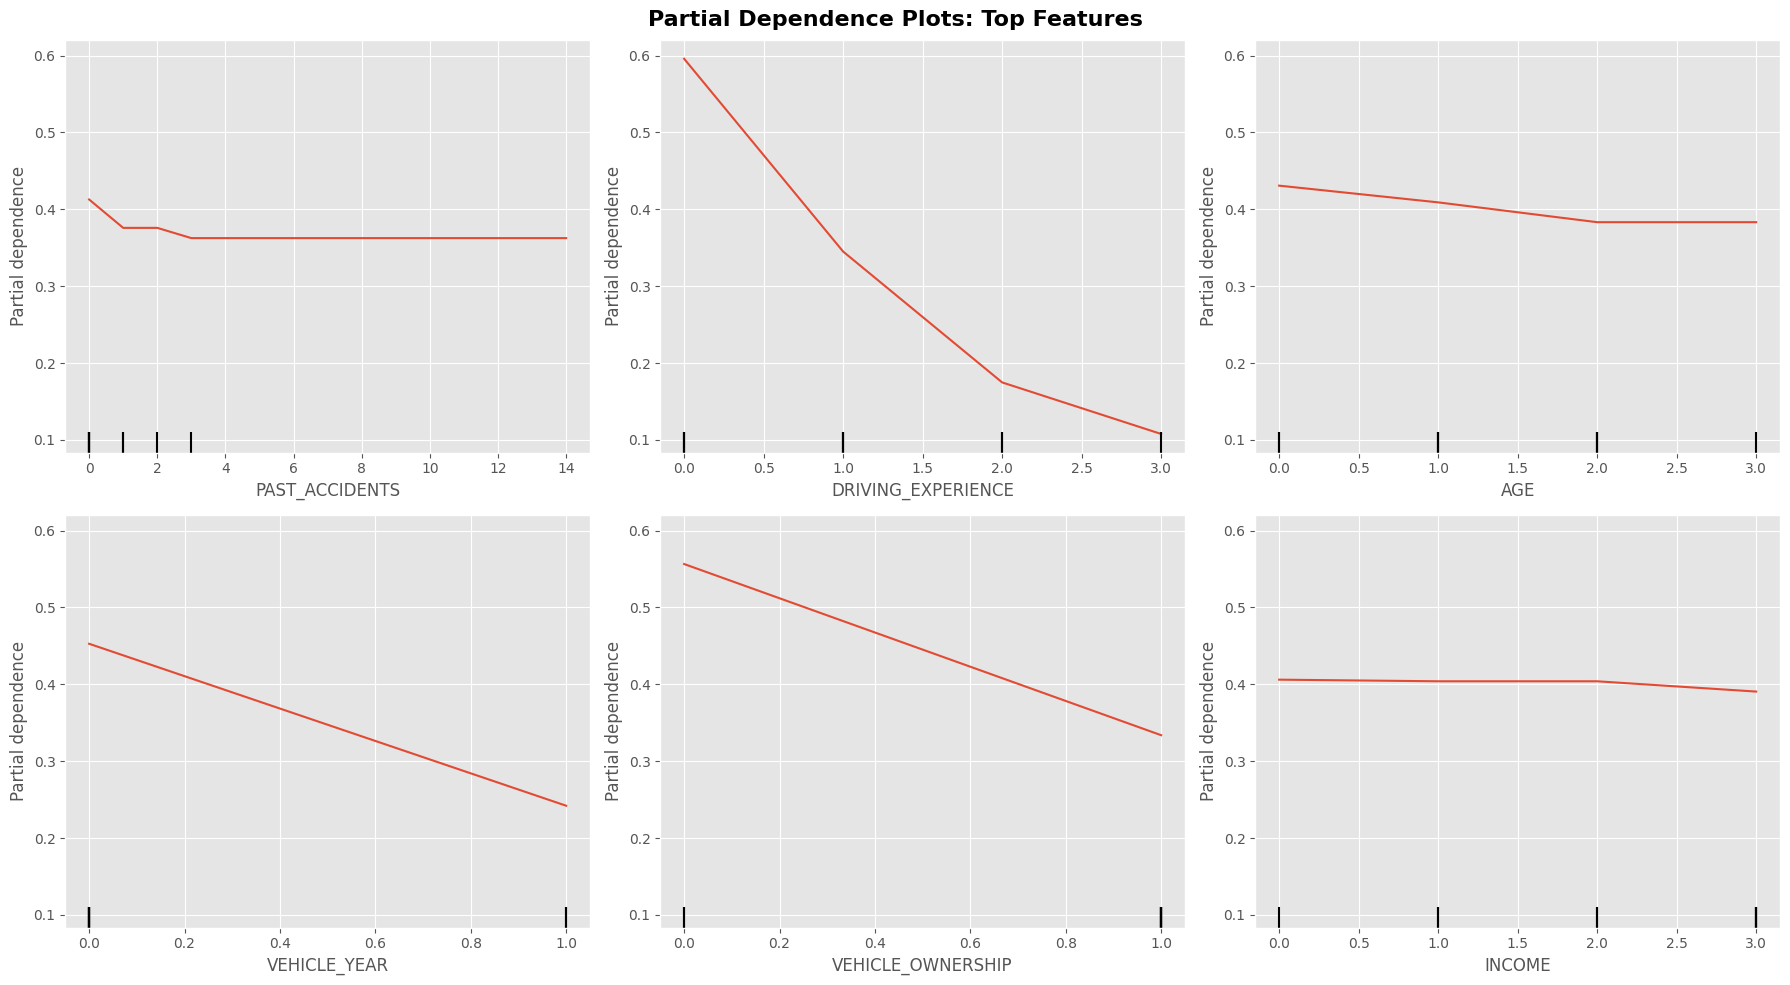

✅ Partial Dependence plots generated successfully!


['PAST_ACCIDENTS',
 'DRIVING_EXPERIENCE',
 'AGE',
 'VEHICLE_YEAR',
 'VEHICLE_OWNERSHIP',
 'INCOME']

In [149]:
plot_partial_dependence(xgb_model, X_test)

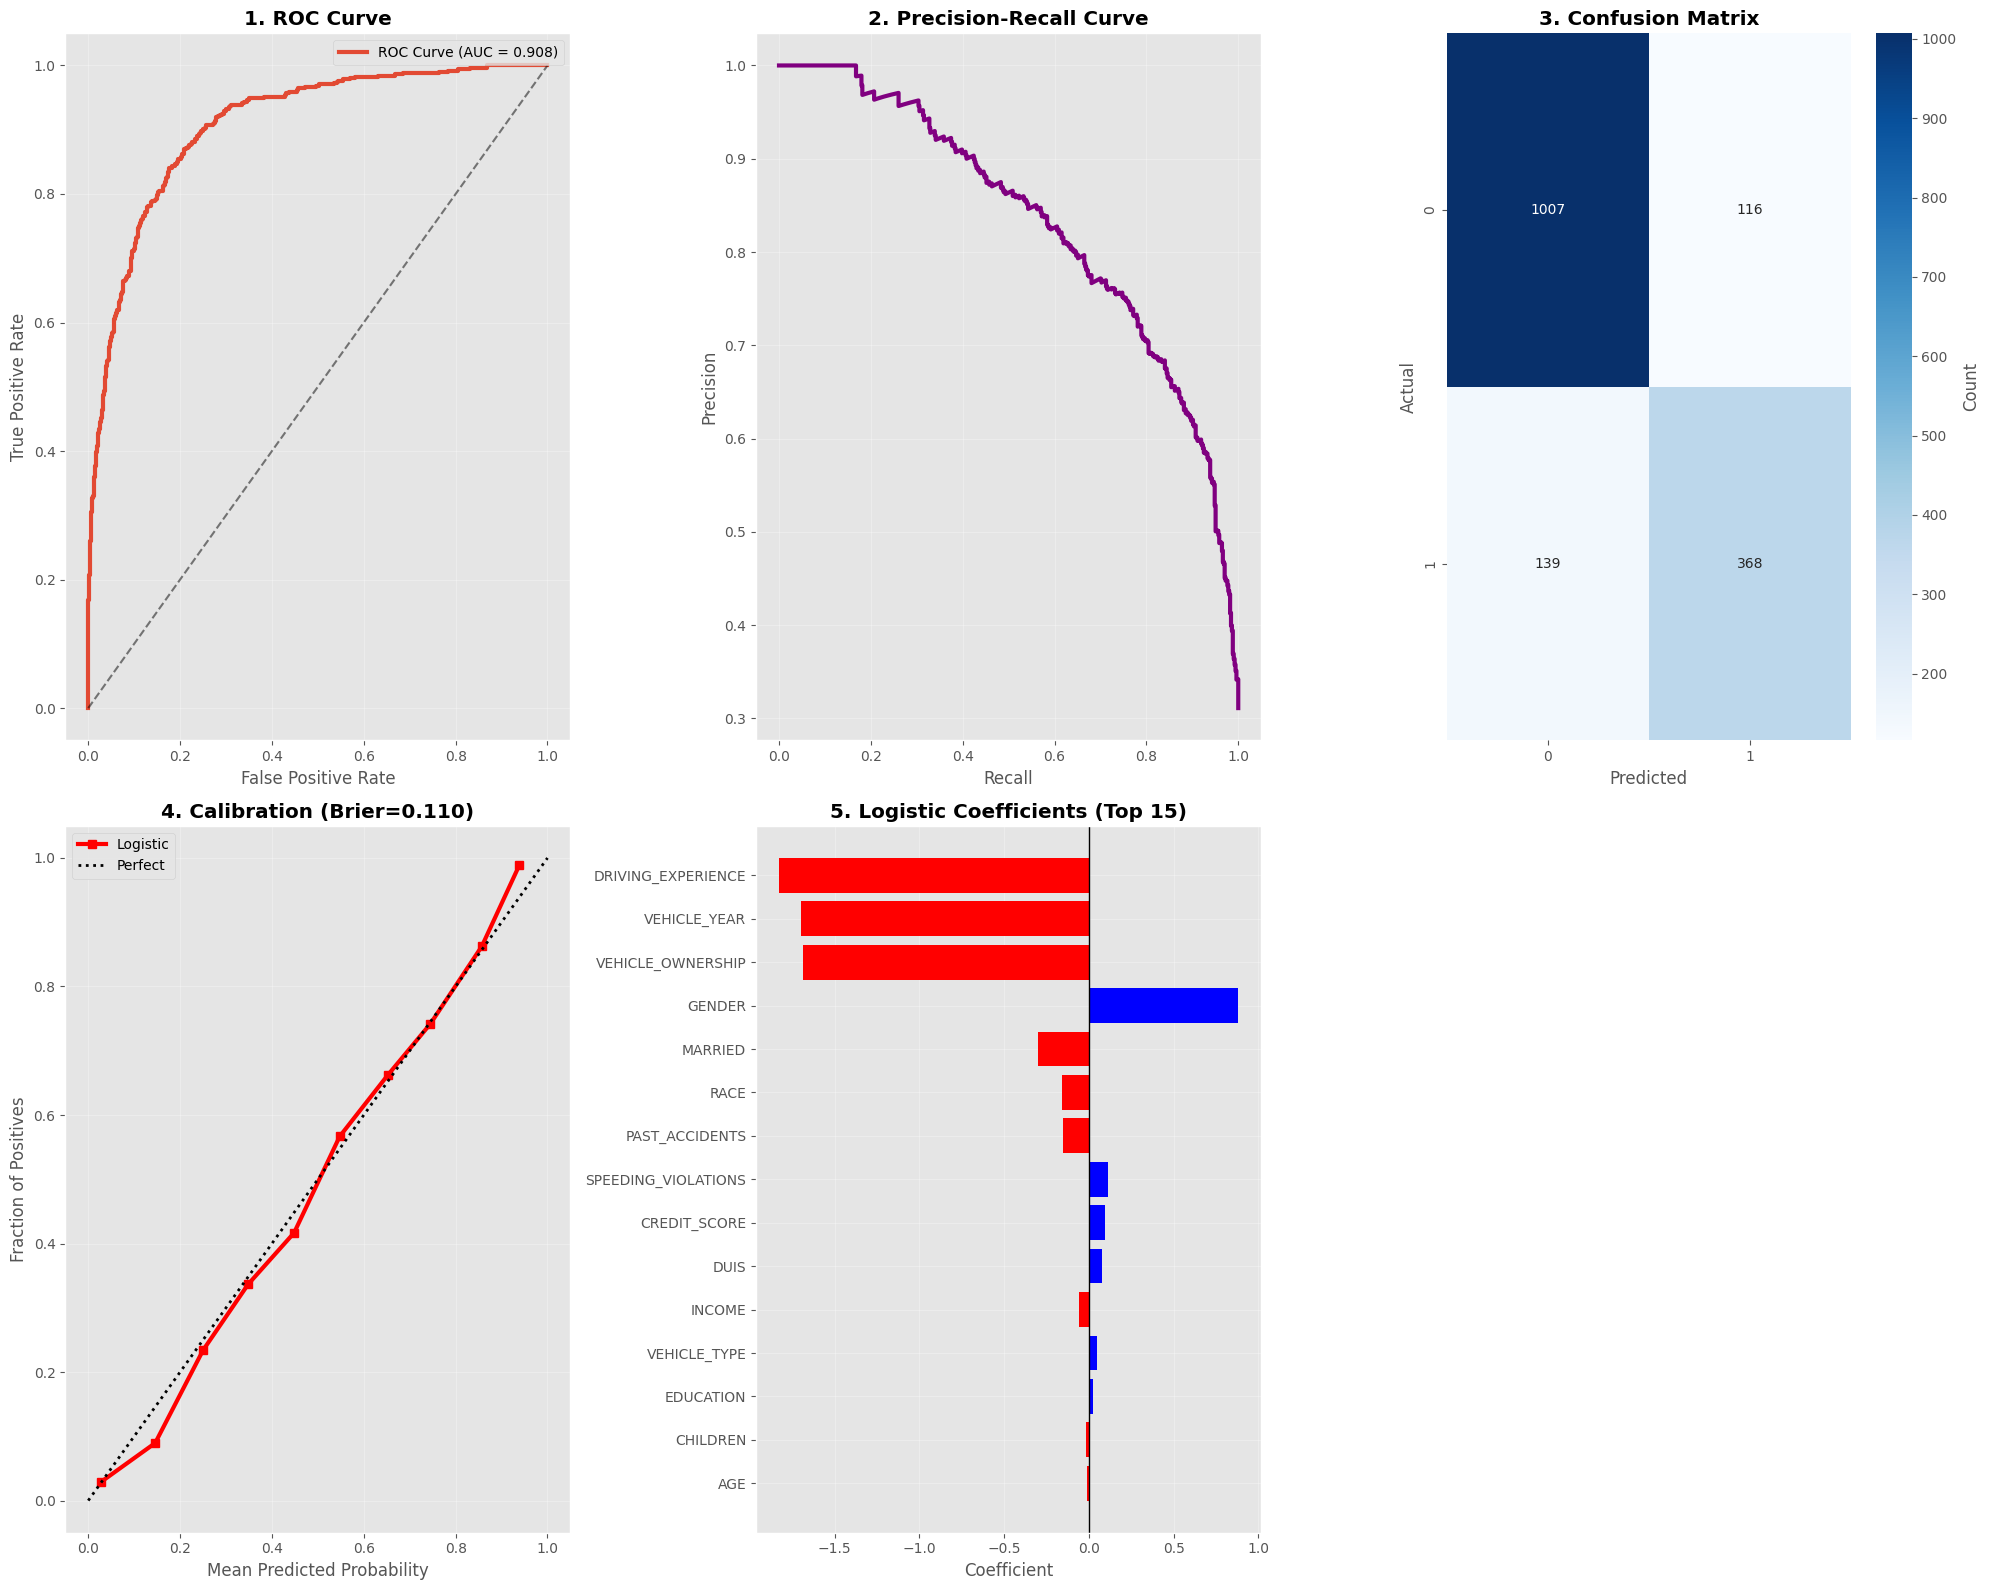

LOGISTIC REGRESSION DIAGNOSTICS
Metric          Value     
-------------------------
roc_auc         0.9079    
precision       0.7603    
recall          0.7258    
f1              0.7427    
brier           0.1101    
\nLOGISTIC COEFFICIENTS SUMMARY:
--------------------------------------------------
            feature  coefficient  abs_coef
        POSTAL_CODE     0.000022  0.000022
     ANNUAL_MILEAGE     0.000088  0.000088
                AGE    -0.013339  0.013339
           CHILDREN    -0.014266  0.014266
          EDUCATION     0.026936  0.026936
       VEHICLE_TYPE     0.047152  0.047152
             INCOME    -0.059635  0.059635
               DUIS     0.080336  0.080336
       CREDIT_SCORE     0.096196  0.096196
SPEEDING_VIOLATIONS     0.111221  0.111221


({'roc_auc': 0.9078879656316468,
  'precision': 0.7603305785123967,
  'recall': 0.7258382642998028,
  'f1': 0.7426841574167508,
  'brier': 0.11011729644715218},
                 feature  coefficient  abs_coef
 11          POSTAL_CODE     0.000022  0.000022
 12       ANNUAL_MILEAGE     0.000088  0.000088
 0                   AGE    -0.013339  0.013339
 10             CHILDREN    -0.014266  0.014266
 4             EDUCATION     0.026936  0.026936
 13         VEHICLE_TYPE     0.047152  0.047152
 5                INCOME    -0.059635  0.059635
 15                 DUIS     0.080336  0.080336
 6          CREDIT_SCORE     0.096196  0.096196
 14  SPEEDING_VIOLATIONS     0.111221  0.111221
 16       PAST_ACCIDENTS    -0.154607  0.154607
 2                  RACE    -0.160049  0.160049
 9               MARRIED    -0.302242  0.302242
 1                GENDER     0.881481  0.881481
 7     VEHICLE_OWNERSHIP    -1.686921  1.686921
 8          VEHICLE_YEAR    -1.697534  1.697534
 3    DRIVING_EXPERIENC

In [150]:
logistic_regression_diagnostics(
    logit, X_train, X_test, y_train, y_test
)

Running robust residual diagnostics...


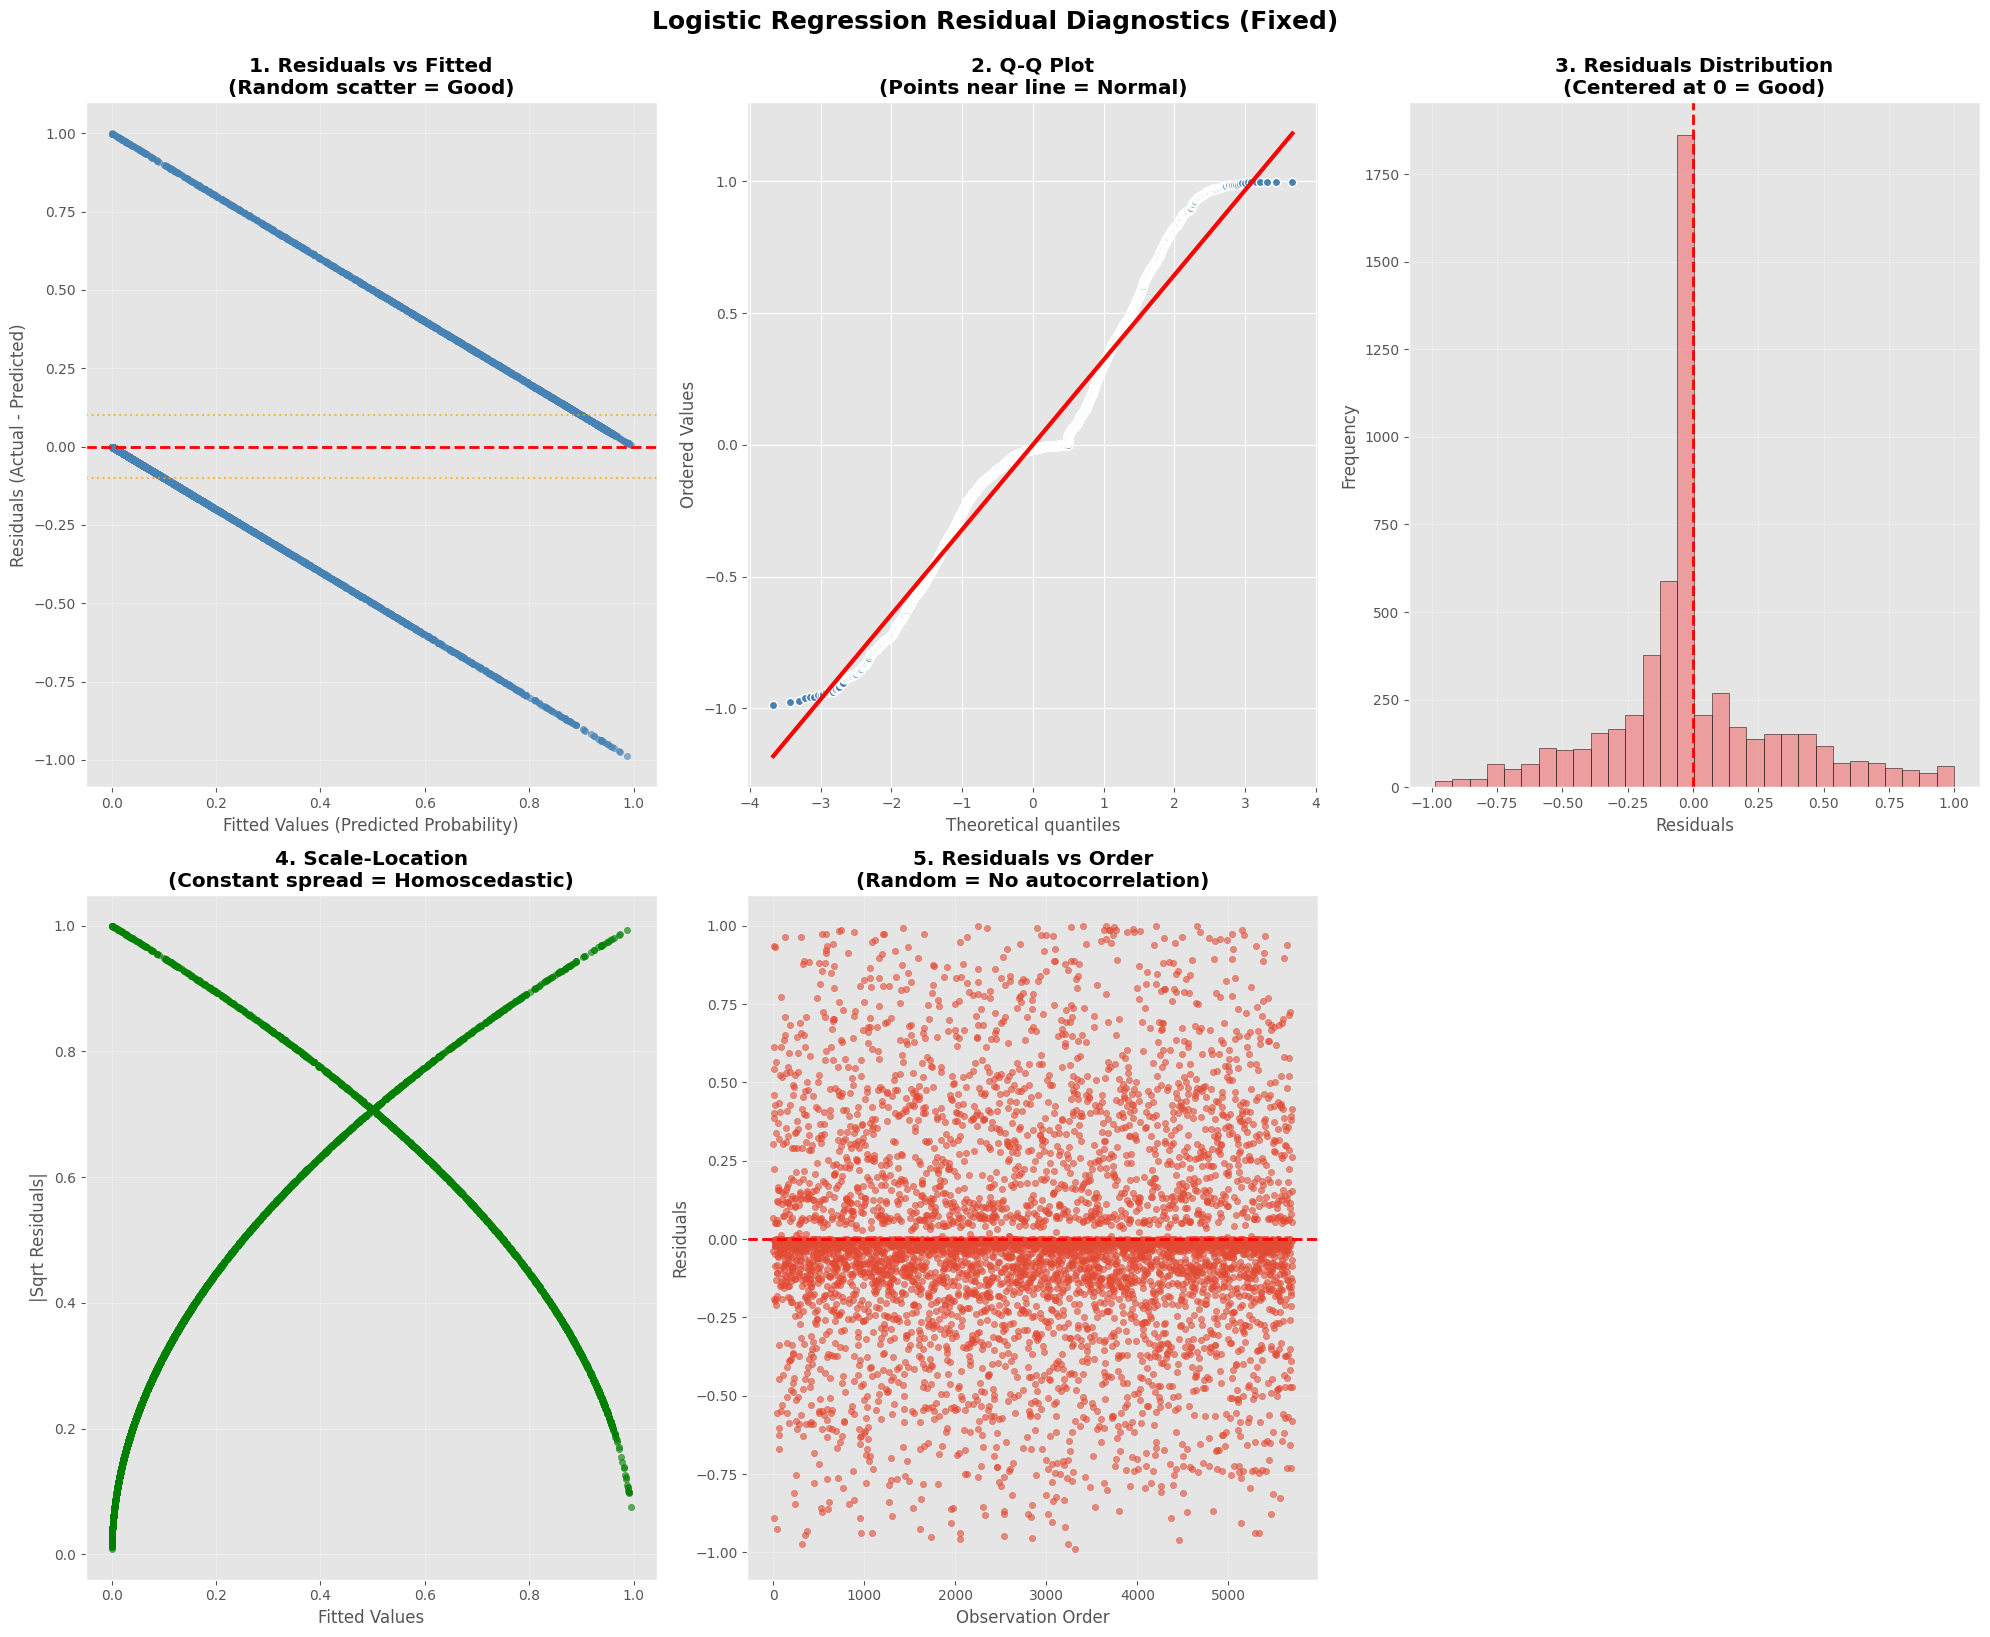

RESIDUAL DIAGNOSTICS SUMMARY
                      0
Mean Residual    0.0006
Median Residual -0.0163
Std Residuals    0.3314
Max |Residual|   0.9992
Skewness         0.3490
Kurtosis         1.0848
KS p-value       0.0000
Train AUC        0.9075
Test AUC         0.9079
\nINTERPRETATION:
----------------------------------------
✅ MEAN ≈ 0: No systematic bias
⚠️  NON-NORMAL: Consider robust methods
\n================================================================================
✅ ANALYSIS COMPLETE - 5 PLOTS + STATISTICS


In [151]:
residual_results = logistic_residual_diagnostics_fixed(
    logit, X_train, X_test, y_train, y_test, threshold=0.549
)


In [152]:
pickle_model(
    xgb_model=xgb_model,      # your Optuna-tuned XGBClassifier
    calibrator=calibrator,     # the IsotonicRegression from completecalibrationpipeline()
    threshold=0.5972,  # 0.5972 returned by optimizexgboost_optuna()
    X_train=X_train
)


Saved bundle with keys: ['xgb_model', 'calibrator', 'threshold']
Feature order (17 cols): ['AGE', 'GENDER', 'RACE', 'DRIVING_EXPERIENCE', 'EDUCATION', 'INCOME', 'CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'VEHICLE_YEAR', 'MARRIED', 'CHILDREN', 'POSTAL_CODE', 'ANNUAL_MILEAGE', 'VEHICLE_TYPE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS']
Threshold: 0.5972
